In [1]:
import sys,os

data_path = os.getcwd()

try:
    import localgraphclustering as lgc
except:
    # when the package is not installed, import the local version instead. 
    # the notebook must be placed in the original "notebooks/" folder
    sys.path.append("../")
    import localgraphclustering as lgc

In [2]:
import time
import numpy as np

import matplotlib.pyplot as plt

# Import the graph_tool module for visualization.
from graph_tool.all import * 

import statistics as stat_

# Load graph

In [3]:
# Read graph. This also supports gml format.
#g = lgc.GraphLocal(os.path.join(data_path,'datasets/JohnsHopkins.graphml'),'graphml')
g = lgc.GraphLocal(os.path.join(data_path,'datasets/Bucknell39_reduced.graphml'),'graphml')
# To get a quick look at the list of methods and attributes for the graph object 'g' you can type 'g.' + tab
# and scroll up or down.

vol_G = g.vol_G

/usr/local/lib/python3.7/site-packages/localgraphclustering/GraphLocal.py:217: UserWarning:

Loading a graphml is not efficient, we suggest using an edgelist format for this API.



## Load graph using GraphTool. We do this to handle some meta-data which LocalGraphClustering is not handling yet.

In [4]:
g_gtool = load_graph('datasets/Bucknell39_reduced.graphml')
remove_self_loops(g_gtool)

n = g_gtool.num_vertices()

## Load coordinates for graph layout

In [5]:
# Load pre-computed coordinates for nodes.
g_v_prop = g_gtool.vertex_properties
xx = g_v_prop.x
yy = g_v_prop.y

pos = g_gtool.new_vertex_property("vector<double>")
for i in range(n):
    pos[i] = [xx[i],yy[i]]

## Load and filter ground truth clusters. This part takes a while to run. The results are saved in results/

In [6]:
g_v_prop = g_gtool.vertex_properties
#feature_list = [g_v_prop.secondMajor,g_v_prop.highSchool,g_v_prop.gender,g_v_prop.dorm,g_v_prop.majorIndex,g_v_prop.year]
feature_list = [g_v_prop.dorm,g_v_prop.majorIndex,g_v_prop.year]

number_feature = 0

ref_nodes = []
info_ref_nodes = []

for kk in feature_list:
    
    feature = kk

    for ff in list(set(feature.a)):
        
        if ff == 0:
            continue

        feature_array = np.zeros(n)
        feature_ff_nodes = []
        for i in range(n):
            feature_array[i] = feature[i]
            if feature_array[i] == ff:
                feature_ff_nodes.append(i)

        g_ff = g_gtool.copy()

        del_list_ff = list(set(range(n)) - set(feature_ff_nodes))

        for v in reversed(sorted(del_list_ff)):
            g_ff.remove_vertex(v)   

        n_ff = g_ff.num_vertices() 

        comp_ff,hist_ff=label_components(g_ff)

        feature_ff_nodes_largest_component = []
        for i in range(n_ff):
            if comp_ff[i] == 0:
                feature_ff_nodes_largest_component.append(feature_ff_nodes[i])    

        vol_ff = sum(g.d[feature_ff_nodes_largest_component])
        
        if vol_ff < 1000:
            continue
            
        #temp = np.zeros(n)
        #temp[feature_ff_nodes_largest_component] = 1
        
        #cut_ff = vol_ff - (g.adjacency_matrix.dot(temp).transpose()).dot(temp)
        #cond_ff = cut_ff/min(vol_ff,vol_G - vol_ff)
        cond_ff = g.compute_conductance(feature_ff_nodes_largest_component,cpp=True)
        
        if cond_ff > 0.47:
            continue
            
        print("Reached")
        eig_ff, lambda_ff = lgc.fiedler_local(g, feature_ff_nodes_largest_component)
        lambda_ff = np.real(lambda_ff)
        gap_ff = lambda_ff/cond_ff
        
        print("Number of feature", number_feature, "Feature value ", ff, " gap ",gap_ff, " volume: ", vol_ff, " size:", len(feature_ff_nodes_largest_component), "conductance: ", cond_ff)
        
        if gap_ff >= 0.5 and vol_ff >= 1000:
            ref_nodes.append(feature_ff_nodes_largest_component)
            info_ref_nodes.append([number_feature,ff])
            np.save('results/ref_nodes_Bucknell39', ref_nodes) 
            np.save('results/info_ref_nodes_Bucknell39', info_ref_nodes) 
        
    number_feature += 1

Reached
Number of feature 2 Feature value  2007  gap  [0.93249827]  volume:  75526.0  size: 702 conductance:  0.4323279400471361
Reached
Number of feature 2 Feature value  2008  gap  [0.92468074]  volume:  80776.0  size: 808 conductance:  0.2897890462513618
Reached
Number of feature 2 Feature value  2009  gap  [0.90690619]  volume:  48186.0  size: 801 conductance:  0.15323953015398664


## If you have generated the ground truth datasets once, you can avoid rerunning the above code and simple run the code below.

In [7]:
ref_nodes = np.load('results/ref_nodes_Bucknell39.npy') 
info_ref_nodes = np.load('results/info_ref_nodes_Bucknell39.npy') 

## Visualize the ground truth clusters

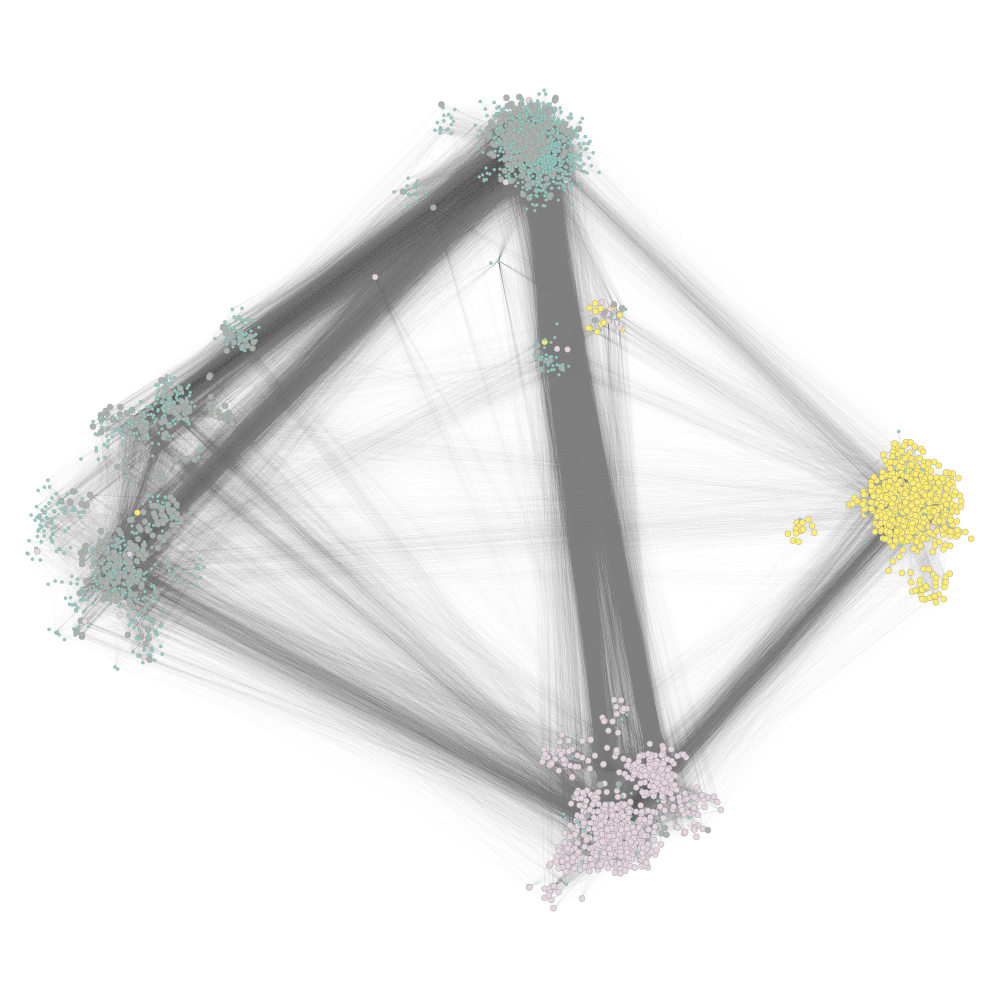

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x142723eb8, at 0x13edc1cc0>

In [8]:
temp = np.zeros(n)
temp = temp + 3

temp2 = np.zeros(n, dtype=int)

counter = 0

for i in ref_nodes:
        
    temp[i] = 6
    
    for j in i:
        temp2[j] = int(info_ref_nodes[counter,1])
    counter += 1

node_size = g_gtool.new_vertex_property("double",temp)

node_colours = g_gtool.new_vertex_property("int",temp2)

c_map = plt.get_cmap('Dark2')

graph_draw(g_gtool, pos, output_size=(1000, 1000),
            vertex_size=node_size, 
            vertex_fill_color=node_colours,
            edge_pen_width=0.1,
            edge_color = [0.0, 0, 0, 0.05]
            )

## Results by spectral algorithm: https://dl.acm.org/citation.cfm?id=1170528 

In [9]:
nodes = {}
external_best_cond_acl = {}
external_best_pre_cond_acl = {}
gap_best_cond_acl = {}
gap_best_pre_acl = {}
vol_best_cond_acl = {}
vol_best_pre_acl = {}
size_clust_best_cond_acl = {}
size_clust_best_pre_acl = {}
f1score_best_cond_acl = {}
f1score_best_pre_acl = {}
true_positives_best_cond_acl = {}
true_positives_best_pre_acl = {}
precision_best_cond_acl = {}
precision_best_pre_acl = {}
recall_best_cond_acl = {}
recall_best_pre_acl = {}
cuts_best_cond_acl = {}
cuts_best_pre_acl = {}
cuts_acl_ALL = {}

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)
    
    nodes[ct_outer] = np.random.choice(rr, how_many, replace=False)
    
    eigv, lambda_val = lgc.fiedler_local(g, rr)
    lambda_val = np.real(lambda_val)
    
    step = (2*lambda_val - lambda_val/2)/4
    
    a_list = np.arange(lambda_val/2,2*lambda_val,step)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        max_precision = -1
        min_conduct = 100
        
        ct_inner = 0
        for a in a_list:

            output_pr_clustering = lgc.spectral_clustering(g,ref_node,method="l1reg",alpha=a,rho=2.0e-7,epsilon=1.0e-2,iterations=1000)
            
            S_l1pr = output_pr_clustering[0]
            
            cuts_acl_ALL[ct_outer,node,ct_inner] = S_l1pr
            
            size_clust_acl_ = len(S_l1pr)
            
            cond_val_l1pr = output_pr_clustering[1]
            
            vol_ = sum(g.d[S_l1pr])
            true_positives_acl_ = set(rr).intersection(S_l1pr)
            if len(true_positives_acl_) == 0:
                true_positives_acl_ = set(ref_node)
                vol_ = g.d[ref_node][0,0]
            precision = sum(g.d[np.array(list(true_positives_acl_))])/vol_
            recall = sum(g.d[np.array(list(true_positives_acl_))])/sum(g.d[rr])
            f1_score_ = 2*(precision*recall)/(precision + recall)
            
            if f1_score_ >= max_precision:
            
                max_precision = f1_score_
            
                S_smqi, S_smqi_val = lgc.fiedler_local(g, S_l1pr)
                S_smqi_val = np.real(S_smqi_val)

                external_best_pre_cond_acl[ct_outer,node] = cond_val_l1pr
                gap_best_pre_acl[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_l1pr])))/cond_val_l1pr
                vol_best_pre_acl[ct_outer,node] = vol_

                size_clust_best_pre_acl[ct_outer,node] = size_clust_acl_
                true_positives_best_pre_acl[ct_outer,node] = true_positives_acl_
                precision_best_pre_acl[ct_outer,node] = precision
                recall_best_pre_acl[ct_outer,node] = recall
                f1score_best_pre_acl[ct_outer,node] = f1_score_
                
                cuts_best_pre_acl[ct_outer,node] = S_l1pr
                
            if cond_val_l1pr <= min_conduct:
            
                min_conduct = cond_val_l1pr
            
                S_smqi, S_smqi_val = lgc.fiedler_local(g, S_l1pr)
                S_smqi_val = np.real(S_smqi_val)

                external_best_cond_acl[ct_outer,node] = cond_val_l1pr
                gap_best_cond_acl[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_l1pr])))/cond_val_l1pr
                vol_best_cond_acl[ct_outer,node] = vol_

                size_clust_best_cond_acl[ct_outer,node] = size_clust_acl_
                true_positives_best_cond_acl[ct_outer,node] = true_positives_acl_
                precision_best_cond_acl[ct_outer,node] = precision
                recall_best_cond_acl[ct_outer,node] = recall
                f1score_best_cond_acl[ct_outer,node] = f1_score_
                
                cuts_best_cond_acl[ct_outer,node] = S_l1pr

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', external_best_cond_acl[ct_outer,node], 'f1score: ', f1score_best_pre_acl[ct_outer,node], 'precision: ', precision_best_pre_acl[ct_outer,node], 'recall: ', recall_best_pre_acl[ct_outer,node])
        ct += 1
    ct_outer += 1
    
    np.save('results/size_clust_best_cond_acl_Bucknell39', size_clust_best_cond_acl) 
    np.save('results/external_best_cond_acl_Bucknell39', external_best_cond_acl)
    np.save('results/vol_best_cond_acl_Bucknell39', vol_best_cond_acl) 
    np.save('results/gap_best_cond_acl_Bucknell39', gap_best_cond_acl) 
    np.save('results/cuts_best_cond_acl_Bucknell39', cuts_best_cond_acl) 
    np.save('results/true_positives_best_cond_acl_Bucknell39', true_positives_best_cond_acl)
    np.save('results/f1score_best_cond_acl_Bucknell39', f1score_best_cond_acl) 
    np.save('results/precision_best_cond_acl_Bucknell39', precision_best_cond_acl) 
    np.save('results/recall_best_cond_acl_Bucknell39', recall_best_cond_acl) 

    np.save('results/size_clust_best_pre_acl_Bucknell39', size_clust_best_pre_acl) 
    np.save('results/external_best_pre_cond_acl_Bucknell39', external_best_pre_cond_acl)
    np.save('results/vol_best_pre_acl_Bucknell39', vol_best_pre_acl) 
    np.save('results/gap_best_pre_acl_Bucknell39', gap_best_pre_acl) 
    np.save('results/cuts_best_pre_acl_Bucknell39', cuts_best_pre_acl) 
    np.save('results/true_positives_best_pre_acl_Bucknell39', true_positives_best_pre_acl)
    np.save('results/f1score_best_pre_acl_Bucknell39', f1score_best_pre_acl) 
    np.save('results/precision_best_pre_acl_Bucknell39', precision_best_pre_acl) 
    np.save('results/recall_best_pre_acl_Bucknell39', recall_best_pre_acl) 

    np.save('results/cuts_acl_ALL_Bucknell39', cuts_acl_ALL) 
    
    np.save('results/nodes_Bucknell39', nodes)

351
outer: 0 number of node:  2450  completed:  0.0  degree:  98.0
conductance:  0.24526810212528485 f1score:  0.6531471502790814 precision:  0.6356368648580916 recall:  0.6716494981860551
outer: 0 number of node:  377  completed:  0.002849002849002849  degree:  41.0
conductance:  0.2782044824981113 f1score:  0.497039400713274 precision:  0.36665282026106766 recall:  0.771337023011943
outer: 0 number of node:  1885  completed:  0.005698005698005698  degree:  3.0
conductance:  0.24435725825063467 f1score:  0.4953472518108224 precision:  0.36519155138402 recall:  0.7696554828800678
outer: 0 number of node:  3498  completed:  0.008547008547008548  degree:  113.0
conductance:  0.23294046425395865 f1score:  0.47481916142110314 precision:  0.350323364756705 recall:  0.7365807801286974
outer: 0 number of node:  3815  completed:  0.011396011396011397  degree:  9.0
conductance:  0.2726286852790598 f1score:  0.38864171013603355 precision:  0.28655371350284686 recall:  0.6037258692370839
outer: 0

outer: 0 number of node:  3644  completed:  0.1168091168091168  degree:  200.0
conductance:  0.21017969295184927 f1score:  0.5629266629197163 precision:  0.538122547539994 recall:  0.5901279029738103
outer: 0 number of node:  3250  completed:  0.11965811965811966  degree:  122.0
conductance:  0.25852927471254233 f1score:  0.5438419105883557 precision:  0.40118837058531026 recall:  0.8439212986256388
outer: 0 number of node:  2311  completed:  0.1225071225071225  degree:  263.0
conductance:  0.2532676857984738 f1score:  0.5937818552497451 precision:  0.6016090017122823 recall:  0.5861557609300109
outer: 0 number of node:  3323  completed:  0.12535612535612536  degree:  217.0
conductance:  0.24630929522490477 f1score:  0.46916252631220123 precision:  0.3458996204981276 recall:  0.7289145459841644
outer: 0 number of node:  1584  completed:  0.1282051282051282  degree:  131.0
conductance:  0.19563646219170658 f1score:  0.5590203956422263 precision:  0.4121283318989075 recall:  0.8686147816

outer: 0 number of node:  2862  completed:  0.2336182336182336  degree:  132.0
conductance:  0.2596509783183501 f1score:  0.6495988989633179 precision:  0.6260977437144577 recall:  0.6749331356089294
outer: 0 number of node:  3318  completed:  0.23646723646723647  degree:  52.0
conductance:  0.25260426507450656 f1score:  0.4479922758479265 precision:  0.33070106278974426 recall:  0.6942112649948362
outer: 0 number of node:  953  completed:  0.23931623931623933  degree:  69.0
conductance:  0.27740593685006615 f1score:  0.5191532172118918 precision:  0.3828337189417564 recall:  0.806238911103461
outer: 0 number of node:  3158  completed:  0.24216524216524216  degree:  86.0
conductance:  0.3290897757966115 f1score:  0.4895244514788633 precision:  0.3611158317440536 recall:  0.7596456849296931
outer: 0 number of node:  396  completed:  0.245014245014245  degree:  136.0
conductance:  0.17786561264822134 f1score:  0.6422759059122696 precision:  0.6177391346882872 recall:  0.6688425178084368


outer: 0 number of node:  27  completed:  0.3504273504273504  degree:  73.0
conductance:  0.2327722189523249 f1score:  0.5119670298727783 precision:  0.3776783241433139 recall:  0.7944416492333766
outer: 0 number of node:  3430  completed:  0.35327635327635326  degree:  205.0
conductance:  0.22076777292961347 f1score:  0.5647945464412236 precision:  0.523458073849701 recall:  0.6132192887217647
outer: 0 number of node:  3407  completed:  0.3561253561253561  degree:  59.0
conductance:  0.24929304260440768 f1score:  0.5733120562534134 precision:  0.42295488598733333 recall:  0.8895347297619363
outer: 0 number of node:  3386  completed:  0.358974358974359  degree:  25.0
conductance:  0.225574946990703 f1score:  0.4340361406427617 precision:  0.32339674318684813 recall:  0.659746312528136
outer: 0 number of node:  817  completed:  0.36182336182336183  degree:  85.0
conductance:  0.2937687701868047 f1score:  0.6528524539916477 precision:  0.6305071784498495 recall:  0.6768397637899531
outer

outer: 0 number of node:  539  completed:  0.4672364672364672  degree:  109.0
conductance:  0.2337763508887892 f1score:  0.5720344949712612 precision:  0.42202522241180657 recall:  0.8874956968461192
outer: 0 number of node:  3752  completed:  0.4700854700854701  degree:  88.0
conductance:  0.3016381048387097 f1score:  0.38600546781368494 precision:  0.28471658581702186 recall:  0.5991579058867145
outer: 0 number of node:  1547  completed:  0.47293447293447294  degree:  72.0
conductance:  0.2440788147550897 f1score:  0.44470327232390466 precision:  0.32806047940376676 recall:  0.6900537563223261
outer: 0 number of node:  2460  completed:  0.4757834757834758  degree:  89.0
conductance:  0.27186001524860903 f1score:  0.5233009791618647 precision:  0.3861271385018519 recall:  0.8116410242830283
outer: 0 number of node:  2352  completed:  0.47863247863247865  degree:  108.0
conductance:  0.34824116172747765 f1score:  0.4920794697467308 precision:  0.3629631027886842 recall:  0.763776712655

outer: 0 number of node:  2527  completed:  0.584045584045584  degree:  26.0
conductance:  0.4047262334915459 f1score:  0.4100023892415864 precision:  0.30246509461279886 recall:  0.636191510208405
outer: 0 number of node:  789  completed:  0.5868945868945868  degree:  12.0
conductance:  0.2793533481482414 f1score:  0.5645809230664145 precision:  0.41662098730428754 recall:  0.8755130683473241
outer: 0 number of node:  197  completed:  0.5897435897435898  degree:  86.0
conductance:  0.21111616917040602 f1score:  0.6072068781243447 precision:  0.6207316229859623 recall:  0.5942589306993618
outer: 0 number of node:  3187  completed:  0.5925925925925926  degree:  163.0
conductance:  0.28145303450012593 f1score:  0.4412039505962158 precision:  0.32547570639961226 recall:  0.6846384026692794
outer: 0 number of node:  1163  completed:  0.5954415954415955  degree:  24.0
conductance:  0.3713202890886656 f1score:  0.354767411099069 precision:  0.2617290790500894 recall:  0.5504329634827742
oute

outer: 0 number of node:  60  completed:  0.7037037037037037  degree:  170.0
conductance:  0.2303595374048589 f1score:  0.498468129411062 precision:  0.36775001888835723 recall:  0.7733628154542806
outer: 0 number of node:  3567  completed:  0.7065527065527065  degree:  70.0
conductance:  0.29681676236526644 f1score:  0.5181518151815183 precision:  0.5166241082475583 recall:  0.5196885840637662
outer: 0 number of node:  1693  completed:  0.7094017094017094  degree:  194.0
conductance:  0.23789370264704215 f1score:  0.6702652664235631 precision:  0.6352029021588363 recall:  0.7094245690225882
outer: 0 number of node:  118  completed:  0.7122507122507122  degree:  151.0
conductance:  0.24578187291770323 f1score:  0.48790812995292976 precision:  0.35997607128239034 recall:  0.7569049069194714
outer: 0 number of node:  2739  completed:  0.7150997150997151  degree:  302.0
conductance:  0.2509900865222107 f1score:  0.4525182556473077 precision:  0.33378638577415337 recall:  0.702354156184625

outer: 0 number of node:  235  completed:  0.8205128205128205  degree:  79.0
conductance:  0.26191750124320956 f1score:  0.5091279880881783 precision:  0.3755877705947892 recall:  0.7900193310912799
outer: 0 number of node:  1294  completed:  0.8233618233618234  degree:  47.0
conductance:  0.22898424873965795 f1score:  0.5485698682503924 precision:  0.404688463911166 recall:  0.8512035590392713
outer: 0 number of node:  3359  completed:  0.8262108262108262  degree:  7.0
conductance:  0.26017848589507653 f1score:  0.43880884748914534 precision:  0.32366487139477523 recall:  0.6811164367237772
outer: 0 number of node:  896  completed:  0.8290598290598291  degree:  28.0
conductance:  0.22937040514852391 f1score:  0.5197281463984513 precision:  0.3832918270319221 recall:  0.8069803776183037
outer: 0 number of node:  1026  completed:  0.8319088319088319  degree:  8.0
conductance:  0.23987279997481187 f1score:  0.5288359415987408 precision:  0.3900806060873012 recall:  0.8208034319307258
out

outer: 0 number of node:  3515  completed:  0.9401709401709402  degree:  215.0
conductance:  0.16763030721435968 f1score:  0.7378048025362545 precision:  0.6929814358163123 recall:  0.78882768847814
outer: 0 number of node:  2448  completed:  0.9430199430199431  degree:  116.0
conductance:  0.17432432432432432 f1score:  0.6910835770861407 precision:  0.6861987494941848 recall:  0.696038450334984
outer: 0 number of node:  3126  completed:  0.9458689458689459  degree:  269.0
conductance:  0.23988794107463252 f1score:  0.41264490913978263 precision:  0.3044225502848689 recall:  0.6402563355665598
outer: 0 number of node:  3331  completed:  0.9487179487179487  degree:  32.0
conductance:  0.26055974518123104 f1score:  0.5038052659420166 precision:  0.37164382009742836 recall:  0.7818367184810529
outer: 0 number of node:  3657  completed:  0.9515669515669516  degree:  62.0
conductance:  0.2606500195182149 f1score:  0.4991636512596436 precision:  0.36826464180927554 recall:  0.774435293806106

outer: 1 number of node:  1740  completed:  0.04950495049504951  degree:  120.0
conductance:  0.2635835165042796 f1score:  0.668274064031703 precision:  0.5039415158321222 recall:  0.9916435574923245
outer: 1 number of node:  2720  completed:  0.05198019801980198  degree:  49.0
conductance:  0.24857969771679708 f1score:  0.6504518128913936 precision:  0.49087286324112667 recall:  0.9637639893037536
outer: 1 number of node:  1521  completed:  0.054455445544554455  degree:  69.0
conductance:  0.2787934531984326 f1score:  0.673943532633196 precision:  0.5083818232197285 recall:  0.9994181440031693
outer: 1 number of node:  296  completed:  0.05693069306930693  degree:  98.0
conductance:  0.2849461687008545 f1score:  0.6742937876723208 precision:  0.5090118517209608 recall:  0.9985267901356839
outer: 1 number of node:  2902  completed:  0.0594059405940594  degree:  108.0
conductance:  0.22736659195648343 f1score:  0.6658933682708436 precision:  0.5022090754610108 recall:  0.987867683470337

outer: 1 number of node:  1712  completed:  0.15099009900990099  degree:  178.0
conductance:  0.28599520988276816 f1score:  0.6714863261999031 precision:  0.5066746501953864 recall:  0.9952089729622661
outer: 1 number of node:  3204  completed:  0.15346534653465346  degree:  82.0
conductance:  0.2580352758998376 f1score:  0.6727897912684966 precision:  0.5074404199871587 recall:  0.9979820738833317
outer: 1 number of node:  2213  completed:  0.15594059405940594  degree:  60.0
conductance:  0.2754979314513844 f1score:  0.6516572544796584 precision:  0.491558936318928 recall:  0.9664132910765574
outer: 1 number of node:  3021  completed:  0.15841584158415842  degree:  54.0
conductance:  0.2041639360790442 f1score:  0.6641778579541658 precision:  0.5011216413772244 recall:  0.9845251064672675
outer: 1 number of node:  3113  completed:  0.1608910891089109  degree:  240.0
conductance:  0.2741202392193894 f1score:  0.6214100306310668 precision:  0.46870003147623546 recall:  0.921721798554025

outer: 1 number of node:  3135  completed:  0.2524752475247525  degree:  286.0
conductance:  0.1644203316459121 f1score:  0.7233113498804395 precision:  0.5696506254850446 recall:  0.9904922254134891
outer: 1 number of node:  2083  completed:  0.25495049504950495  degree:  72.0
conductance:  0.22912766989985314 f1score:  0.668317801822086 precision:  0.5038570593301857 recall:  0.9921635139150242
outer: 1 number of node:  415  completed:  0.25742574257425743  degree:  13.0
conductance:  0.2832892582798136 f1score:  0.6159160888176834 precision:  0.46450102576365904 recall:  0.9137862731504407
outer: 1 number of node:  3584  completed:  0.2599009900990099  degree:  64.0
conductance:  0.29747871643745905 f1score:  0.6714972619206625 precision:  0.5065236008261549 recall:  0.9958403486184015
outer: 1 number of node:  1590  completed:  0.2623762376237624  degree:  88.0
conductance:  0.2606920537311928 f1score:  0.6706111268852404 precision:  0.505954031099574 recall:  0.994144300287214
out

outer: 1 number of node:  866  completed:  0.3564356435643564  degree:  69.0
conductance:  0.2973582149692757 f1score:  0.6731578244465961 precision:  0.5077503273899466 recall:  0.998402990987422
outer: 1 number of node:  1515  completed:  0.3589108910891089  degree:  45.0
conductance:  0.2544103758735755 f1score:  0.6363363187900137 precision:  0.4799785934647107 recall:  0.9437828067742894
outer: 1 number of node:  777  completed:  0.3613861386138614  degree:  53.0
conductance:  0.2726768936245246 f1score:  0.6722902221888479 precision:  0.506990498961807 recall:  0.9975240170347628
outer: 1 number of node:  271  completed:  0.36386138613861385  degree:  129.0
conductance:  0.24238965232362344 f1score:  0.6537813932306356 precision:  0.4934128790984253 recall:  0.9685921560859662
outer: 1 number of node:  1370  completed:  0.36633663366336633  degree:  72.0
conductance:  0.21868070077899432 f1score:  0.6665112542200723 precision:  0.5020853585876007 recall:  0.9910740814103199
outer

outer: 1 number of node:  2400  completed:  0.4603960396039604  degree:  28.0
conductance:  0.293231852033718 f1score:  0.6737082834285525 precision:  0.5081493512625357 recall:  0.9992819649400813
outer: 1 number of node:  3252  completed:  0.4628712871287129  degree:  134.0
conductance:  0.26851986060082805 f1score:  0.6713773245300827 precision:  0.50656978466231 recall:  0.9951346934733089
outer: 1 number of node:  1889  completed:  0.46534653465346537  degree:  62.0
conductance:  0.2453881399408825 f1score:  0.6177253041433661 precision:  0.4661019619706681 recall:  0.9155566009705853
outer: 1 number of node:  3769  completed:  0.46782178217821785  degree:  70.0
conductance:  0.2713582428679626 f1score:  0.6668784696675808 precision:  0.5034334763948498 recall:  0.9874715261958997
outer: 1 number of node:  1669  completed:  0.47029702970297027  degree:  49.0
conductance:  0.28405884723901653 f1score:  0.6706964016052195 precision:  0.5057756917617747 recall:  0.9952089729622661
ou

outer: 1 number of node:  509  completed:  0.5643564356435643  degree:  36.0
conductance:  0.2816450914219513 f1score:  0.6726377295492488 precision:  0.5073666448395708 recall:  0.9975982965237199
outer: 1 number of node:  2243  completed:  0.5668316831683168  degree:  72.0
conductance:  0.2715059179048099 f1score:  0.6724804099106241 precision:  0.5071812494492907 recall:  0.9976230563533723
outer: 1 number of node:  147  completed:  0.5693069306930693  degree:  24.0
conductance:  0.2816355349341537 f1score:  0.6734669156192696 precision:  0.508204782288009 recall:  0.998006833712984
outer: 1 number of node:  1107  completed:  0.5717821782178217  degree:  103.0
conductance:  0.2759950107721964 f1score:  0.6728311644978312 precision:  0.5073403612942183 recall:  0.9985515499653362
outer: 1 number of node:  1255  completed:  0.5742574257425742  degree:  45.0
conductance:  0.19132945386570385 f1score:  0.6725461320010295 precision:  0.5101627968016799 recall:  0.9865677924135882
outer: 

outer: 1 number of node:  2307  completed:  0.6683168316831684  degree:  85.0
conductance:  0.26534930290550496 f1score:  0.6725909724599086 precision:  0.5073550710948225 recall:  0.9974373576309795
outer: 1 number of node:  446  completed:  0.6707920792079208  degree:  47.0
conductance:  0.25524361072642576 f1score:  0.6735129902103971 precision:  0.5079815693729306 recall:  0.9990715063880361
outer: 1 number of node:  3719  completed:  0.6732673267326733  degree:  144.0
conductance:  0.238325555618533 f1score:  0.6621306295212533 precision:  0.4994804360558484 recall:  0.9818634247796375
outer: 1 number of node:  2774  completed:  0.6757425742574258  degree:  82.0
conductance:  0.25616554852121326 f1score:  0.6739200320639944 precision:  0.5084191628082775 recall:  0.9991705457066455
outer: 1 number of node:  773  completed:  0.6782178217821783  degree:  50.0
conductance:  0.2371570114754408 f1score:  0.6634257076209831 precision:  0.500374531835206 recall:  0.9841041893631772
outer

outer: 1 number of node:  170  completed:  0.7722772277227723  degree:  216.0
conductance:  0.25725116812130827 f1score:  0.669969696716727 precision:  0.5053777660230979 recall:  0.9935500643755572
outer: 1 number of node:  2182  completed:  0.7747524752475248  degree:  48.0
conductance:  0.28186841226539316 f1score:  0.6735700609516484 precision:  0.5084958656820047 recall:  0.99733831831237
outer: 1 number of node:  1753  completed:  0.7772277227722773  degree:  91.0
conductance:  0.2763591381290787 f1score:  0.6698380583725578 precision:  0.505661234742436 recall:  0.991878775874022
outer: 1 number of node:  2907  completed:  0.7797029702970297  degree:  140.0
conductance:  0.29465179690304216 f1score:  0.6562816964900637 precision:  0.49505355759724434 recall:  0.973247004060612
outer: 1 number of node:  2359  completed:  0.7821782178217822  degree:  249.0
conductance:  0.2568003223856538 f1score:  0.6720067418449126 precision:  0.5067863907224344 recall:  0.9970659601861939
outer

outer: 1 number of node:  3482  completed:  0.8762376237623762  degree:  13.0
conductance:  0.28961865607273046 f1score:  0.5065669486538485 precision:  0.38209314185339316 recall:  0.7513246508864019
outer: 1 number of node:  685  completed:  0.8787128712871287  degree:  85.0
conductance:  0.23941689637988783 f1score:  0.6556765995144312 precision:  0.49488112735048667 recall:  0.9712538377735961
outer: 1 number of node:  2001  completed:  0.8811881188118812  degree:  74.0
conductance:  0.261987832680463 f1score:  0.6728446080764061 precision:  0.5075636391117605 recall:  0.9977468555016341
outer: 1 number of node:  3202  completed:  0.8836633663366337  degree:  98.0
conductance:  0.2763407218084872 f1score:  0.6734549946374991 precision:  0.5079539946238928 recall:  0.9989229474101218
outer: 1 number of node:  39  completed:  0.8861386138613861  degree:  75.0
conductance:  0.24375220436337985 f1score:  0.646838473924397 precision:  0.4877760301981755 recall:  0.9598395563038526
outer

outer: 1 number of node:  1608  completed:  0.9801980198019802  degree:  182.0
conductance:  0.1953392044417306 f1score:  0.6635813932137895 precision:  0.5005004500903328 recall:  0.9843022680003961
outer: 1 number of node:  3418  completed:  0.9826732673267327  degree:  184.0
conductance:  0.27615389459102074 f1score:  0.6674847445176263 precision:  0.5034947421447012 recall:  0.9898979895018323
outer: 1 number of node:  364  completed:  0.9851485148514851  degree:  34.0
conductance:  0.286209958250159 f1score:  0.6723348866703659 precision:  0.5070317071789483 recall:  0.9975611567792414
outer: 1 number of node:  1937  completed:  0.9876237623762376  degree:  204.0
conductance:  0.2564304577742202 f1score:  0.6719234865412326 precision:  0.5070055906062688 recall:  0.9958527285332277
outer: 1 number of node:  3604  completed:  0.9900990099009901  degree:  57.0
conductance:  0.24331880809047632 f1score:  0.6599632690541782 precision:  0.49782751064204933 recall:  0.9787189264137863
o

outer: 2 number of node:  1946  completed:  0.09  degree:  116.0
conductance:  0.158504413369037 f1score:  0.9634587884504213 precision:  0.9421600714073193 recall:  0.9857427468559332
outer: 2 number of node:  490  completed:  0.0925  degree:  4.0
conductance:  0.17899779484449851 f1score:  0.46782978475519177 precision:  0.30533799711048587 recall:  1.0
outer: 2 number of node:  630  completed:  0.095  degree:  53.0
conductance:  0.1714878892733564 f1score:  0.957766729781999 precision:  0.9351458230350964 recall:  0.9815091520358611
outer: 2 number of node:  3596  completed:  0.0975  degree:  123.0
conductance:  0.16414294367050272 f1score:  0.9598961425825475 precision:  0.9318106328520349 recall:  0.9897273066865895
outer: 2 number of node:  251  completed:  0.1  degree:  125.0
conductance:  0.16012374014569405 f1score:  0.9669654393586392 precision:  0.9484482586568207 recall:  0.9862200639189806
outer: 2 number of node:  1029  completed:  0.1025  degree:  66.0
conductance:  0.15

outer: 2 number of node:  1421  completed:  0.2025  degree:  152.0
conductance:  0.16433387217600443 f1score:  0.9650800711743772 precision:  0.9409178724914246 recall:  0.9905159174864069
outer: 2 number of node:  1852  completed:  0.205  degree:  140.0
conductance:  0.15675138999205718 f1score:  0.9712621516855072 precision:  0.950297855440826 recall:  0.9931722907068443
outer: 2 number of node:  1363  completed:  0.2075  degree:  99.0
conductance:  0.15999529540910337 f1score:  0.9684072580645161 precision:  0.9415650605716078 recall:  0.9968248038849459
outer: 2 number of node:  3291  completed:  0.21  degree:  17.0
conductance:  0.1785028014320678 f1score:  0.9474417413572342 precision:  0.9354355872893869 recall:  0.9597600962935292
outer: 2 number of node:  3432  completed:  0.2125  degree:  22.0
conductance:  0.1680416141748283 f1score:  0.9560985626283367 precision:  0.9461128947047588 recall:  0.9662972647656995
outer: 2 number of node:  1606  completed:  0.215  degree:  58.0

outer: 2 number of node:  3736  completed:  0.315  degree:  34.0
conductance:  0.19660712705575992 f1score:  0.4669186046511628 precision:  0.30456217528158064 recall:  1.0
outer: 2 number of node:  2087  completed:  0.3175  degree:  182.0
conductance:  0.16301504251144538 f1score:  0.9637617857035274 precision:  0.9335862270207178 recall:  0.9959531814219897
outer: 2 number of node:  1585  completed:  0.32  degree:  64.0
conductance:  0.15353879020453376 f1score:  0.9721895888191209 precision:  0.9494204217272619 recall:  0.9960776989166978
outer: 2 number of node:  1825  completed:  0.3225  degree:  43.0
conductance:  0.19702089267075912 f1score:  0.9039183291472883 precision:  0.8372282272188512 recall:  0.9821524924251858
outer: 2 number of node:  1497  completed:  0.325  degree:  91.0
conductance:  0.15246242404860888 f1score:  0.9718992445376611 precision:  0.9539694595458906 recall:  0.9905159174864069
outer: 2 number of node:  1169  completed:  0.3275  degree:  22.0
conductance

outer: 2 number of node:  628  completed:  0.4275  degree:  17.0
conductance:  0.1979859093261155 f1score:  0.9235817620286086 precision:  0.9046491262986108 recall:  0.9433237869920724
outer: 2 number of node:  1336  completed:  0.43  degree:  42.0
conductance:  0.1543610790134279 f1score:  0.9685505183980484 precision:  0.9491771924931267 recall:  0.9887311667289254
outer: 2 number of node:  3496  completed:  0.4325  degree:  100.0
conductance:  0.19486517607460552 f1score:  0.8403072623212012 precision:  0.7356961393993235 recall:  0.9795998837836716
outer: 2 number of node:  2159  completed:  0.435  degree:  124.0
conductance:  0.17108312731767614 f1score:  0.9563634180988775 precision:  0.9232076637824475 recall:  0.9919893745071182
outer: 2 number of node:  3300  completed:  0.4375  degree:  146.0
conductance:  0.1600284495021337 f1score:  0.9680168417643368 precision:  0.9447803066224119 recall:  0.9924251857385963
outer: 2 number of node:  1016  completed:  0.44  degree:  139.0

outer: 2 number of node:  430  completed:  0.54  degree:  26.0
conductance:  0.1599465848165348 f1score:  0.9687979747659085 precision:  0.9496143344029657 recall:  0.9887726725604947
outer: 2 number of node:  2309  completed:  0.5425  degree:  92.0
conductance:  0.14960281548516843 f1score:  0.9749262084954704 precision:  0.9598391151332328 recall:  0.9904951645706221
outer: 2 number of node:  844  completed:  0.545  degree:  82.0
conductance:  0.15191195372750643 f1score:  0.9726060952458715 precision:  0.9569207904884319 recall:  0.9888141783920641
outer: 2 number of node:  2384  completed:  0.5475  degree:  36.0
conductance:  0.16098802334740372 f1score:  0.954298406329645 precision:  0.9415103104235252 recall:  0.9674386751338563
outer: 2 number of node:  616  completed:  0.55  degree:  76.0
conductance:  0.16393475037073654 f1score:  0.9629712133331984 precision:  0.9402273850716757 recall:  0.9868426513925207
outer: 2 number of node:  1448  completed:  0.5525  degree:  41.0
cond

outer: 2 number of node:  185  completed:  0.6525  degree:  80.0
conductance:  0.17878338278931752 f1score:  0.9515944070013077 precision:  0.9233757613618616 recall:  0.9815921636989997
outer: 2 number of node:  1871  completed:  0.655  degree:  130.0
conductance:  0.17695313259335577 f1score:  0.9545212739262664 precision:  0.9243045701067201 recall:  0.9867803926451666
outer: 2 number of node:  3789  completed:  0.6575  degree:  26.0
conductance:  0.22151050747912268 f1score:  0.9041696292039622 precision:  0.8519041938148114 recall:  0.963267339061138
outer: 2 number of node:  3061  completed:  0.66  degree:  37.0
conductance:  0.15458688329700812 f1score:  0.9717199156665585 precision:  0.9497325143649693 recall:  0.994749512306479
outer: 2 number of node:  1877  completed:  0.6625  degree:  74.0
conductance:  0.1579963742413494 f1score:  0.9658560252289404 precision:  0.9414755261291086 recall:  0.9915328103598555
outer: 2 number of node:  76  completed:  0.665  degree:  16.0
con

outer: 2 number of node:  2486  completed:  0.765  degree:  82.0
conductance:  0.1668813539168863 f1score:  0.9631919875921214 precision:  0.9414795584708984 recall:  0.9859295230979953
outer: 2 number of node:  3710  completed:  0.7675  degree:  49.0
conductance:  0.15520335531224164 f1score:  0.9657288374804406 precision:  0.9520295202952029 recall:  0.9798281658573029
outer: 2 number of node:  1895  completed:  0.77  degree:  19.0
conductance:  0.17435947776577992 f1score:  0.9530977290382463 precision:  0.9273780308235987 recall:  0.9802847300045656
outer: 2 number of node:  1189  completed:  0.7725  degree:  17.0
conductance:  0.1859927845629365 f1score:  0.48367134920276433 precision:  0.31897527554364014 recall:  1.0
outer: 2 number of node:  1849  completed:  0.775  degree:  24.0
conductance:  0.16431755210215637 f1score:  0.959323210057964 precision:  0.9437216399630567 recall:  0.9754493006267381
outer: 2 number of node:  1267  completed:  0.7775  degree:  144.0
conductance: 

outer: 2 number of node:  1050  completed:  0.8775  degree:  42.0
conductance:  0.22811702831228545 f1score:  0.4656754497441423 precision:  0.3035051806128555 recall:  1.0
outer: 2 number of node:  3424  completed:  0.88  degree:  86.0
conductance:  0.15622405818871804 f1score:  0.9695484915974893 precision:  0.9464758667035617 recall:  0.9937741252645996
outer: 2 number of node:  515  completed:  0.8825  degree:  35.0
conductance:  0.16273951066129508 f1score:  0.9643790816687022 precision:  0.9388031836494055 recall:  0.9913875399493629
outer: 2 number of node:  3303  completed:  0.885  degree:  48.0
conductance:  0.16273107813094595 f1score:  0.9630739438414105 precision:  0.9462636944461135 recall:  0.9804922591624123
outer: 2 number of node:  100  completed:  0.8875  degree:  63.0
conductance:  0.1440426555484285 f1score:  0.9801782327630156 precision:  0.9634581462475946 recall:  0.9974888971900552
outer: 2 number of node:  3659  completed:  0.89  degree:  54.0
conductance:  0.2

outer: 2 number of node:  1198  completed:  0.99  degree:  195.0
conductance:  0.16030194483233157 f1score:  0.9566696380085862 precision:  0.9447918563940664 recall:  0.9688498734072137
outer: 2 number of node:  2630  completed:  0.9925  degree:  95.0
conductance:  0.14701059788042392 f1score:  0.9757831276223065 precision:  0.9579884023195361 recall:  0.9942514423276471
outer: 2 number of node:  2115  completed:  0.995  degree:  149.0
conductance:  0.1483154717286927 f1score:  0.9742380596020379 precision:  0.9626425720710683 recall:  0.9861162993400573
outer: 2 number of node:  1524  completed:  0.9975  degree:  203.0
conductance:  0.16056640120747523 f1score:  0.96481596119303 precision:  0.9440549718983973 recall:  0.986510604739966


## Improve the results found by the spectral algorithm using MQI

In [10]:
nodes = np.load('results/nodes_Bucknell39.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_Bucknell39.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]

        output_mqi = lgc.flow_clustering(g,ref_set,method="mqi")
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_acl_flow_mqi_Bucknell39', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_mqi_Bucknell39', external_cond_acl_flow)
    np.save('results/vol_acl_flow_mqi_Bucknell39', vol_acl_flow) 
    np.save('results/gap_acl_flow_mqi_Bucknell39', gap_acl_flow) 
    np.save('results/cuts_acl_flow_mqi_Bucknell39', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_mqi_Bucknell39', true_positives_acl_flow)
    np.save('results/recall_acl_flow_mqi_Bucknell39', recall_acl_flow) 
    np.save('results/precision_acl_flow_mqi_Bucknell39', precision_acl_flow) 
    np.save('results/f1score_acl_flow_mqi_Bucknell39', f1score_acl_flow) 

351
outer: 0 number of node:  2450  completed:  0.0  degree:  98.0
conductance:  0.14728244428758697 f1score:  0.4390761987621739 precision:  0.28137435155384666 recall:  0.9989672430686122
outer: 0 number of node:  377  completed:  0.002849002849002849  degree:  41.0
conductance:  0.26956321309208253 f1score:  0.5040464501087272 precision:  0.38106149455287475 recall:  0.7442470142732304
outer: 0 number of node:  1885  completed:  0.005698005698005698  degree:  3.0
conductance:  0.15474156767708871 f1score:  0.4398938496981715 precision:  0.2820737216886575 recall:  0.9986229907581495
outer: 0 number of node:  3498  completed:  0.008547008547008548  degree:  113.0
conductance:  0.2285299157550446 f1score:  0.4628330138380049 precision:  0.34529355425101477 recall:  0.7016921325106585
outer: 0 number of node:  3815  completed:  0.011396011396011397  degree:  9.0
conductance:  0.2565590552248722 f1score:  0.39385379676458987 precision:  0.29775737936083957 recall:  0.5815348356857242
ou

outer: 0 number of node:  3644  completed:  0.1168091168091168  degree:  200.0
conductance:  0.1582471453338913 f1score:  0.4396990710377735 precision:  0.28191145414790036 recall:  0.9986494717051082
outer: 0 number of node:  3250  completed:  0.11965811965811966  degree:  122.0
conductance:  0.2550789190868952 f1score:  0.5446718959250048 precision:  0.4054977923372739 recall:  0.8293038159044568
outer: 0 number of node:  2311  completed:  0.1225071225071225  degree:  263.0
conductance:  0.24318392621526644 f1score:  0.57365934738868 precision:  0.4283316132572145 recall:  0.8682440484071711
outer: 0 number of node:  3323  completed:  0.12535612535612536  degree:  217.0
conductance:  0.2445991251317092 f1score:  0.4694361992236808 precision:  0.34792298604680866 recall:  0.7213807165744247
outer: 0 number of node:  1584  completed:  0.1282051282051282  degree:  131.0
conductance:  0.1411589297227595 f1score:  0.4392119201443454 precision:  0.28147217020895654 recall:  0.9991393692238

outer: 0 number of node:  2862  completed:  0.2336182336182336  degree:  132.0
conductance:  0.2568080860104294 f1score:  0.6153966108743112 precision:  0.457310242709071 recall:  0.9405237931308423
outer: 0 number of node:  3318  completed:  0.23646723646723647  degree:  52.0
conductance:  0.24335905754028223 f1score:  0.44741614790587003 precision:  0.33718860612410756 recall:  0.6647114900828853
outer: 0 number of node:  953  completed:  0.23931623931623933  degree:  69.0
conductance:  0.2730151374729688 f1score:  0.5263185247420984 precision:  0.39107712902893627 recall:  0.8045441304981066
outer: 0 number of node:  3158  completed:  0.24216524216524216  degree:  86.0
conductance:  0.32135765050167225 f1score:  0.49512278338159516 precision:  0.3696958612040134 recall:  0.7493578370362524
outer: 0 number of node:  396  completed:  0.245014245014245  degree:  136.0
conductance:  0.14273051431334233 f1score:  0.43923250866527164 precision:  0.2814869799729192 recall:  0.9991658501708

outer: 0 number of node:  27  completed:  0.3504273504273504  degree:  73.0
conductance:  0.15397212126053442 f1score:  0.4397892638805518 precision:  0.281944465201082 recall:  0.9991658501708021
outer: 0 number of node:  3430  completed:  0.35327635327635326  degree:  205.0
conductance:  0.21952249617651387 f1score:  0.512974714944542 precision:  0.3804480677796904 recall:  0.7871858697667029
outer: 0 number of node:  3407  completed:  0.3561253561253561  degree:  59.0
conductance:  0.14450473539835412 f1score:  0.439609797587596 precision:  0.28179906864886867 recall:  0.9991393692238435
outer: 0 number of node:  3386  completed:  0.358974358974359  degree:  25.0
conductance:  0.15102841921852156 f1score:  0.4395886065810132 precision:  0.2817827069213391 recall:  0.9991261287503641
outer: 0 number of node:  817  completed:  0.36182336182336183  degree:  85.0
conductance:  0.283634672136773 f1score:  0.6401049050870258 precision:  0.5043809146160123 recall:  0.8757646373434314
outer

outer: 0 number of node:  539  completed:  0.4672364672364672  degree:  109.0
conductance:  0.14689085027357324 f1score:  0.43987015333329443 precision:  0.28199725011956 recall:  0.9993379763260334
outer: 0 number of node:  3752  completed:  0.4700854700854701  degree:  88.0
conductance:  0.2763937559732399 f1score:  0.41833842236654967 precision:  0.33498725708824467 recall:  0.5569075550141673
outer: 0 number of node:  1547  completed:  0.47293447293447294  degree:  72.0
conductance:  0.23297208895162222 f1score:  0.4437674696146478 precision:  0.3356044000787182 recall:  0.6548076159203453
outer: 0 number of node:  2460  completed:  0.4757834757834758  degree:  89.0
conductance:  0.269265673931105 f1score:  0.5257849273263332 precision:  0.3897871796510513 recall:  0.8075364775044356
outer: 0 number of node:  2352  completed:  0.47863247863247865  degree:  108.0
conductance:  0.3422487278384598 f1score:  0.5020649198619616 precision:  0.37393446342333 recall:  0.7637767126552446
ou

outer: 0 number of node:  2527  completed:  0.584045584045584  degree:  26.0
conductance:  0.3954983922829582 f1score:  0.43352904457331026 precision:  0.32924533487234453 recall:  0.6344967296030506
outer: 0 number of node:  789  completed:  0.5868945868945868  degree:  12.0
conductance:  0.2598083102569975 f1score:  0.5863587310405122 precision:  0.4468550250890087 recall:  0.8525011254402457
outer: 0 number of node:  197  completed:  0.5897435897435898  degree:  86.0
conductance:  0.15479066819820175 f1score:  0.4404040168281995 precision:  0.2824362351814154 recall:  0.9993379763260334
outer: 0 number of node:  3187  completed:  0.5925925925925926  degree:  163.0
conductance:  0.27138451783964496 f1score:  0.45471682266538505 precision:  0.35107931292869904 recall:  0.6451685512273919
outer: 0 number of node:  1163  completed:  0.5954415954415955  degree:  24.0
conductance:  0.36387105514703116 f1score:  0.3610075387856365 precision:  0.28311117466864366 recall:  0.4980404099250589

outer: 0 number of node:  3267  completed:  0.7008547008547008  degree:  140.0
conductance:  0.22927436773929907 f1score:  0.49359367857376085 precision:  0.36770038075099404 recall:  0.7505759605963509
outer: 0 number of node:  60  completed:  0.7037037037037037  degree:  170.0
conductance:  0.22631095945299676 f1score:  0.49584817163206807 precision:  0.3689363682190081 recall:  0.7558589095146042
outer: 0 number of node:  3567  completed:  0.7065527065527065  degree:  70.0
conductance:  0.2799293924811398 f1score:  0.5160362275353091 precision:  0.39451951163132787 recall:  0.7457299473029155
outer: 0 number of node:  1693  completed:  0.7094017094017094  degree:  194.0
conductance:  0.22733420813566166 f1score:  0.624117145776354 precision:  0.4706571111335419 recall:  0.9260651960914122
outer: 0 number of node:  118  completed:  0.7122507122507122  degree:  151.0
conductance:  0.24246279017208536 f1score:  0.4839685577995667 precision:  0.35999741710522065 recall:  0.7381696369462

outer: 0 number of node:  1702  completed:  0.8176638176638177  degree:  76.0
conductance:  0.1457526439365054 f1score:  0.4395537838396604 precision:  0.28173724780231063 recall:  0.9993379763260334
outer: 0 number of node:  235  completed:  0.8205128205128205  degree:  79.0
conductance:  0.2591623036649215 f1score:  0.5085443120035267 precision:  0.37748947746637923 recall:  0.7789900166829966
outer: 0 number of node:  1294  completed:  0.8233618233618234  degree:  47.0
conductance:  0.14568032568891798 f1score:  0.4382424768636152 precision:  0.2806784578474586 recall:  0.9991128882768848
outer: 0 number of node:  3359  completed:  0.8262108262108262  degree:  7.0
conductance:  0.24735478373829295 f1score:  0.4391497377794238 precision:  0.33539596181110887 recall:  0.6358472578979424
outer: 0 number of node:  896  completed:  0.8290598290598291  degree:  28.0
conductance:  0.15003563066273032 f1score:  0.43861020465686623 precision:  0.28096764466086643 recall:  0.9992717739586368


outer: 0 number of node:  1161  completed:  0.9344729344729344  degree:  130.0
conductance:  0.2693170496545075 f1score:  0.5763107905201622 precision:  0.4280443515989073 recall:  0.8817228504091307
outer: 0 number of node:  947  completed:  0.9373219373219374  degree:  9.0
conductance:  0.2532271161761823 f1score:  0.4702488345895649 precision:  0.3594349396578277 recall:  0.6798453512697614
outer: 0 number of node:  3515  completed:  0.9401709401709402  degree:  215.0
conductance:  0.14326682780941455 f1score:  0.4381739317256717 precision:  0.2806201377422762 recall:  0.9991393692238435
outer: 0 number of node:  2448  completed:  0.9430199430199431  degree:  116.0
conductance:  0.15046964953035047 f1score:  0.43895073993373035 precision:  0.2812755153399622 recall:  0.9989142811746948
outer: 0 number of node:  3126  completed:  0.9458689458689459  degree:  269.0
conductance:  0.2328623207438147 f1score:  0.4158509713723872 precision:  0.31103902925881177 recall:  0.6272012287159389

outer: 1 number of node:  712  completed:  0.04455445544554455  degree:  17.0
conductance:  0.26061239828763766 f1score:  0.7875479870065951 precision:  0.6536306003071795 recall:  0.990479845498663
outer: 1 number of node:  2824  completed:  0.04702970297029703  degree:  43.0
conductance:  0.23163697650526768 f1score:  0.4774339037800986 precision:  0.36819381307620513 recall:  0.6788402495790828
outer: 1 number of node:  1740  completed:  0.04950495049504951  degree:  120.0
conductance:  0.2548396823801387 f1score:  0.693862467447209 precision:  0.5347137065701746 recall:  0.98789244329999
outer: 1 number of node:  2720  completed:  0.05198019801980198  degree:  49.0
conductance:  0.23532483739478985 f1score:  0.6822306644056805 precision:  0.5279938688171022 recall:  0.9637639893037536
outer: 1 number of node:  1521  completed:  0.054455445544554455  degree:  69.0
conductance:  0.26283174191719233 f1score:  0.8904224802963211 precision:  0.8093540841847325 recall:  0.989538971971872

outer: 1 number of node:  159  completed:  0.14603960396039603  degree:  157.0
conductance:  0.23113547251340322 f1score:  0.6772557857328594 precision:  0.5210250460110426 recall:  0.9673046449440428
outer: 1 number of node:  1734  completed:  0.1485148514851485  degree:  112.0
conductance:  0.2229668585817519 f1score:  0.6236357245128047 precision:  0.476983304699078 recall:  0.9005026245419432
outer: 1 number of node:  1712  completed:  0.15099009900990099  degree:  178.0
conductance:  0.2596836519140605 f1score:  0.8959234286164177 precision:  0.8208253902828585 recall:  0.9861468753094979
outer: 1 number of node:  3204  completed:  0.15346534653465346  degree:  82.0
conductance:  0.2448491283699755 f1score:  0.7358539836996111 precision:  0.5840684795019673 recall:  0.9942309596909973
outer: 1 number of node:  2213  completed:  0.15594059405940594  degree:  60.0
conductance:  0.2653276170543159 f1score:  0.6795985862266318 precision:  0.5251122438645647 recall:  0.9628726354362682

outer: 1 number of node:  2939  completed:  0.24752475247524752  degree:  84.0
conductance:  0.22288305502105843 f1score:  0.680109846998823 precision:  0.5248597225399303 recall:  0.9657819154204219
outer: 1 number of node:  2280  completed:  0.25  degree:  84.0
conductance:  0.27238313876813364 f1score:  0.9694346767649444 precision:  0.962829091974796 recall:  0.9761315242151134
outer: 1 number of node:  3135  completed:  0.2524752475247525  degree:  286.0
conductance:  0.13782370771202473 f1score:  0.005094933542671992 precision:  0.006733527269768293 recall:  0.004097751807467564
outer: 1 number of node:  2083  completed:  0.25495049504950495  degree:  72.0
conductance:  0.2202452143119634 f1score:  0.6930797904886719 precision:  0.5335716433367855 recall:  0.9886228582747351
outer: 1 number of node:  415  completed:  0.25742574257425743  degree:  13.0
conductance:  0.26069117647058826 f1score:  0.6809702181053252 precision:  0.5427132352941176 recall:  0.9137491334059622
outer: 1

outer: 1 number of node:  1977  completed:  0.35148514851485146  degree:  174.0
conductance:  0.24991516683855086 f1score:  0.6829069852988908 precision:  0.5249675637912106 recall:  0.976775279786075
outer: 1 number of node:  3707  completed:  0.35396039603960394  degree:  139.0
conductance:  0.24948715318734294 f1score:  0.6184788484930396 precision:  0.46937022411405716 recall:  0.9064326037436863
outer: 1 number of node:  866  completed:  0.3564356435643564  degree:  69.0
conductance:  0.26481173723758933 f1score:  0.8931940041485655 precision:  0.8143983034430725 recall:  0.9888704565712588
outer: 1 number of node:  1515  completed:  0.3589108910891089  degree:  45.0
conductance:  0.24657647708448371 f1score:  0.6731396461871166 precision:  0.5242200441744892 recall:  0.9402421511340002
outer: 1 number of node:  777  completed:  0.3613861386138614  degree:  53.0
conductance:  0.2633474986157161 f1score:  0.6959895609802621 precision:  0.5355210577930178 recall:  0.9937729028424285

outer: 1 number of node:  976  completed:  0.452970297029703  degree:  16.0
conductance:  0.2531846651941057 f1score:  0.7551696936686513 precision:  0.6083013101757996 recall:  0.9955308507477468
outer: 1 number of node:  1550  completed:  0.45544554455445546  degree:  87.0
conductance:  0.26460776928871194 f1score:  0.9721615687323995 precision:  0.9555340339801762 recall:  0.9893780330791324
outer: 1 number of node:  2805  completed:  0.45792079207920794  degree:  161.0
conductance:  0.25555995773903856 f1score:  0.6919247597064802 precision:  0.5304939249867935 recall:  0.9945775973061305
outer: 1 number of node:  2400  completed:  0.4603960396039604  degree:  28.0
conductance:  0.26473256924546323 f1score:  0.9714348227743472 precision:  0.9541308500477554 recall:  0.9893780330791324
outer: 1 number of node:  3252  completed:  0.4628712871287129  degree:  134.0
conductance:  0.25834726242406947 f1score:  0.7026102215398113 precision:  0.5441178469023061 recall:  0.9913835792809745

outer: 1 number of node:  2222  completed:  0.556930693069307  degree:  134.0
conductance:  0.2591686714782144 f1score:  0.6924692729671551 precision:  0.5331328521785619 recall:  0.9876448450034664
outer: 1 number of node:  972  completed:  0.5594059405940595  degree:  41.0
conductance:  0.2617998872721959 f1score:  0.9051205672152314 precision:  0.8341231238127048 recall:  0.9893285134198276
outer: 1 number of node:  766  completed:  0.5618811881188119  degree:  92.0
conductance:  0.2437498748306041 f1score:  0.687626044679993 precision:  0.5292095302309126 recall:  0.9814053679310686
outer: 1 number of node:  509  completed:  0.5643564356435643  degree:  36.0
conductance:  0.2581589958158996 f1score:  0.7651594578623306 precision:  0.6220285138695181 recall:  0.9938471823313856
outer: 1 number of node:  2243  completed:  0.5668316831683168  degree:  72.0
conductance:  0.26023063153074394 f1score:  0.9023408345584077 precision:  0.8304608467590858 recall:  0.9878429236406854
outer: 1

outer: 1 number of node:  1304  completed:  0.6584158415841584  degree:  42.0
conductance:  0.24207784495789247 f1score:  0.7026746095524266 precision:  0.5428430684517382 recall:  0.9959022481925325
outer: 1 number of node:  3017  completed:  0.6608910891089109  degree:  281.0
conductance:  0.22388753803430728 f1score:  0.6900881114406523 precision:  0.5302082087668247 recall:  0.9880162424482519
outer: 1 number of node:  219  completed:  0.6633663366336634  degree:  133.0
conductance:  0.2493738450741406 f1score:  0.6182668400476092 precision:  0.4699091511979036 recall:  0.9035233237595325
outer: 1 number of node:  3602  completed:  0.6658415841584159  degree:  150.0
conductance:  0.2149679580072779 f1score:  0.6608512927838808 precision:  0.5023282774611149 recall:  0.9655590769535506
outer: 1 number of node:  2307  completed:  0.6683168316831684  degree:  85.0
conductance:  0.26205687573042463 f1score:  0.6838532172609414 precision:  0.5212504869497467 recall:  0.9938967019906904


outer: 1 number of node:  1354  completed:  0.7623762376237624  degree:  149.0
conductance:  0.2575381235589245 f1score:  0.8790016993988858 precision:  0.7908127418285454 recall:  0.9893285134198276
outer: 1 number of node:  1532  completed:  0.7648514851485149  degree:  299.0
conductance:  0.26497258162789866 f1score:  0.9713458861009612 precision:  0.954362448179874 recall:  0.9889447360602159
outer: 1 number of node:  3143  completed:  0.7673267326732673  degree:  140.0
conductance:  0.25421459835812765 f1score:  0.6809227879208966 precision:  0.520930263080184 recall:  0.9827547786471229
outer: 1 number of node:  1445  completed:  0.7698019801980198  degree:  99.0
conductance:  0.2634559739684697 f1score:  0.8940631517406922 precision:  0.818860502713334 recall:  0.9844755868079628
outer: 1 number of node:  170  completed:  0.7722772277227723  degree:  216.0
conductance:  0.23157833806054692 f1score:  0.7913855245479829 precision:  0.6599961961779858 recall:  0.988090521937209
out

outer: 1 number of node:  3019  completed:  0.8663366336633663  degree:  240.0
conductance:  0.2647886340629036 f1score:  0.7091705318042417 precision:  0.5545502146821657 recall:  0.9833490145587799
outer: 1 number of node:  3044  completed:  0.8688118811881188  degree:  53.0
conductance:  0.23118430129706913 f1score:  0.6688704700615803 precision:  0.5189505966244783 recall:  0.9406011686639596
outer: 1 number of node:  2506  completed:  0.8712871287128713  degree:  117.0
conductance:  0.15950748866493328 f1score:  0.005199783211455231 precision:  0.007112620065754131 recall:  0.004097751807467564
outer: 1 number of node:  1137  completed:  0.8737623762376238  degree:  112.0
conductance:  0.2622837513023923 f1score:  0.899551524086589 precision:  0.8245664710069427 recall:  0.9895389719718728
outer: 1 number of node:  3482  completed:  0.8762376237623762  degree:  13.0
conductance:  0.2751973035185794 f1score:  0.535308541791624 precision:  0.415769209689795 recall:  0.75132465088640

outer: 1 number of node:  2825  completed:  0.9702970297029703  degree:  111.0
conductance:  0.2633502286546025 f1score:  0.8994916885734068 precision:  0.824766958119561 recall:  0.9891056749529563
outer: 1 number of node:  2896  completed:  0.9727722772277227  degree:  137.0
conductance:  0.26517235605100115 f1score:  0.9704468859120828 precision:  0.9540224385809631 recall:  0.9874467663662474
outer: 1 number of node:  3306  completed:  0.9752475247524752  degree:  116.0
conductance:  0.2511567069480507 f1score:  0.6020345923350893 precision:  0.45924682271635786 recall:  0.8736753491135981
outer: 1 number of node:  3022  completed:  0.9777227722772277  degree:  57.0
conductance:  0.2615735530245052 f1score:  0.751352462462743 precision:  0.6033628956016747 recall:  0.9955308507477468
outer: 1 number of node:  1608  completed:  0.9801980198019802  degree:  182.0
conductance:  0.17438003108543856 f1score:  0.7522239727364027 precision:  0.611037650497599 recall:  0.9782608695652174
o

outer: 2 number of node:  352  completed:  0.0825  degree:  42.0
conductance:  0.14353147583441248 f1score:  0.9755787808127914 precision:  0.9787167383767075 recall:  0.9724608807537459
outer: 2 number of node:  1554  completed:  0.085  degree:  37.0
conductance:  0.14132850440365463 f1score:  0.9812361802814573 precision:  0.9770968804016792 recall:  0.9854107002033786
outer: 2 number of node:  1814  completed:  0.0875  degree:  149.0
conductance:  0.1388428737959384 f1score:  0.9840445804105765 precision:  0.976890197762644 recall:  0.9913045282862242
outer: 2 number of node:  1946  completed:  0.09  degree:  116.0
conductance:  0.1396684855348502 f1score:  0.980558340482269 precision:  0.9767322145578091 recall:  0.9844145602457145
outer: 2 number of node:  490  completed:  0.0925  degree:  4.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  630  completed:  0.095  degree:  53.0
conduct

outer: 2 number of node:  206  completed:  0.195  degree:  45.0
conductance:  0.13864198287664234 f1score:  0.9844839124839125 precision:  0.9769100308547375 recall:  0.9921761507491803
outer: 2 number of node:  2082  completed:  0.1975  degree:  49.0
conductance:  0.13892462578365905 f1score:  0.9847974885492253 precision:  0.9769241765198391 recall:  0.9927987382227202
outer: 2 number of node:  2846  completed:  0.2  degree:  35.0
conductance:  0.14631064690026954 f1score:  0.9704621945356106 precision:  0.9775943396226415 recall:  0.9634333623874154
outer: 2 number of node:  1421  completed:  0.2025  degree:  152.0
conductance:  0.1396058044577253 f1score:  0.9836467618115308 precision:  0.9768722241552221 recall:  0.9905159174864069
outer: 2 number of node:  1852  completed:  0.205  degree:  140.0
conductance:  0.13829005389514942 f1score:  0.9849542039724195 precision:  0.9769312428548097 recall:  0.9931100319594903
outer: 2 number of node:  1363  completed:  0.2075  degree:  99.0

outer: 2 number of node:  2753  completed:  0.3075  degree:  29.0
conductance:  0.1432931290369782 f1score:  0.9746836761260088 precision:  0.9782186082485002 recall:  0.9711741999750965
outer: 2 number of node:  2832  completed:  0.31  degree:  60.0
conductance:  0.1419344153693276 f1score:  0.978837185200539 precision:  0.9776416031798609 recall:  0.9800356950151496
outer: 2 number of node:  2257  completed:  0.3125  degree:  45.0
conductance:  0.14142730111462662 f1score:  0.9783619734211698 precision:  0.976632131852679 recall:  0.9800979537625036
outer: 2 number of node:  3736  completed:  0.315  degree:  34.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  2087  completed:  0.3175  degree:  182.0
conductance:  0.14671757967396093 f1score:  0.9709647466327244 precision:  0.9762918825923672 recall:  0.9656954302079442
outer: 2 number of node:  1585  completed:  0.32  degree:  64.0
condu

outer: 2 number of node:  2985  completed:  0.42  degree:  18.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  780  completed:  0.4225  degree:  97.0
conductance:  0.13921724750413425 f1score:  0.9849228647586115 precision:  0.9769298299340561 recall:  0.9930477732121363
outer: 2 number of node:  3620  completed:  0.425  degree:  33.0
conductance:  0.13819080089010474 f1score:  0.984943757782832 precision:  0.9769307719004553 recall:  0.9930892790437056
outer: 2 number of node:  628  completed:  0.4275  degree:  17.0
conductance:  0.153228591160221 f1score:  0.959226423478132 precision:  0.9783753453038674 recall:  0.9408126841821276
outer: 2 number of node:  1336  completed:  0.43  degree:  42.0
conductance:  0.140680506786587 f1score:  0.9819683129483409 precision:  0.9767962381157724 recall:  0.98719545096086
outer: 2 number of node:  3496  completed:  0.4325  degree:  100.0
conductance

outer: 2 number of node:  1666  completed:  0.5325  degree:  154.0
conductance:  0.1379619809088684 f1score:  0.9854136235521633 precision:  0.9769519458268744 recall:  0.9940231602540157
outer: 2 number of node:  2259  completed:  0.535  degree:  45.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  2984  completed:  0.5375  degree:  17.0
conductance:  0.1403868218324865 f1score:  0.9841433490731385 precision:  0.9778724799213244 recall:  0.9904951645706221
outer: 2 number of node:  430  completed:  0.54  degree:  26.0
conductance:  0.1413369489297013 f1score:  0.9817476048893293 precision:  0.9767862278647438 recall:  0.986759639729382
outer: 2 number of node:  2309  completed:  0.5425  degree:  92.0
conductance:  0.14107534822655754 f1score:  0.983504069821423 precision:  0.977844790448643 recall:  0.9892292367077574
outer: 2 number of node:  844  completed:  0.545  degree:  82.0
conducta

outer: 2 number of node:  2250  completed:  0.6475  degree:  31.0
conductance:  0.1434063662670525 f1score:  0.9796408673860365 precision:  0.9776767259198016 recall:  0.9816129166147843
outer: 2 number of node:  3655  completed:  0.65  degree:  132.0
conductance:  0.13799922529612035 f1score:  0.9856124726184476 precision:  0.976921979164543 recall:  0.9944589714854937
outer: 2 number of node:  185  completed:  0.6525  degree:  80.0
conductance:  0.1451519176490121 f1score:  0.9778769326553907 precision:  0.9778972272953678 recall:  0.9778566388577595
outer: 2 number of node:  1871  completed:  0.655  degree:  130.0
conductance:  0.1404388199523379 f1score:  0.9817265800830046 precision:  0.9767852740570302 recall:  0.9867181338978126
outer: 2 number of node:  3789  completed:  0.6575  degree:  26.0
conductance:  0.14862920968014892 f1score:  0.9681954367365753 precision:  0.9775554239295989 recall:  0.9590129913252812
outer: 2 number of node:  3061  completed:  0.66  degree:  37.0
co

outer: 2 number of node:  1146  completed:  0.7625  degree:  75.0
conductance:  0.13934493179776197 f1score:  0.9848288355050536 precision:  0.9769255901331373 recall:  0.9928609969700743
outer: 2 number of node:  2486  completed:  0.765  degree:  82.0
conductance:  0.1417316338736955 f1score:  0.9800769612711023 precision:  0.9770449201831457 recall:  0.9831278794670651
outer: 2 number of node:  3710  completed:  0.7675  degree:  49.0
conductance:  0.14295764447847048 f1score:  0.9783764181733409 precision:  0.9769289660452316 recall:  0.9798281658573029
outer: 2 number of node:  1895  completed:  0.77  degree:  19.0
conductance:  0.14520582068793722 f1score:  0.9778017621602548 precision:  0.977933697299317 recall:  0.9776698626156975
outer: 2 number of node:  1189  completed:  0.7725  degree:  17.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  1849  completed:  0.775  degree:  24.0
con

outer: 2 number of node:  1050  completed:  0.8775  degree:  42.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  3424  completed:  0.88  degree:  86.0
conductance:  0.1389524432096748 f1score:  0.9846198192262553 precision:  0.9769161627716947 recall:  0.9924459386543809
outer: 2 number of node:  515  completed:  0.8825  degree:  35.0
conductance:  0.14011956432724593 f1score:  0.9834896423786458 precision:  0.9768651216116616 recall:  0.9902046237496368
outer: 2 number of node:  3303  completed:  0.885  degree:  48.0
conductance:  0.14273282917227806 f1score:  0.979689168593379 precision:  0.97888739252046 recall:  0.9804922591624123
outer: 2 number of node:  100  completed:  0.8875  degree:  63.0
conductance:  0.1382653684767996 f1score:  0.9861019736842105 precision:  0.976982930704363 recall:  0.9953928526958038
outer: 2 number of node:  3659  completed:  0.89  degree:  54.0
conductanc

outer: 2 number of node:  1198  completed:  0.99  degree:  195.0
conductance:  0.14449440552127993 f1score:  0.9725940354787972 precision:  0.9763672487713061 recall:  0.9688498734072137
outer: 2 number of node:  2630  completed:  0.9925  degree:  95.0
conductance:  0.1382369134770285 f1score:  0.9855284134739007 precision:  0.9769571157650033 recall:  0.9942514423276471
outer: 2 number of node:  2115  completed:  0.995  degree:  149.0
conductance:  0.14147645486325314 f1score:  0.9815939514129896 precision:  0.9771128932757557 recall:  0.9861162993400573
outer: 2 number of node:  1524  completed:  0.9975  degree:  203.0
conductance:  0.14203995966995206 f1score:  0.9823009763909697 precision:  0.9781271219572419 recall:  0.986510604739966


## Improve the results found by the spectral algorithm using FlowImprove (SimpleLocal with delta=0)

In [11]:
nodes = np.load('results/nodes_Bucknell39.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_Bucknell39.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]

        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=0)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_acl_flow_flowImprove_Bucknell39', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_flowImprove_Bucknell39', external_cond_acl_flow)
    np.save('results/vol_acl_flow_flowImprove_Bucknell39', vol_acl_flow) 
    np.save('results/gap_acl_flow_flowImprove_Bucknell39', gap_acl_flow) 
    np.save('results/cuts_acl_flow_flowImprove_Bucknell39', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_flowImprove_Bucknell39', true_positives_acl_flow)
    np.save('results/recall_acl_flow_flowImprove_Bucknell39', recall_acl_flow) 
    np.save('results/precision_acl_flow_flowImprove_Bucknell39', precision_acl_flow) 
    np.save('results/f1score_acl_flow_flowImprove_Bucknell39', f1score_acl_flow) 

351
outer: 0 number of node:  2450  completed:  0.0  degree:  98.0
conductance:  0.14490779334322834 f1score:  0.4388538345506279 precision:  0.28113933336560626 recall:  0.9996292667425787
outer: 0 number of node:  377  completed:  0.002849002849002849  degree:  41.0
conductance:  0.13995554377306932 f1score:  0.43853986607207707 precision:  0.28090468906430854 recall:  0.9993379763260334
outer: 0 number of node:  1885  completed:  0.005698005698005698  degree:  3.0
conductance:  0.15642368103101087 f1score:  0.4393117418333372 precision:  0.2815426051793215 recall:  0.9992850144321161
outer: 0 number of node:  3498  completed:  0.008547008547008548  degree:  113.0
conductance:  0.13905717724333477 f1score:  0.4385220303925585 precision:  0.28089005333025685 recall:  0.9993379763260334
outer: 0 number of node:  3815  completed:  0.011396011396011397  degree:  9.0
conductance:  0.14570350763844023 f1score:  0.43719860631214325 precision:  0.27980500101948136 recall:  0.9993379763260334

outer: 0 number of node:  3250  completed:  0.11965811965811966  degree:  122.0
conductance:  0.1392307222911539 f1score:  0.43899107498350715 precision:  0.28122265539184477 recall:  1.0
outer: 0 number of node:  2311  completed:  0.1225071225071225  degree:  263.0
conductance:  0.13846654861492744 f1score:  0.43865965750419184 precision:  0.2810029970773842 recall:  0.9993379763260334
outer: 0 number of node:  3323  completed:  0.12535612535612536  degree:  217.0
conductance:  0.14002164546364174 f1score:  0.43845579628268777 precision:  0.28083570538222546 recall:  0.9993379763260334
outer: 0 number of node:  1584  completed:  0.1282051282051282  degree:  131.0
conductance:  0.14421696139170392 f1score:  0.43837262631129786 precision:  0.2807309093612908 recall:  0.99980139289781
outer: 0 number of node:  380  completed:  0.13105413105413105  degree:  89.0
conductance:  0.1392055267702936 f1score:  0.4387667605519174 precision:  0.2810909050280994 recall:  0.9993379763260334
outer: 

outer: 0 number of node:  953  completed:  0.23931623931623933  degree:  69.0
conductance:  0.1383466580090094 f1score:  0.43885222548478064 precision:  0.2811610615249363 recall:  0.9993379763260334
outer: 0 number of node:  3158  completed:  0.24216524216524216  degree:  86.0
conductance:  0.15121221830609846 f1score:  0.43562898882047824 precision:  0.27853797003443936 recall:  0.9991128882768848
outer: 0 number of node:  396  completed:  0.245014245014245  degree:  136.0
conductance:  0.14215266740025267 f1score:  0.43880201523630213 precision:  0.28108110120155444 recall:  0.9998278738447687
outer: 0 number of node:  309  completed:  0.24786324786324787  degree:  277.0
conductance:  0.15292419930252135 f1score:  0.4395237623704704 precision:  0.28173257863138085 recall:  0.9990864073299262
outer: 0 number of node:  2158  completed:  0.25071225071225073  degree:  42.0
conductance:  0.1479195291512007 f1score:  0.4383942593232294 precision:  0.2807486531604719 recall:  0.99980139289

outer: 0 number of node:  3386  completed:  0.358974358974359  degree:  25.0
conductance:  0.1633548062194431 f1score:  0.43698548879468746 precision:  0.27959521455628006 recall:  0.9997881524243307
outer: 0 number of node:  817  completed:  0.36182336182336183  degree:  85.0
conductance:  0.14152799409787686 f1score:  0.4382330399238219 precision:  0.2806529580188153 recall:  0.9993379763260334
outer: 0 number of node:  626  completed:  0.3646723646723647  degree:  154.0
conductance:  0.16474408271383406 f1score:  0.4357637686179425 precision:  0.27862347460817827 recall:  0.9994306596403887
outer: 0 number of node:  1247  completed:  0.36752136752136755  degree:  22.0
conductance:  0.16111641727687573 f1score:  0.43610477932148245 precision:  0.2789095786941403 recall:  0.9993379763260334
outer: 0 number of node:  3694  completed:  0.37037037037037035  degree:  65.0
conductance:  0.13956392670693007 f1score:  0.438295388885824 precision:  0.2807041033022043 recall:  0.99933797632603

outer: 0 number of node:  2352  completed:  0.47863247863247865  degree:  108.0
conductance:  0.15299782875077927 f1score:  0.43525458923962096 precision:  0.2782319170823977 recall:  0.9991128882768848
outer: 0 number of node:  316  completed:  0.48148148148148145  degree:  56.0
conductance:  0.1540578010024528 f1score:  0.43571702846980226 precision:  0.27860995934884303 recall:  0.9991128882768848
outer: 0 number of node:  737  completed:  0.4843304843304843  degree:  25.0
conductance:  0.14105762545499162 f1score:  0.43836793959634096 precision:  0.28076362229562835 recall:  0.9993379763260334
outer: 0 number of node:  1704  completed:  0.48717948717948717  degree:  143.0
conductance:  0.16337915919505877 f1score:  0.4398272032460605 precision:  0.28199569403743796 recall:  0.9989142811746948
outer: 0 number of node:  1093  completed:  0.49002849002849  degree:  92.0
conductance:  0.1423929818861181 f1score:  0.4388677007511453 precision:  0.28116223806437673 recall:  0.99948362153

outer: 0 number of node:  104  completed:  0.5982905982905983  degree:  93.0
conductance:  0.13847900113507378 f1score:  0.4392119005803743 precision:  0.28140392712098067 recall:  1.0
outer: 0 number of node:  1932  completed:  0.6011396011396012  degree:  19.0
conductance:  0.15565428964349942 f1score:  0.4365077300592219 precision:  0.279201067806449 recall:  0.9998278738447687
outer: 0 number of node:  2934  completed:  0.603988603988604  degree:  142.0
conductance:  0.13836823574902823 f1score:  0.43866730598782383 precision:  0.2810092743932179 recall:  0.9993379763260334
outer: 0 number of node:  303  completed:  0.6068376068376068  degree:  33.0
conductance:  0.13967917057839097 f1score:  0.43878066776275654 precision:  0.28104998362656664 recall:  1.0
outer: 0 number of node:  127  completed:  0.6096866096866097  degree:  187.0
conductance:  0.13849340942786928 f1score:  0.4387948199933142 precision:  0.28111393762872966 recall:  0.9993379763260334
outer: 0 number of node:  12

outer: 0 number of node:  346  completed:  0.7207977207977208  degree:  146.0
conductance:  0.1393971465206684 f1score:  0.4389528041171804 precision:  0.2811912447457678 recall:  1.0
outer: 0 number of node:  2707  completed:  0.7236467236467237  degree:  36.0
conductance:  0.14016971679787343 f1score:  0.4386621634572104 precision:  0.2809527529471284 recall:  1.0
outer: 0 number of node:  913  completed:  0.7264957264957265  degree:  75.0
conductance:  0.15352538189864262 f1score:  0.43596245487364627 precision:  0.278793162039568 recall:  0.9993379763260334
outer: 0 number of node:  1575  completed:  0.7293447293447294  degree:  57.0
conductance:  0.15690018306005551 f1score:  0.4405444314335857 precision:  0.28259835233381914 recall:  0.9987553954929428
outer: 0 number of node:  1442  completed:  0.7321937321937322  degree:  78.0
conductance:  0.15373118619092727 f1score:  0.43681073154647765 precision:  0.2794490435606411 recall:  0.9998278738447687
outer: 0 number of node:  1922

outer: 0 number of node:  2498  completed:  0.8404558404558404  degree:  116.0
conductance:  0.21592619567856275 f1score:  0.4289528548948765 precision:  0.2730530563832557 recall:  0.9997749119508513
outer: 0 number of node:  3015  completed:  0.8433048433048433  degree:  113.0
conductance:  0.14543061610594718 f1score:  0.4383095779748364 precision:  0.28066355008212623 recall:  1.0
outer: 0 number of node:  1767  completed:  0.8461538461538461  degree:  53.0
conductance:  0.14009721030919414 f1score:  0.4384494286726733 precision:  0.28083048072629857 recall:  0.9993379763260334
outer: 0 number of node:  3393  completed:  0.8490028490028491  degree:  85.0
conductance:  0.13906852444970316 f1score:  0.43851693475059045 precision:  0.28088587197207365 recall:  0.9993379763260334
outer: 0 number of node:  1612  completed:  0.8518518518518519  degree:  141.0
conductance:  0.14106019766397124 f1score:  0.4385616358777739 precision:  0.2809037260840769 recall:  0.9995763048486613
outer: 0

outer: 0 number of node:  1089  completed:  0.9601139601139601  degree:  286.0
conductance:  0.14108951323097027 f1score:  0.4387526287048763 precision:  0.28102697674418603 recall:  1.0
outer: 0 number of node:  1337  completed:  0.9629629629629629  degree:  122.0
conductance:  0.16469281237554237 f1score:  0.4366030473599676 precision:  0.2793618226865517 recall:  0.9987686359664222
outer: 0 number of node:  943  completed:  0.9658119658119658  degree:  8.0
conductance:  0.15208776540274477 f1score:  0.4373685948115585 precision:  0.2799058492104678 recall:  0.9998278738447687
outer: 0 number of node:  2290  completed:  0.9686609686609686  degree:  117.0
conductance:  0.13787638668779714 f1score:  0.4387705866280658 precision:  0.2810940456150282 recall:  0.9993379763260334
outer: 0 number of node:  3230  completed:  0.9715099715099715  degree:  56.0
conductance:  0.20822916467871525 f1score:  0.44308250184096953 precision:  0.2846035269686085 recall:  0.9998278738447687
outer: 0 num

outer: 1 number of node:  2954  completed:  0.06683168316831684  degree:  70.0
conductance:  0.24802716712418937 f1score:  0.6096725589193801 precision:  0.43863395549759554 recall:  0.9993562444290384
outer: 1 number of node:  212  completed:  0.06930693069306931  degree:  78.0
conductance:  0.14182960605183745 f1score:  0.45952816177310646 precision:  0.29867010217417134 recall:  0.9959022481925325
outer: 1 number of node:  3406  completed:  0.07178217821782178  degree:  70.0
conductance:  0.24717860317289303 f1score:  0.6180893564313253 precision:  0.47713927869205697 recall:  0.8772283846687134
outer: 1 number of node:  1465  completed:  0.07425742574257425  degree:  179.0
conductance:  0.26448614977867685 f1score:  0.8737972651276089 precision:  0.7903238728543673 recall:  0.9769857383381202
outer: 1 number of node:  402  completed:  0.07673267326732673  degree:  101.0
conductance:  0.1517082139650233 f1score:  0.45742733020970755 precision:  0.29689760547993743 recall:  0.9959022

outer: 1 number of node:  3058  completed:  0.16831683168316833  degree:  154.0
conductance:  0.14208032955715758 f1score:  0.45949158741770296 precision:  0.29868933337296044 recall:  0.9953451520253541
outer: 1 number of node:  1783  completed:  0.1707920792079208  degree:  270.0
conductance:  0.14569214854223406 f1score:  0.4581998376692725 precision:  0.2975488147241261 recall:  0.9959022481925325
outer: 1 number of node:  871  completed:  0.17326732673267325  degree:  86.0
conductance:  0.1402783462955383 f1score:  0.4601563885345582 precision:  0.2992010890183214 recall:  0.9959022481925325
outer: 1 number of node:  1262  completed:  0.17574257425742573  degree:  132.0
conductance:  0.25967254356955916 f1score:  0.8913210745230102 precision:  0.8108401468887582 recall:  0.9895389719718728
outer: 1 number of node:  3507  completed:  0.1782178217821782  degree:  96.0
conductance:  0.14313546675509867 f1score:  0.4593523557189926 precision:  0.2985215861777214 recall:  0.99590224819

outer: 1 number of node:  2067  completed:  0.2698019801980198  degree:  16.0
conductance:  0.14394867429354483 f1score:  0.45924090666468764 precision:  0.2984274548064831 recall:  0.9959022481925325
outer: 1 number of node:  3360  completed:  0.2722772277227723  degree:  81.0
conductance:  0.23404104591276503 f1score:  0.7238065199270057 precision:  0.568996663337088 recall:  0.994342378924433
outer: 1 number of node:  2507  completed:  0.2747524752475248  degree:  7.0
conductance:  0.213811517866262 f1score:  0.6179368698073656 precision:  0.4471193233399021 recall:  0.9999628602555214
outer: 1 number of node:  1902  completed:  0.27722772277227725  degree:  43.0
conductance:  0.14274540477121628 f1score:  0.45953492093884596 precision:  0.29872595609025687 recall:  0.9953451520253541
outer: 1 number of node:  61  completed:  0.27970297029702973  degree:  45.0
conductance:  0.14129387897292978 f1score:  0.4600761217375888 precision:  0.2991332220267954 recall:  0.9959022481925325
ou

outer: 1 number of node:  3192  completed:  0.3712871287128713  degree:  57.0
conductance:  0.2590711881554116 f1score:  0.8734134463486115 precision:  0.7798595303410573 recall:  0.9924730117856789
outer: 1 number of node:  1138  completed:  0.37376237623762376  degree:  44.0
conductance:  0.1403340607346073 f1score:  0.46012664928791974 precision:  0.29922625449862855 recall:  0.9953451520253541
outer: 1 number of node:  473  completed:  0.37623762376237624  degree:  193.0
conductance:  0.14958845537145912 f1score:  0.4574286307278088 precision:  0.29689870124118384 recall:  0.9959022481925325
outer: 1 number of node:  933  completed:  0.3787128712871287  degree:  134.0
conductance:  0.14545797764121066 f1score:  0.458604717451721 precision:  0.2978903828564446 recall:  0.9959022481925325
outer: 1 number of node:  2288  completed:  0.3811881188118812  degree:  235.0
conductance:  0.2507510514720609 f1score:  0.6001771597862172 precision:  0.4290876386316708 recall:  0.998180152520550

outer: 1 number of node:  3255  completed:  0.47277227722772275  degree:  243.0
conductance:  0.15460403837892023 f1score:  0.7276488413870693 precision:  0.5742517542603466 recall:  0.9928691690601169
outer: 1 number of node:  1522  completed:  0.4752475247524752  degree:  77.0
conductance:  0.26023501691024875 f1score:  0.8919028995129353 precision:  0.8118036583012563 recall:  0.9895389719718728
outer: 1 number of node:  2240  completed:  0.4777227722772277  degree:  94.0
conductance:  0.2404699255086536 f1score:  0.6116310743701321 precision:  0.440941737641608 recall:  0.9979325542240269
outer: 1 number of node:  680  completed:  0.4801980198019802  degree:  42.0
conductance:  0.21071322681601054 f1score:  0.6786554347218461 precision:  0.5199209355954538 recall:  0.9769114588491631
outer: 1 number of node:  20  completed:  0.48267326732673266  degree:  205.0
conductance:  0.15151515151515152 f1score:  0.4569388589734851 precision:  0.296486171718363 recall:  0.9959022481925325
ou

outer: 1 number of node:  2163  completed:  0.5767326732673267  degree:  284.0
conductance:  0.1408753299367749 f1score:  0.4601734981937997 precision:  0.2992155564565023 recall:  0.9959022481925325
outer: 1 number of node:  390  completed:  0.5792079207920792  degree:  40.0
conductance:  0.1530665056499612 f1score:  0.4569051202680828 precision:  0.296457763659279 recall:  0.9959022481925325
outer: 1 number of node:  3043  completed:  0.5816831683168316  degree:  285.0
conductance:  0.24506992959926774 f1score:  0.6937049277536036 precision:  0.5354224716983672 recall:  0.9848469842527483
outer: 1 number of node:  3453  completed:  0.5841584158415841  degree:  168.0
conductance:  0.14610464506658277 f1score:  0.4586151754333456 precision:  0.2978992078980599 recall:  0.9959022481925325
outer: 1 number of node:  2540  completed:  0.5866336633663366  degree:  71.0
conductance:  0.13782370771202473 f1score:  0.005094933542671992 precision:  0.006733527269768293 recall:  0.00409775180746

outer: 1 number of node:  773  completed:  0.6782178217821783  degree:  50.0
conductance:  0.145309139504291 f1score:  0.45888463282669395 precision:  0.29812663294235364 recall:  0.9959022481925325
outer: 1 number of node:  3020  completed:  0.6806930693069307  degree:  47.0
conductance:  0.14163019581252953 f1score:  0.4599051547452642 precision:  0.2989886901288575 recall:  0.9959022481925325
outer: 1 number of node:  2202  completed:  0.6831683168316832  degree:  167.0
conductance:  0.14119077550852174 f1score:  0.4597132970835393 precision:  0.2988265361084386 recall:  0.9959022481925325
outer: 1 number of node:  3762  completed:  0.6856435643564357  degree:  86.0
conductance:  0.14319389590785964 f1score:  0.45950060118637925 precision:  0.2986468175152674 recall:  0.9959022481925325
outer: 1 number of node:  2646  completed:  0.6881188118811881  degree:  92.0
conductance:  0.15099175155600542 f1score:  0.4569842843306283 precision:  0.29652442193495593 recall:  0.995902248192532

outer: 1 number of node:  2907  completed:  0.7797029702970297  degree:  140.0
conductance:  0.2728294984662904 f1score:  0.7223264116410962 precision:  0.5687891878812034 recall:  0.9894027929087847
outer: 1 number of node:  2359  completed:  0.7821782178217822  degree:  249.0
conductance:  0.1475095785440613 f1score:  0.4576953931759606 precision:  0.29712350320965036 recall:  0.9959022481925325
outer: 1 number of node:  2509  completed:  0.7846534653465347  degree:  91.0
conductance:  0.24415900786180933 f1score:  0.712560815369864 precision:  0.5554479016720186 recall:  0.993611963949688
outer: 1 number of node:  2932  completed:  0.7871287128712872  degree:  78.0
conductance:  0.1397783503046661 f1score:  0.4602169361205506 precision:  0.2992522877762071 recall:  0.9959022481925325
outer: 1 number of node:  2170  completed:  0.7896039603960396  degree:  166.0
conductance:  0.14502553921872738 f1score:  0.45949535192563074 precision:  0.298642382753769 recall:  0.9959022481925325
o

outer: 1 number of node:  2001  completed:  0.8811881188118812  degree:  74.0
conductance:  0.23768186059370355 f1score:  0.7125046016827745 precision:  0.5551439333724989 recall:  0.9943671387540853
outer: 1 number of node:  3202  completed:  0.8836633663366337  degree:  98.0
conductance:  0.14901577313889716 f1score:  0.45777613384168886 precision:  0.29719155916123596 recall:  0.9959022481925325
outer: 1 number of node:  39  completed:  0.8861386138613861  degree:  75.0
conductance:  0.15269467545091261 f1score:  0.4568052310147158 precision:  0.29637366402511134 recall:  0.9959022481925325
outer: 1 number of node:  2187  completed:  0.8886138613861386  degree:  122.0
conductance:  0.140527361757053 f1score:  0.4600892783098317 precision:  0.29914434565311976 recall:  0.9959022481925325
outer: 1 number of node:  1973  completed:  0.8910891089108911  degree:  53.0
conductance:  0.1447538724896664 f1score:  0.4588990302338848 precision:  0.2981387867647059 recall:  0.9959022481925325


outer: 1 number of node:  364  completed:  0.9851485148514851  degree:  34.0
conductance:  0.15146989802449118 f1score:  0.45755741863560356 precision:  0.2970072216561074 recall:  0.9959022481925325
outer: 1 number of node:  1937  completed:  0.9876237623762376  degree:  204.0
conductance:  0.15896360973646037 f1score:  0.7131770534527002 precision:  0.5565079783726757 recall:  0.9926215707635931
outer: 1 number of node:  3604  completed:  0.9900990099009901  degree:  57.0
conductance:  0.22019473787631366 f1score:  0.6970515723050109 precision:  0.5392829797469898 recall:  0.9853050411013172
outer: 1 number of node:  1184  completed:  0.9925742574257426  degree:  167.0
conductance:  0.25790922264473903 f1score:  0.8753860315143328 precision:  0.7815372047110082 recall:  0.9948499554323066
outer: 1 number of node:  1228  completed:  0.995049504950495  degree:  90.0
conductance:  0.14204416585908988 f1score:  0.45968177415622147 precision:  0.29879989748427904 recall:  0.99590224819253

outer: 2 number of node:  630  completed:  0.095  degree:  53.0
conductance:  0.13782776113929465 f1score:  0.9859461904615037 precision:  0.9769370250392193 recall:  0.9951230647906031
outer: 2 number of node:  3596  completed:  0.0975  degree:  123.0
conductance:  0.13801759147772494 f1score:  0.9851317563048555 precision:  0.9769392461378339 recall:  0.9934628315278297
outer: 2 number of node:  251  completed:  0.1  degree:  125.0
conductance:  0.1378333774780465 f1score:  0.9859664634459787 precision:  0.9769768342128319 recall:  0.9951230647906031
outer: 2 number of node:  1029  completed:  0.1025  degree:  66.0
conductance:  0.1378333774780465 f1score:  0.9859664634459787 precision:  0.9769768342128319 recall:  0.9951230647906031
outer: 2 number of node:  2892  completed:  0.105  degree:  3.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  3403  completed:  0.1075  degree:  71.0
condu

outer: 2 number of node:  1363  completed:  0.2075  degree:  99.0
conductance:  0.1378293154307802 f1score:  0.9867373460309633 precision:  0.9770114942528736 recall:  0.9966587805586685
outer: 2 number of node:  3291  completed:  0.21  degree:  17.0
conductance:  0.138826809915322 f1score:  0.9827452840891511 precision:  0.9768314436265967 recall:  0.9887311667289254
outer: 2 number of node:  3432  completed:  0.2125  degree:  22.0
conductance:  0.1396187532199897 f1score:  0.9801366959291083 precision:  0.9767130345182895 recall:  0.9835844436143278
outer: 2 number of node:  1606  completed:  0.215  degree:  58.0
conductance:  0.13801759147772494 f1score:  0.9851317563048555 precision:  0.9769392461378339 recall:  0.9934628315278297
outer: 2 number of node:  1105  completed:  0.2175  degree:  9.0
conductance:  0.1378805144066417 f1score:  0.9865817322511045 precision:  0.9769656519615822 recall:  0.9963889926534678
outer: 2 number of node:  565  completed:  0.22  degree:  28.0
conduc

outer: 2 number of node:  1585  completed:  0.32  degree:  64.0
conductance:  0.13782776113929465 f1score:  0.9859461904615037 precision:  0.9769370250392193 recall:  0.9951230647906031
outer: 2 number of node:  1825  completed:  0.3225  degree:  43.0
conductance:  0.13788198959687906 f1score:  0.9873719225477916 precision:  0.9770399869960988 recall:  0.9979247084215332
outer: 2 number of node:  1497  completed:  0.325  degree:  91.0
conductance:  0.1379619809088684 f1score:  0.9854136235521633 precision:  0.9769519458268744 recall:  0.9940231602540157
outer: 2 number of node:  1169  completed:  0.3275  degree:  22.0
conductance:  0.13915099187994656 f1score:  0.9814005845235513 precision:  0.9767704800082229 recall:  0.9860747935084879
outer: 2 number of node:  3009  completed:  0.33  degree:  29.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  1960  completed:  0.3325  degree:  79.0
con

outer: 2 number of node:  3496  completed:  0.4325  degree:  100.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  2159  completed:  0.435  degree:  124.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  3300  completed:  0.4375  degree:  146.0
conductance:  0.1378293154307802 f1score:  0.9867373460309633 precision:  0.9770114942528736 recall:  0.9966587805586685
outer: 2 number of node:  1016  completed:  0.44  degree:  139.0
conductance:  0.1378333774780465 f1score:  0.9859664634459787 precision:  0.9769768342128319 recall:  0.9951230647906031
outer: 2 number of node:  738  completed:  0.4425  degree:  49.0
conductance:  0.13898694688449223 f1score:  0.9822309359199257 precision:  0.9768081438305558 recall:  0.9877142738554767
outer: 2 number of node:  321  completed:  0.445  degree:  15.0
cond

outer: 2 number of node:  844  completed:  0.545  degree:  82.0
conductance:  0.13801759147772494 f1score:  0.9851317563048555 precision:  0.9769392461378339 recall:  0.9934628315278297
outer: 2 number of node:  2384  completed:  0.5475  degree:  36.0
conductance:  0.1392170584118882 f1score:  0.9807795643367916 precision:  0.9767422714362162 recall:  0.9848503714771926
outer: 2 number of node:  616  completed:  0.55  degree:  76.0
conductance:  0.1380539989811513 f1score:  0.9859039080412498 precision:  0.9769740193581253 recall:  0.9949985472958951
outer: 2 number of node:  1448  completed:  0.5525  degree:  41.0
conductance:  0.1395420855957223 f1score:  0.9792078490628525 precision:  0.9766707269236328 recall:  0.9817581870252771
outer: 2 number of node:  1265  completed:  0.555  degree:  56.0
conductance:  0.1378333774780465 f1score:  0.9859664634459787 precision:  0.9769768342128319 recall:  0.9951230647906031
outer: 2 number of node:  920  completed:  0.5575  degree:  135.0
cond

outer: 2 number of node:  3789  completed:  0.6575  degree:  26.0
conductance:  0.13924881089060193 f1score:  0.9838080897671253 precision:  0.9778579629325898 recall:  0.9898310712655128
outer: 2 number of node:  3061  completed:  0.66  degree:  37.0
conductance:  0.1378293154307802 f1score:  0.9867373460309633 precision:  0.9770114942528736 recall:  0.9966587805586685
outer: 2 number of node:  1877  completed:  0.6625  degree:  74.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  76  completed:  0.665  degree:  16.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  623  completed:  0.6675  degree:  34.0
conductance:  0.1378293154307802 f1score:  0.9867373460309633 precision:  0.9770114942528736 recall:  0.9966587805586685
outer: 2 number of node:  1046  completed:  0.67  degree:  90.0
conductanc

outer: 2 number of node:  1895  completed:  0.77  degree:  19.0
conductance:  0.1378293154307802 f1score:  0.9867373460309633 precision:  0.9770114942528736 recall:  0.9966587805586685
outer: 2 number of node:  1189  completed:  0.7725  degree:  17.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  1849  completed:  0.775  degree:  24.0
conductance:  0.1380539989811513 f1score:  0.9859039080412498 precision:  0.9769740193581253 recall:  0.9949985472958951
outer: 2 number of node:  1267  completed:  0.7775  degree:  144.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  2350  completed:  0.78  degree:  81.0
conductance:  0.1378333774780465 f1score:  0.9859664634459787 precision:  0.9769768342128319 recall:  0.9951230647906031
outer: 2 number of node:  3004  completed:  0.7825  degree:  40.0
conduct

outer: 2 number of node:  515  completed:  0.8825  degree:  35.0
conductance:  0.1378293154307802 f1score:  0.9867373460309633 precision:  0.9770114942528736 recall:  0.9966587805586685
outer: 2 number of node:  3303  completed:  0.885  degree:  48.0
conductance:  0.13801759147772494 f1score:  0.9851317563048555 precision:  0.9769392461378339 recall:  0.9934628315278297
outer: 2 number of node:  100  completed:  0.8875  degree:  63.0
conductance:  0.1378293154307802 f1score:  0.9867373460309633 precision:  0.9770114942528736 recall:  0.9966587805586685
outer: 2 number of node:  3659  completed:  0.89  degree:  54.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  3235  completed:  0.8925  degree:  59.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  3319  completed:  0.895  degree:  46.0
conducta

outer: 2 number of node:  2115  completed:  0.995  degree:  149.0
conductance:  0.1378333774780465 f1score:  0.9859664634459787 precision:  0.9769768342128319 recall:  0.9951230647906031
outer: 2 number of node:  1524  completed:  0.9975  degree:  203.0
conductance:  0.1378293154307802 f1score:  0.9867373460309633 precision:  0.9770114942528736 recall:  0.9966587805586685


## Improve the results found by the spectral algorithm using Local FlowImprove (or SimpleLocal since they solve the same optimization problem using a different solver for the subproblem).

In [12]:
nodes = np.load('results/nodes_Bucknell39.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_Bucknell39.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]
        
        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_acl_flow_localflowImprove_parameter1_Bucknell39', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_localflowImprove_parameter1_Bucknell39', external_cond_acl_flow)
    np.save('results/vol_acl_flow_localflowImprove_parameter1_Bucknell39', vol_acl_flow) 
    np.save('results/gap_acl_flow_localflowImprove_parameter1_Bucknell39', gap_acl_flow) 
    np.save('results/cuts_acl_flow_localflowImprove_parameter1_Bucknell39', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_localflowImprove_parameter1_Bucknell39', true_positives_acl_flow)
    np.save('results/recall_acl_flow_localflowImprove_parameter1_Bucknell39', recall_acl_flow) 
    np.save('results/precision_acl_flow_localflowImprove_parameter1_Bucknell39', precision_acl_flow) 
    np.save('results/f1score_acl_flow_localflowImprove_parameter1_Bucknell39', f1score_acl_flow) 

351
outer: 0 number of node:  2450  completed:  0.0  degree:  98.0
conductance:  0.1481976508707979 f1score:  0.4391052484645449 precision:  0.281345725294955 recall:  0.9996292667425787
outer: 0 number of node:  377  completed:  0.002849002849002849  degree:  41.0
conductance:  0.2684928543421533 f1score:  0.5032759299702839 precision:  0.3801192520382364 recall:  0.7444853427958584
outer: 0 number of node:  1885  completed:  0.005698005698005698  degree:  3.0
conductance:  0.1577973904827004 f1score:  0.43941533167787933 precision:  0.28162770304308077 recall:  0.9992850144321161
outer: 0 number of node:  3498  completed:  0.008547008547008548  degree:  113.0
conductance:  0.2260409525411013 f1score:  0.46304053114571747 precision:  0.34461058867660943 recall:  0.7054921483992268
outer: 0 number of node:  3815  completed:  0.011396011396011397  degree:  9.0
conductance:  0.2563221262602049 f1score:  0.39572125553960563 precision:  0.2987690001418047 recall:  0.5858247490930276
outer:

outer: 0 number of node:  3250  completed:  0.11965811965811966  degree:  122.0
conductance:  0.2490796126984535 f1score:  0.542317891394533 precision:  0.4027409230215689 recall:  0.829952599104944
outer: 0 number of node:  2311  completed:  0.1225071225071225  degree:  263.0
conductance:  0.23154518049006725 f1score:  0.5701000996663345 precision:  0.42372652083172296 recall:  0.8709715859439133
outer: 0 number of node:  3323  completed:  0.12535612535612536  degree:  217.0
conductance:  0.23131475358211306 f1score:  0.466357041415576 precision:  0.3439739290724815 recall:  0.7239228874824564
outer: 0 number of node:  1584  completed:  0.1282051282051282  degree:  131.0
conductance:  0.14528618838857704 f1score:  0.43845917117158967 precision:  0.2808018980186827 recall:  0.99980139289781
outer: 0 number of node:  380  completed:  0.13105413105413105  degree:  89.0
conductance:  0.2523598942767364 f1score:  0.5259919838814753 precision:  0.39011372290521384 recall:  0.807112782353096

outer: 0 number of node:  3318  completed:  0.23646723646723647  degree:  52.0
conductance:  0.2425215887157636 f1score:  0.44823468305091513 precision:  0.33716464860316164 recall:  0.6684320631305776
outer: 0 number of node:  953  completed:  0.23931623931623933  degree:  69.0
conductance:  0.26552135802705584 f1score:  0.5251179118299485 precision:  0.3891559573286346 recall:  0.8070995418796176
outer: 0 number of node:  3158  completed:  0.24216524216524216  degree:  86.0
conductance:  0.32070927341136035 f1score:  0.49508614519873617 precision:  0.36924398849123174 recall:  0.7510526176416069
outer: 0 number of node:  396  completed:  0.245014245014245  degree:  136.0
conductance:  0.14473123083483946 f1score:  0.43901758384228323 precision:  0.2812580312347523 recall:  0.9998278738447687
outer: 0 number of node:  309  completed:  0.24786324786324787  degree:  277.0
conductance:  0.1606412952894956 f1score:  0.4400532004876711 precision:  0.2821889214747426 recall:  0.998821597860

outer: 0 number of node:  3407  completed:  0.3561253561253561  degree:  59.0
conductance:  0.1459823137199605 f1score:  0.43951700915866576 precision:  0.2816702289962437 recall:  0.99980139289781
outer: 0 number of node:  3386  completed:  0.358974358974359  degree:  25.0
conductance:  0.1633548062194431 f1score:  0.43698548879468746 precision:  0.27959521455628006 recall:  0.9997881524243307
outer: 0 number of node:  817  completed:  0.36182336182336183  degree:  85.0
conductance:  0.2800664700714417 f1score:  0.5983657059080135 precision:  0.453072538189644 recall:  0.8808357386860154
outer: 0 number of node:  626  completed:  0.3646723646723647  degree:  154.0
conductance:  0.16474408271383406 f1score:  0.4357637686179425 precision:  0.27862347460817827 recall:  0.9994306596403887
outer: 0 number of node:  1247  completed:  0.36752136752136755  degree:  22.0
conductance:  0.16111641727687573 f1score:  0.43610477932148245 precision:  0.2789095786941403 recall:  0.9993379763260334
o

outer: 0 number of node:  2460  completed:  0.4757834757834758  degree:  89.0
conductance:  0.26149556400506974 f1score:  0.5237821760112461 precision:  0.38723700887198986 recall:  0.809072372428038
outer: 0 number of node:  2352  completed:  0.47863247863247865  degree:  108.0
conductance:  0.34140922076323615 f1score:  0.5019856891189456 precision:  0.3737926656258705 recall:  0.7640018007043932
outer: 0 number of node:  316  completed:  0.48148148148148145  degree:  56.0
conductance:  0.30260205172045307 f1score:  0.3919752812380691 precision:  0.294847991023723 recall:  0.5845271826920531
outer: 0 number of node:  737  completed:  0.4843304843304843  degree:  25.0
conductance:  0.259361683740286 f1score:  0.44526074006541183 precision:  0.3344080517460296 recall:  0.6660487779042978
outer: 0 number of node:  1704  completed:  0.48717948717948717  degree:  143.0
conductance:  0.1657063381680906 f1score:  0.440006765386881 precision:  0.2821433379706503 recall:  0.9989142811746948
o

outer: 0 number of node:  1163  completed:  0.5954415954415955  degree:  24.0
conductance:  0.36377678799058205 f1score:  0.36126536708666845 precision:  0.2829291702284009 recall:  0.4995895453221407
outer: 0 number of node:  104  completed:  0.5982905982905983  degree:  93.0
conductance:  0.29648696778371375 f1score:  0.5339398393570804 precision:  0.3975392585397442 recall:  0.8128326668961682
outer: 0 number of node:  1932  completed:  0.6011396011396012  degree:  19.0
conductance:  0.15565428964349942 f1score:  0.4365077300592219 precision:  0.279201067806449 recall:  0.9998278738447687
outer: 0 number of node:  2934  completed:  0.603988603988604  degree:  142.0
conductance:  0.2080909188323763 f1score:  0.5107164361390937 precision:  0.3769248709398854 recall:  0.7917538331170723
outer: 0 number of node:  303  completed:  0.6068376068376068  degree:  33.0
conductance:  0.14079569541822926 f1score:  0.4388648064429905 precision:  0.2811190268813602 recall:  1.0
outer: 0 number of

outer: 0 number of node:  2739  completed:  0.7150997150997151  degree:  302.0
conductance:  0.23913986570923523 f1score:  0.43273165280235854 precision:  0.32217481109290924 recall:  0.6588062389111035
outer: 0 number of node:  1  completed:  0.717948717948718  degree:  52.0
conductance:  0.24595382662687387 f1score:  0.4329879203365856 precision:  0.328674831052108 recall:  0.6342981225008606
outer: 0 number of node:  346  completed:  0.7207977207977208  degree:  146.0
conductance:  0.2557015401229013 f1score:  0.5603683285878719 precision:  0.41620600107988587 recall:  0.8573206577867225
outer: 0 number of node:  2707  completed:  0.7236467236467237  degree:  36.0
conductance:  0.27347490117399337 f1score:  0.5247606478068763 precision:  0.3935956774795892 recall:  0.7870402245584303
outer: 0 number of node:  913  completed:  0.7264957264957265  degree:  75.0
conductance:  0.3037379442638674 f1score:  0.4732653260185588 precision:  0.35567085842169766 recall:  0.7070280433228292
out

outer: 0 number of node:  803  completed:  0.8347578347578347  degree:  168.0
conductance:  0.1689034115221535 f1score:  0.4411680386615882 precision:  0.28314157829913783 recall:  0.9983846622355216
outer: 0 number of node:  1196  completed:  0.8376068376068376  degree:  99.0
conductance:  0.14131602960559667 f1score:  0.43891177744761395 precision:  0.28120680598038084 recall:  0.9993776977464714
outer: 0 number of node:  2498  completed:  0.8404558404558404  degree:  116.0
conductance:  0.3431301305342484 f1score:  0.4982109874813738 precision:  0.37569640694388373 recall:  0.7392950771919604
outer: 0 number of node:  3015  completed:  0.8433048433048433  degree:  113.0
conductance:  0.14783072254572296 f1score:  0.43849280074314906 precision:  0.2808138194635514 recall:  1.0
outer: 0 number of node:  1767  completed:  0.8461538461538461  degree:  53.0
conductance:  0.2646323362261477 f1score:  0.5408632914541609 precision:  0.4069908936523007 recall:  0.8059741016338744
outer: 0 nu

outer: 0 number of node:  106  completed:  0.9544159544159544  degree:  56.0
conductance:  0.23783539182282795 f1score:  0.4104907926553823 precision:  0.30840076660988075 recall:  0.6136165029261447
outer: 0 number of node:  2388  completed:  0.9572649572649573  degree:  238.0
conductance:  0.2275579721733568 f1score:  0.5384147577539022 precision:  0.3992707500399808 recall:  0.8264173926859625
outer: 0 number of node:  1089  completed:  0.9601139601139601  degree:  286.0
conductance:  0.3135328681601175 f1score:  0.584490426026472 precision:  0.43699176328629136 recall:  0.8822921907687419
outer: 0 number of node:  1337  completed:  0.9629629629629629  degree:  122.0
conductance:  0.16469281237554237 f1score:  0.4366030473599676 precision:  0.2793618226865517 recall:  0.9987686359664222
outer: 0 number of node:  943  completed:  0.9658119658119658  degree:  8.0
conductance:  0.1526532994289049 f1score:  0.4374091301401206 precision:  0.27993905422839094 recall:  0.9998278738447687
o

outer: 1 number of node:  1733  completed:  0.06435643564356436  degree:  123.0
conductance:  0.25740064616112 f1score:  0.6749592379644727 precision:  0.5164889285808095 recall:  0.9737174408240071
outer: 1 number of node:  2954  completed:  0.06683168316831684  degree:  70.0
conductance:  0.26445406873824023 f1score:  0.9369325009525485 precision:  0.889767198476937 recall:  0.9893780330791324
outer: 1 number of node:  212  completed:  0.06930693069306931  degree:  78.0
conductance:  0.2596160198728875 f1score:  0.6801988472374191 precision:  0.5215972304805697 recall:  0.9773942755273843
outer: 1 number of node:  3406  completed:  0.07178217821782178  degree:  70.0
conductance:  0.25889398642894423 f1score:  0.6127838148246312 precision:  0.47636740748880524 recall:  0.8586832722590868
outer: 1 number of node:  1465  completed:  0.07425742574257425  degree:  179.0
conductance:  0.2702620845616444 f1score:  0.8691416242186978 precision:  0.7889593344909744 recall:  0.9674655838367832

outer: 1 number of node:  10  completed:  0.16584158415841585  degree:  41.0
conductance:  0.2701097739302362 f1score:  0.6812077424825229 precision:  0.529482435484646 recall:  0.9548133108844211
outer: 1 number of node:  3058  completed:  0.16831683168316833  degree:  154.0
conductance:  0.23391018168468916 f1score:  0.6490457328051854 precision:  0.49335025021092427 recall:  0.9483262355154997
outer: 1 number of node:  1783  completed:  0.1707920792079208  degree:  270.0
conductance:  0.24625688002771257 f1score:  0.6526692075618392 precision:  0.49543255969105626 recall:  0.9561132019411707
outer: 1 number of node:  871  completed:  0.17326732673267325  degree:  86.0
conductance:  0.2256927053072346 f1score:  0.6582218076914735 precision:  0.5066482345948617 recall:  0.9392022382886006
outer: 1 number of node:  1262  completed:  0.17574257425742573  degree:  132.0
conductance:  0.2596905909206188 f1score:  0.8913359836298653 precision:  0.8108648237382704 recall:  0.989538971971872

outer: 1 number of node:  233  completed:  0.26732673267326734  degree:  104.0
conductance:  0.2654816277825783 f1score:  0.8962626693934423 precision:  0.8204954120890425 recall:  0.9874467663662474
outer: 1 number of node:  2067  completed:  0.2698019801980198  degree:  16.0
conductance:  0.21959600587529815 f1score:  0.6783772699110798 precision:  0.5237909148486033 recall:  0.9624145785876993
outer: 1 number of node:  3360  completed:  0.2722772277227723  degree:  81.0
conductance:  0.23526572106032856 f1score:  0.7244064645954215 precision:  0.5699052973832546 recall:  0.9938348024165594
outer: 1 number of node:  2507  completed:  0.2747524752475248  degree:  7.0
conductance:  0.2597175244175822 f1score:  0.7767381422781703 precision:  0.6368691629502301 recall:  0.9953327721105278
outer: 1 number of node:  1902  completed:  0.27722772277227725  degree:  43.0
conductance:  0.2672183630323165 f1score:  0.9728586190240354 precision:  0.961111446692842 recall:  0.9848965039120531
out

outer: 1 number of node:  1315  completed:  0.3688118811881188  degree:  154.0
conductance:  0.23377560725536092 f1score:  0.6976530946403231 precision:  0.5388906501898832 recall:  0.9890313954639992
outer: 1 number of node:  3192  completed:  0.3712871287128713  degree:  57.0
conductance:  0.26001659021177503 f1score:  0.8813780518151907 precision:  0.7964500944442778 recall:  0.9865801723284143
outer: 1 number of node:  1138  completed:  0.37376237623762376  degree:  44.0
conductance:  0.24719271924548752 f1score:  0.5830256076594608 precision:  0.4471424889129759 recall:  0.8375507576507873
outer: 1 number of node:  473  completed:  0.37623762376237624  degree:  193.0
conductance:  0.25191445988073097 f1score:  0.6931679483143063 precision:  0.5318789836319472 recall:  0.9948499554323066
outer: 1 number of node:  933  completed:  0.3787128712871287  degree:  134.0
conductance:  0.26504668422312666 f1score:  0.9718347574186323 precision:  0.9557577208522863 recall:  0.98846191938199

outer: 1 number of node:  1669  completed:  0.47029702970297027  degree:  49.0
conductance:  0.26373423463202766 f1score:  0.7802100936509251 precision:  0.64308250576023 recall:  0.9916683173219768
outer: 1 number of node:  3255  completed:  0.47277227722772275  degree:  243.0
conductance:  0.1574480960133704 f1score:  0.7292955052598024 precision:  0.5768366303110637 recall:  0.9912969198771913
outer: 1 number of node:  1522  completed:  0.4752475247524752  degree:  77.0
conductance:  0.26023501691024875 f1score:  0.8919028995129353 precision:  0.8118036583012563 recall:  0.9895389719718728
outer: 1 number of node:  2240  completed:  0.4777227722772277  degree:  94.0
conductance:  0.26477970882838087 f1score:  0.9708704800593536 precision:  0.9541249312710669 recall:  0.9882143210854709
outer: 1 number of node:  680  completed:  0.4801980198019802  degree:  42.0
conductance:  0.23145035439052392 f1score:  0.6778643634772384 precision:  0.5271447329524752 recall:  0.949279488957116
ou

outer: 1 number of node:  1255  completed:  0.5742574257425742  degree:  45.0
conductance:  0.13782370771202473 f1score:  0.005094933542671992 precision:  0.006733527269768293 recall:  0.004097751807467564
outer: 1 number of node:  2163  completed:  0.5767326732673267  degree:  284.0
conductance:  0.25666765747020837 f1score:  0.7000489501931784 precision:  0.5410260221039263 recall:  0.9914702386847578
outer: 1 number of node:  390  completed:  0.5792079207920792  degree:  40.0
conductance:  0.24372998932764142 f1score:  0.7456050884545488 precision:  0.5959845250800427 recall:  0.9955308507477468
outer: 1 number of node:  3043  completed:  0.5816831683168316  degree:  285.0
conductance:  0.2576504613689574 f1score:  0.6813748915910016 precision:  0.530188679245283 recall:  0.9531791621273645
outer: 1 number of node:  3453  completed:  0.5841584158415841  degree:  168.0
conductance:  0.26369653264842435 f1score:  0.659347178457663 precision:  0.5050479106984096 recall:  0.949403288105

outer: 1 number of node:  2774  completed:  0.6757425742574258  degree:  82.0
conductance:  0.24211543037921526 f1score:  0.7193561368209256 precision:  0.5630275627475958 recall:  0.9958651084480539
outer: 1 number of node:  773  completed:  0.6782178217821783  degree:  50.0
conductance:  0.2255875774201663 f1score:  0.6952072078397985 precision:  0.5384976238552693 recall:  0.980563533722888
outer: 1 number of node:  3020  completed:  0.6806930693069307  degree:  47.0
conductance:  0.2697080291970803 f1score:  0.9690383860200275 precision:  0.9606447688564477 recall:  0.9775799742497772
outer: 1 number of node:  2202  completed:  0.6831683168316832  degree:  167.0
conductance:  0.23041587513817274 f1score:  0.6758189385607384 precision:  0.5185763739500526 recall:  0.969916806972368
outer: 1 number of node:  3762  completed:  0.6856435643564357  degree:  86.0
conductance:  0.26606328072406316 f1score:  0.7042377158908859 precision:  0.5455293453647856 recall:  0.9931786669307715
oute

outer: 1 number of node:  2907  completed:  0.7797029702970297  degree:  140.0
conductance:  0.27982464781794897 f1score:  0.9622184907151323 precision:  0.9596591468820805 recall:  0.9647915222343271
outer: 1 number of node:  2359  completed:  0.7821782178217822  degree:  249.0
conductance:  0.2538883481691085 f1score:  0.6812168583284942 precision:  0.5179479576906467 recall:  0.9948004357730019
outer: 1 number of node:  2509  completed:  0.7846534653465347  degree:  91.0
conductance:  0.25774969257124175 f1score:  0.7239263249630856 precision:  0.5697916592623131 recall:  0.9923739724670694
outer: 1 number of node:  2932  completed:  0.7871287128712872  degree:  78.0
conductance:  0.21898634231012679 f1score:  0.6768052712767548 precision:  0.516773574686617 recall:  0.9804149747449737
outer: 1 number of node:  2170  completed:  0.7896039603960396  degree:  166.0
conductance:  0.2652146290591324 f1score:  0.972368893842228 precision:  0.9569423300528631 recall:  0.9883009804892542
o

outer: 1 number of node:  3202  completed:  0.8836633663366337  degree:  98.0
conductance:  0.2643346629845556 f1score:  0.8953546985090676 precision:  0.8175411680474584 recall:  0.9895389719718728
outer: 1 number of node:  39  completed:  0.8861386138613861  degree:  75.0
conductance:  0.2336798726233961 f1score:  0.6724573731618125 precision:  0.5179223698470677 recall:  0.9584282460136674
outer: 1 number of node:  2187  completed:  0.8886138613861386  degree:  122.0
conductance:  0.25041342301181113 f1score:  0.6869318595011271 precision:  0.5248086488747704 recall:  0.9939957413092998
outer: 1 number of node:  1973  completed:  0.8910891089108911  degree:  53.0
conductance:  0.2522904867732454 f1score:  0.7278381593164628 precision:  0.5746576815542332 recall:  0.9923615925522432
outer: 1 number of node:  682  completed:  0.8935643564356436  degree:  152.0
conductance:  0.2673829068083052 f1score:  0.9691717191472717 precision:  0.957098020280058 recall:  0.9815539269089829
outer:

outer: 1 number of node:  1937  completed:  0.9876237623762376  degree:  204.0
conductance:  0.16291950180773024 f1score:  0.7146527954668346 precision:  0.5591725700539172 recall:  0.9898979895018323
outer: 1 number of node:  3604  completed:  0.9900990099009901  degree:  57.0
conductance:  0.2319093652212785 f1score:  0.7032383095773943 precision:  0.5500041908806437 recall:  0.9748316331583639
outer: 1 number of node:  1184  completed:  0.9925742574257426  degree:  167.0
conductance:  0.25813865185155577 f1score:  0.8835524787950502 precision:  0.7983472891144907 recall:  0.9891180548677825
outer: 1 number of node:  1228  completed:  0.995049504950495  degree:  90.0
conductance:  0.26782956958116194 f1score:  0.9712107141111491 precision:  0.9587917390465162 recall:  0.9839556303852629
outer: 1 number of node:  431  completed:  0.9975247524752475  degree:  124.0
conductance:  0.1648871871143318 f1score:  0.6706944369368433 precision:  0.5049429943463916 recall:  0.9984401307319005
4

outer: 2 number of node:  3596  completed:  0.0975  degree:  123.0
conductance:  0.13877224964666846 f1score:  0.9832486315420537 precision:  0.9768542225681571 recall:  0.9897273066865895
outer: 2 number of node:  251  completed:  0.1  degree:  125.0
conductance:  0.13804919838453067 f1score:  0.9853927498662716 precision:  0.9769510055888712 recall:  0.9939816544224463
outer: 2 number of node:  1029  completed:  0.1025  degree:  66.0
conductance:  0.1382894011474774 f1score:  0.9848810761298025 precision:  0.9769279457704637 recall:  0.9929647615489976
outer: 2 number of node:  2892  completed:  0.105  degree:  3.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  3403  completed:  0.1075  degree:  71.0
conductance:  0.13872169676124965 f1score:  0.9845411822903783 precision:  0.977889694140769 recall:  0.9912837753704395
outer: 2 number of node:  2161  completed:  0.11  degree:  61.0
condu

outer: 2 number of node:  3291  completed:  0.21  degree:  17.0
conductance:  0.14185668431364376 f1score:  0.9753754003577222 precision:  0.9774896827712701 recall:  0.973270244469348
outer: 2 number of node:  3432  completed:  0.2125  degree:  22.0
conductance:  0.14245133260924053 f1score:  0.9742874393620785 precision:  0.9774417244548417 recall:  0.9711534470593118
outer: 2 number of node:  1606  completed:  0.215  degree:  58.0
conductance:  0.13928938180324502 f1score:  0.981873735496924 precision:  0.9767919490655166 recall:  0.9870086747187979
outer: 2 number of node:  1105  completed:  0.2175  degree:  9.0
conductance:  0.13870255235602094 f1score:  0.9839929132073918 precision:  0.9768488219895288 recall:  0.9912422695388702
outer: 2 number of node:  565  completed:  0.22  degree:  28.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  1636  completed:  0.2225  degree:  64.0
conduc

outer: 2 number of node:  1825  completed:  0.3225  degree:  43.0
conductance:  0.13850917758265935 f1score:  0.9860290111336136 precision:  0.976979648379408 recall:  0.9952475822853111
outer: 2 number of node:  1497  completed:  0.325  degree:  91.0
conductance:  0.13808163265306123 f1score:  0.985121313769473 precision:  0.976938775510204 recall:  0.993442078612045
outer: 2 number of node:  1169  completed:  0.3275  degree:  22.0
conductance:  0.14007926678226407 f1score:  0.9803166718410432 precision:  0.9777062174882338 recall:  0.9829411032250032
outer: 2 number of node:  3009  completed:  0.33  degree:  29.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  1960  completed:  0.3325  degree:  79.0
conductance:  0.1378293154307802 f1score:  0.9867373460309633 precision:  0.9770114942528736 recall:  0.9966587805586685
outer: 2 number of node:  2353  completed:  0.335  degree:  49.0
conduc

outer: 2 number of node:  2159  completed:  0.435  degree:  124.0
conductance:  0.1378692927484333 f1score:  0.9866233792919227 precision:  0.9769675266541874 recall:  0.9964720043166064
outer: 2 number of node:  3300  completed:  0.4375  degree:  146.0
conductance:  0.1380448065173116 f1score:  0.9861645046563741 precision:  0.9769857433808554 recall:  0.9955173701905118
outer: 2 number of node:  1016  completed:  0.44  degree:  139.0
conductance:  0.13804919838453067 f1score:  0.9853927498662716 precision:  0.9769510055888712 recall:  0.9939816544224463
outer: 2 number of node:  738  completed:  0.4425  degree:  49.0
conductance:  0.13910793494332183 f1score:  0.9819367890836276 precision:  0.97679480860851 recall:  0.987133192213506
outer: 2 number of node:  321  completed:  0.445  degree:  15.0
conductance:  0.1380448065173116 f1score:  0.9861645046563741 precision:  0.9769857433808554 recall:  0.9955173701905118
outer: 2 number of node:  872  completed:  0.4475  degree:  24.0
cond

outer: 2 number of node:  2384  completed:  0.5475  degree:  36.0
conductance:  0.1403457974851092 f1score:  0.9783090596449066 precision:  0.9766297154202515 recall:  0.9799941891835803
outer: 2 number of node:  616  completed:  0.55  degree:  76.0
conductance:  0.13862399214177545 f1score:  0.9837200675926308 precision:  0.9768755371833177 recall:  0.9906611878968995
outer: 2 number of node:  1448  completed:  0.5525  degree:  41.0
conductance:  0.14074596816040183 f1score:  0.9775125823691174 precision:  0.9775835945121318 recall:  0.9774415805420662
outer: 2 number of node:  1265  completed:  0.555  degree:  56.0
conductance:  0.13943059326915164 f1score:  0.982086406743941 precision:  0.9777832633917551 recall:  0.9864275930768273
outer: 2 number of node:  920  completed:  0.5575  degree:  135.0
conductance:  0.1378333774780465 f1score:  0.9859664634459787 precision:  0.9769768342128319 recall:  0.9951230647906031
outer: 2 number of node:  1645  completed:  0.56  degree:  112.0
co

outer: 2 number of node:  3061  completed:  0.66  degree:  37.0
conductance:  0.13794858224601542 f1score:  0.9864457986086135 precision:  0.9769983919229751 recall:  0.9960776989166978
outer: 2 number of node:  1877  completed:  0.6625  degree:  74.0
conductance:  0.13791980460004072 f1score:  0.9864359406469645 precision:  0.9769590881335233 recall:  0.9960984518324825
outer: 2 number of node:  76  completed:  0.665  degree:  16.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  623  completed:  0.6675  degree:  34.0
conductance:  0.13848414350434676 f1score:  0.9851421986253446 precision:  0.9769397167462552 recall:  0.9934835844436143
outer: 2 number of node:  1046  completed:  0.67  degree:  90.0
conductance:  0.13808163265306123 f1score:  0.985121313769473 precision:  0.976938775510204 recall:  0.993442078612045
outer: 2 number of node:  1005  completed:  0.6725  degree:  57.0
conducta

outer: 2 number of node:  1189  completed:  0.7725  degree:  17.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  1849  completed:  0.775  degree:  24.0
conductance:  0.14114251303029673 f1score:  0.9772790965612448 precision:  0.9775733538218743 recall:  0.9769850163948035
outer: 2 number of node:  1267  completed:  0.7775  degree:  144.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  2350  completed:  0.78  degree:  81.0
conductance:  0.1378333774780465 f1score:  0.9859664634459787 precision:  0.9769768342128319 recall:  0.9951230647906031
outer: 2 number of node:  3004  completed:  0.7825  degree:  40.0
conductance:  0.1379254193128155 f1score:  0.9864562139055019 precision:  0.9769988601205015 recall:  0.9960984518324825
outer: 2 number of node:  3790  completed:  0.785  degree:  13.0
condu

outer: 2 number of node:  3303  completed:  0.885  degree:  48.0
conductance:  0.13895608676042479 f1score:  0.9838290499566849 precision:  0.977858870802411 recall:  0.9898725770970821
outer: 2 number of node:  100  completed:  0.8875  degree:  63.0
conductance:  0.1378293154307802 f1score:  0.9867373460309633 precision:  0.9770114942528736 recall:  0.9966587805586685
outer: 2 number of node:  3659  completed:  0.89  degree:  54.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  3235  completed:  0.8925  degree:  59.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  3319  completed:  0.895  degree:  46.0
conductance:  0.1378293154307802 f1score:  0.9867373460309633 precision:  0.9770114942528736 recall:  0.9966587805586685
outer: 2 number of node:  577  completed:  0.8975  degree:  31.0
conductan

outer: 2 number of node:  1524  completed:  0.9975  degree:  203.0
conductance:  0.13832976445396145 f1score:  0.986515259048971 precision:  0.9779749158764148 recall:  0.9952060764537417


## Improve the results found by the spectral algorithm using Local FlowImprove. Again, we use the SimpleLocal algorithm to solve the Local FlowImprove problem. This time we set a larger delta parameter. This will produce worse quality solutions, but the running time decreases.

In [13]:
nodes = np.load('results/nodes_Bucknell39.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_Bucknell39.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]

        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + 2*dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_acl_flow_localflowImprove_parameter2_Bucknell39', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_localflowImprove_parameter2_Bucknell39', external_cond_acl_flow)
    np.save('results/vol_acl_flow_localflowImprove_parameter2_Bucknell39', vol_acl_flow) 
    np.save('results/gap_acl_flow_localflowImprove_parameter2_Bucknell39', gap_acl_flow) 
    np.save('results/cuts_acl_flow_localflowImprove_parameter2_Bucknell39', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_localflowImprove_parameter2_Bucknell39', true_positives_acl_flow)
    np.save('results/recall_acl_flow_localflowImprove_parameter2_Bucknell39', recall_acl_flow) 
    np.save('results/precision_acl_flow_localflowImprove_parameter2_Bucknell39', precision_acl_flow) 
    np.save('results/f1score_acl_flow_localflowImprove_parameter2_Bucknell39', f1score_acl_flow) 

351
outer: 0 number of node:  2450  completed:  0.0  degree:  98.0
conductance:  0.1481976508707979 f1score:  0.4391052484645449 precision:  0.281345725294955 recall:  0.9996292667425787
outer: 0 number of node:  377  completed:  0.002849002849002849  degree:  41.0
conductance:  0.2684928543421533 f1score:  0.5032759299702839 precision:  0.3801192520382364 recall:  0.7444853427958584
outer: 0 number of node:  1885  completed:  0.005698005698005698  degree:  3.0
conductance:  0.1577973904827004 f1score:  0.43941533167787933 precision:  0.28162770304308077 recall:  0.9992850144321161
outer: 0 number of node:  3498  completed:  0.008547008547008548  degree:  113.0
conductance:  0.2260409525411013 f1score:  0.46304053114571747 precision:  0.34461058867660943 recall:  0.7054921483992268
outer: 0 number of node:  3815  completed:  0.011396011396011397  degree:  9.0
conductance:  0.2563221262602049 f1score:  0.39572125553960563 precision:  0.2987690001418047 recall:  0.5858247490930276
outer:

outer: 0 number of node:  3250  completed:  0.11965811965811966  degree:  122.0
conductance:  0.2490796126984535 f1score:  0.542317891394533 precision:  0.4027409230215689 recall:  0.829952599104944
outer: 0 number of node:  2311  completed:  0.1225071225071225  degree:  263.0
conductance:  0.23154518049006725 f1score:  0.5701000996663345 precision:  0.42372652083172296 recall:  0.8709715859439133
outer: 0 number of node:  3323  completed:  0.12535612535612536  degree:  217.0
conductance:  0.23131475358211306 f1score:  0.466357041415576 precision:  0.3439739290724815 recall:  0.7239228874824564
outer: 0 number of node:  1584  completed:  0.1282051282051282  degree:  131.0
conductance:  0.14528618838857704 f1score:  0.43845917117158967 precision:  0.2808018980186827 recall:  0.99980139289781
outer: 0 number of node:  380  completed:  0.13105413105413105  degree:  89.0
conductance:  0.2523598942767364 f1score:  0.5259919838814753 precision:  0.39011372290521384 recall:  0.807112782353096

outer: 0 number of node:  3318  completed:  0.23646723646723647  degree:  52.0
conductance:  0.2425215887157636 f1score:  0.44823468305091513 precision:  0.33716464860316164 recall:  0.6684320631305776
outer: 0 number of node:  953  completed:  0.23931623931623933  degree:  69.0
conductance:  0.26552135802705584 f1score:  0.5251179118299485 precision:  0.3891559573286346 recall:  0.8070995418796176
outer: 0 number of node:  3158  completed:  0.24216524216524216  degree:  86.0
conductance:  0.32070927341136035 f1score:  0.49508614519873617 precision:  0.36924398849123174 recall:  0.7510526176416069
outer: 0 number of node:  396  completed:  0.245014245014245  degree:  136.0
conductance:  0.14473123083483946 f1score:  0.43901758384228323 precision:  0.2812580312347523 recall:  0.9998278738447687
outer: 0 number of node:  309  completed:  0.24786324786324787  degree:  277.0
conductance:  0.1606412952894956 f1score:  0.4400532004876711 precision:  0.2821889214747426 recall:  0.998821597860

outer: 0 number of node:  3407  completed:  0.3561253561253561  degree:  59.0
conductance:  0.1459823137199605 f1score:  0.43951700915866576 precision:  0.2816702289962437 recall:  0.99980139289781
outer: 0 number of node:  3386  completed:  0.358974358974359  degree:  25.0
conductance:  0.1633548062194431 f1score:  0.43698548879468746 precision:  0.27959521455628006 recall:  0.9997881524243307
outer: 0 number of node:  817  completed:  0.36182336182336183  degree:  85.0
conductance:  0.2800664700714417 f1score:  0.5983657059080135 precision:  0.453072538189644 recall:  0.8808357386860154
outer: 0 number of node:  626  completed:  0.3646723646723647  degree:  154.0
conductance:  0.16474408271383406 f1score:  0.4357637686179425 precision:  0.27862347460817827 recall:  0.9994306596403887
outer: 0 number of node:  1247  completed:  0.36752136752136755  degree:  22.0
conductance:  0.16111641727687573 f1score:  0.43610477932148245 precision:  0.2789095786941403 recall:  0.9993379763260334
o

outer: 0 number of node:  2460  completed:  0.4757834757834758  degree:  89.0
conductance:  0.26149556400506974 f1score:  0.5237821760112461 precision:  0.38723700887198986 recall:  0.809072372428038
outer: 0 number of node:  2352  completed:  0.47863247863247865  degree:  108.0
conductance:  0.34140922076323615 f1score:  0.5019856891189456 precision:  0.3737926656258705 recall:  0.7640018007043932
outer: 0 number of node:  316  completed:  0.48148148148148145  degree:  56.0
conductance:  0.30260205172045307 f1score:  0.3919752812380691 precision:  0.294847991023723 recall:  0.5845271826920531
outer: 0 number of node:  737  completed:  0.4843304843304843  degree:  25.0
conductance:  0.259361683740286 f1score:  0.44526074006541183 precision:  0.3344080517460296 recall:  0.6660487779042978
outer: 0 number of node:  1704  completed:  0.48717948717948717  degree:  143.0
conductance:  0.1657063381680906 f1score:  0.440006765386881 precision:  0.2821433379706503 recall:  0.9989142811746948
o

outer: 0 number of node:  1163  completed:  0.5954415954415955  degree:  24.0
conductance:  0.36377678799058205 f1score:  0.36126536708666845 precision:  0.2829291702284009 recall:  0.4995895453221407
outer: 0 number of node:  104  completed:  0.5982905982905983  degree:  93.0
conductance:  0.29648696778371375 f1score:  0.5339398393570804 precision:  0.3975392585397442 recall:  0.8128326668961682
outer: 0 number of node:  1932  completed:  0.6011396011396012  degree:  19.0
conductance:  0.15565428964349942 f1score:  0.4365077300592219 precision:  0.279201067806449 recall:  0.9998278738447687
outer: 0 number of node:  2934  completed:  0.603988603988604  degree:  142.0
conductance:  0.2080909188323763 f1score:  0.5107164361390937 precision:  0.3769248709398854 recall:  0.7917538331170723
outer: 0 number of node:  303  completed:  0.6068376068376068  degree:  33.0
conductance:  0.14079569541822926 f1score:  0.4388648064429905 precision:  0.2811190268813602 recall:  1.0
outer: 0 number of

outer: 0 number of node:  2739  completed:  0.7150997150997151  degree:  302.0
conductance:  0.23913986570923523 f1score:  0.43273165280235854 precision:  0.32217481109290924 recall:  0.6588062389111035
outer: 0 number of node:  1  completed:  0.717948717948718  degree:  52.0
conductance:  0.24595382662687387 f1score:  0.4329879203365856 precision:  0.328674831052108 recall:  0.6342981225008606
outer: 0 number of node:  346  completed:  0.7207977207977208  degree:  146.0
conductance:  0.2557015401229013 f1score:  0.5603683285878719 precision:  0.41620600107988587 recall:  0.8573206577867225
outer: 0 number of node:  2707  completed:  0.7236467236467237  degree:  36.0
conductance:  0.27347490117399337 f1score:  0.5247606478068763 precision:  0.3935956774795892 recall:  0.7870402245584303
outer: 0 number of node:  913  completed:  0.7264957264957265  degree:  75.0
conductance:  0.3037379442638674 f1score:  0.4732653260185588 precision:  0.35567085842169766 recall:  0.7070280433228292
out

outer: 0 number of node:  803  completed:  0.8347578347578347  degree:  168.0
conductance:  0.1689034115221535 f1score:  0.4411680386615882 precision:  0.28314157829913783 recall:  0.9983846622355216
outer: 0 number of node:  1196  completed:  0.8376068376068376  degree:  99.0
conductance:  0.14131602960559667 f1score:  0.43891177744761395 precision:  0.28120680598038084 recall:  0.9993776977464714
outer: 0 number of node:  2498  completed:  0.8404558404558404  degree:  116.0
conductance:  0.3431301305342484 f1score:  0.4982109874813738 precision:  0.37569640694388373 recall:  0.7392950771919604
outer: 0 number of node:  3015  completed:  0.8433048433048433  degree:  113.0
conductance:  0.14783072254572296 f1score:  0.43849280074314906 precision:  0.2808138194635514 recall:  1.0
outer: 0 number of node:  1767  completed:  0.8461538461538461  degree:  53.0
conductance:  0.2646323362261477 f1score:  0.5408632914541609 precision:  0.4069908936523007 recall:  0.8059741016338744
outer: 0 nu

outer: 0 number of node:  106  completed:  0.9544159544159544  degree:  56.0
conductance:  0.23783539182282795 f1score:  0.4104907926553823 precision:  0.30840076660988075 recall:  0.6136165029261447
outer: 0 number of node:  2388  completed:  0.9572649572649573  degree:  238.0
conductance:  0.2275579721733568 f1score:  0.5384147577539022 precision:  0.3992707500399808 recall:  0.8264173926859625
outer: 0 number of node:  1089  completed:  0.9601139601139601  degree:  286.0
conductance:  0.3135328681601175 f1score:  0.584490426026472 precision:  0.43699176328629136 recall:  0.8822921907687419
outer: 0 number of node:  1337  completed:  0.9629629629629629  degree:  122.0
conductance:  0.16469281237554237 f1score:  0.4366030473599676 precision:  0.2793618226865517 recall:  0.9987686359664222
outer: 0 number of node:  943  completed:  0.9658119658119658  degree:  8.0
conductance:  0.1526532994289049 f1score:  0.4374091301401206 precision:  0.27993905422839094 recall:  0.9998278738447687
o

outer: 1 number of node:  1733  completed:  0.06435643564356436  degree:  123.0
conductance:  0.25740064616112 f1score:  0.6749592379644727 precision:  0.5164889285808095 recall:  0.9737174408240071
outer: 1 number of node:  2954  completed:  0.06683168316831684  degree:  70.0
conductance:  0.26445406873824023 f1score:  0.9369325009525485 precision:  0.889767198476937 recall:  0.9893780330791324
outer: 1 number of node:  212  completed:  0.06930693069306931  degree:  78.0
conductance:  0.2596160198728875 f1score:  0.6801988472374191 precision:  0.5215972304805697 recall:  0.9773942755273843
outer: 1 number of node:  3406  completed:  0.07178217821782178  degree:  70.0
conductance:  0.25889398642894423 f1score:  0.6127838148246312 precision:  0.47636740748880524 recall:  0.8586832722590868
outer: 1 number of node:  1465  completed:  0.07425742574257425  degree:  179.0
conductance:  0.2702620845616444 f1score:  0.8691416242186978 precision:  0.7889593344909744 recall:  0.9674655838367832

outer: 1 number of node:  10  completed:  0.16584158415841585  degree:  41.0
conductance:  0.2701097739302362 f1score:  0.6812077424825229 precision:  0.529482435484646 recall:  0.9548133108844211
outer: 1 number of node:  3058  completed:  0.16831683168316833  degree:  154.0
conductance:  0.23391018168468916 f1score:  0.6490457328051854 precision:  0.49335025021092427 recall:  0.9483262355154997
outer: 1 number of node:  1783  completed:  0.1707920792079208  degree:  270.0
conductance:  0.24625688002771257 f1score:  0.6526692075618392 precision:  0.49543255969105626 recall:  0.9561132019411707
outer: 1 number of node:  871  completed:  0.17326732673267325  degree:  86.0
conductance:  0.2256927053072346 f1score:  0.6582218076914735 precision:  0.5066482345948617 recall:  0.9392022382886006
outer: 1 number of node:  1262  completed:  0.17574257425742573  degree:  132.0
conductance:  0.2596905909206188 f1score:  0.8913359836298653 precision:  0.8108648237382704 recall:  0.989538971971872

outer: 1 number of node:  233  completed:  0.26732673267326734  degree:  104.0
conductance:  0.2654816277825783 f1score:  0.8962626693934423 precision:  0.8204954120890425 recall:  0.9874467663662474
outer: 1 number of node:  2067  completed:  0.2698019801980198  degree:  16.0
conductance:  0.21959600587529815 f1score:  0.6783772699110798 precision:  0.5237909148486033 recall:  0.9624145785876993
outer: 1 number of node:  3360  completed:  0.2722772277227723  degree:  81.0
conductance:  0.23526572106032856 f1score:  0.7244064645954215 precision:  0.5699052973832546 recall:  0.9938348024165594
outer: 1 number of node:  2507  completed:  0.2747524752475248  degree:  7.0
conductance:  0.2597175244175822 f1score:  0.7767381422781703 precision:  0.6368691629502301 recall:  0.9953327721105278
outer: 1 number of node:  1902  completed:  0.27722772277227725  degree:  43.0
conductance:  0.2672183630323165 f1score:  0.9728586190240354 precision:  0.961111446692842 recall:  0.9848965039120531
out

outer: 1 number of node:  1315  completed:  0.3688118811881188  degree:  154.0
conductance:  0.23377560725536092 f1score:  0.6976530946403231 precision:  0.5388906501898832 recall:  0.9890313954639992
outer: 1 number of node:  3192  completed:  0.3712871287128713  degree:  57.0
conductance:  0.26001659021177503 f1score:  0.8813780518151907 precision:  0.7964500944442778 recall:  0.9865801723284143
outer: 1 number of node:  1138  completed:  0.37376237623762376  degree:  44.0
conductance:  0.24719271924548752 f1score:  0.5830256076594608 precision:  0.4471424889129759 recall:  0.8375507576507873
outer: 1 number of node:  473  completed:  0.37623762376237624  degree:  193.0
conductance:  0.25191445988073097 f1score:  0.6931679483143063 precision:  0.5318789836319472 recall:  0.9948499554323066
outer: 1 number of node:  933  completed:  0.3787128712871287  degree:  134.0
conductance:  0.26504668422312666 f1score:  0.9718347574186323 precision:  0.9557577208522863 recall:  0.98846191938199

outer: 1 number of node:  1669  completed:  0.47029702970297027  degree:  49.0
conductance:  0.26373423463202766 f1score:  0.7802100936509251 precision:  0.64308250576023 recall:  0.9916683173219768
outer: 1 number of node:  3255  completed:  0.47277227722772275  degree:  243.0
conductance:  0.1574480960133704 f1score:  0.7292955052598024 precision:  0.5768366303110637 recall:  0.9912969198771913
outer: 1 number of node:  1522  completed:  0.4752475247524752  degree:  77.0
conductance:  0.26023501691024875 f1score:  0.8919028995129353 precision:  0.8118036583012563 recall:  0.9895389719718728
outer: 1 number of node:  2240  completed:  0.4777227722772277  degree:  94.0
conductance:  0.26477970882838087 f1score:  0.9708704800593536 precision:  0.9541249312710669 recall:  0.9882143210854709
outer: 1 number of node:  680  completed:  0.4801980198019802  degree:  42.0
conductance:  0.23145035439052392 f1score:  0.6778643634772384 precision:  0.5271447329524752 recall:  0.949279488957116
ou

outer: 1 number of node:  1255  completed:  0.5742574257425742  degree:  45.0
conductance:  0.13782370771202473 f1score:  0.005094933542671992 precision:  0.006733527269768293 recall:  0.004097751807467564
outer: 1 number of node:  2163  completed:  0.5767326732673267  degree:  284.0
conductance:  0.25666765747020837 f1score:  0.7000489501931784 precision:  0.5410260221039263 recall:  0.9914702386847578
outer: 1 number of node:  390  completed:  0.5792079207920792  degree:  40.0
conductance:  0.24372998932764142 f1score:  0.7456050884545488 precision:  0.5959845250800427 recall:  0.9955308507477468
outer: 1 number of node:  3043  completed:  0.5816831683168316  degree:  285.0
conductance:  0.2576504613689574 f1score:  0.6813748915910016 precision:  0.530188679245283 recall:  0.9531791621273645
outer: 1 number of node:  3453  completed:  0.5841584158415841  degree:  168.0
conductance:  0.26369653264842435 f1score:  0.659347178457663 precision:  0.5050479106984096 recall:  0.949403288105

outer: 1 number of node:  2774  completed:  0.6757425742574258  degree:  82.0
conductance:  0.24211543037921526 f1score:  0.7193561368209256 precision:  0.5630275627475958 recall:  0.9958651084480539
outer: 1 number of node:  773  completed:  0.6782178217821783  degree:  50.0
conductance:  0.2255875774201663 f1score:  0.6952072078397985 precision:  0.5384976238552693 recall:  0.980563533722888
outer: 1 number of node:  3020  completed:  0.6806930693069307  degree:  47.0
conductance:  0.2697080291970803 f1score:  0.9690383860200275 precision:  0.9606447688564477 recall:  0.9775799742497772
outer: 1 number of node:  2202  completed:  0.6831683168316832  degree:  167.0
conductance:  0.23041587513817274 f1score:  0.6758189385607384 precision:  0.5185763739500526 recall:  0.969916806972368
outer: 1 number of node:  3762  completed:  0.6856435643564357  degree:  86.0
conductance:  0.26606328072406316 f1score:  0.7042377158908859 precision:  0.5455293453647856 recall:  0.9931786669307715
oute

outer: 1 number of node:  2907  completed:  0.7797029702970297  degree:  140.0
conductance:  0.27982464781794897 f1score:  0.9622184907151323 precision:  0.9596591468820805 recall:  0.9647915222343271
outer: 1 number of node:  2359  completed:  0.7821782178217822  degree:  249.0
conductance:  0.2538883481691085 f1score:  0.6812168583284942 precision:  0.5179479576906467 recall:  0.9948004357730019
outer: 1 number of node:  2509  completed:  0.7846534653465347  degree:  91.0
conductance:  0.25774969257124175 f1score:  0.7239263249630856 precision:  0.5697916592623131 recall:  0.9923739724670694
outer: 1 number of node:  2932  completed:  0.7871287128712872  degree:  78.0
conductance:  0.21898634231012679 f1score:  0.6768052712767548 precision:  0.516773574686617 recall:  0.9804149747449737
outer: 1 number of node:  2170  completed:  0.7896039603960396  degree:  166.0
conductance:  0.2652146290591324 f1score:  0.972368893842228 precision:  0.9569423300528631 recall:  0.9883009804892542
o

outer: 1 number of node:  3202  completed:  0.8836633663366337  degree:  98.0
conductance:  0.2643346629845556 f1score:  0.8953546985090676 precision:  0.8175411680474584 recall:  0.9895389719718728
outer: 1 number of node:  39  completed:  0.8861386138613861  degree:  75.0
conductance:  0.2336798726233961 f1score:  0.6724573731618125 precision:  0.5179223698470677 recall:  0.9584282460136674
outer: 1 number of node:  2187  completed:  0.8886138613861386  degree:  122.0
conductance:  0.25041342301181113 f1score:  0.6869318595011271 precision:  0.5248086488747704 recall:  0.9939957413092998
outer: 1 number of node:  1973  completed:  0.8910891089108911  degree:  53.0
conductance:  0.2522904867732454 f1score:  0.7278381593164628 precision:  0.5746576815542332 recall:  0.9923615925522432
outer: 1 number of node:  682  completed:  0.8935643564356436  degree:  152.0
conductance:  0.2673829068083052 f1score:  0.9691717191472717 precision:  0.957098020280058 recall:  0.9815539269089829
outer:

outer: 1 number of node:  1937  completed:  0.9876237623762376  degree:  204.0
conductance:  0.16291950180773024 f1score:  0.7146527954668346 precision:  0.5591725700539172 recall:  0.9898979895018323
outer: 1 number of node:  3604  completed:  0.9900990099009901  degree:  57.0
conductance:  0.2319093652212785 f1score:  0.7032383095773943 precision:  0.5500041908806437 recall:  0.9748316331583639
outer: 1 number of node:  1184  completed:  0.9925742574257426  degree:  167.0
conductance:  0.25813865185155577 f1score:  0.8835524787950502 precision:  0.7983472891144907 recall:  0.9891180548677825
outer: 1 number of node:  1228  completed:  0.995049504950495  degree:  90.0
conductance:  0.26782956958116194 f1score:  0.9712107141111491 precision:  0.9587917390465162 recall:  0.9839556303852629
outer: 1 number of node:  431  completed:  0.9975247524752475  degree:  124.0
conductance:  0.1648871871143318 f1score:  0.6706944369368433 precision:  0.5049429943463916 recall:  0.9984401307319005
4

outer: 2 number of node:  3596  completed:  0.0975  degree:  123.0
conductance:  0.13877224964666846 f1score:  0.9832486315420537 precision:  0.9768542225681571 recall:  0.9897273066865895
outer: 2 number of node:  251  completed:  0.1  degree:  125.0
conductance:  0.1384961176951369 f1score:  0.9844943681403537 precision:  0.9769105026563139 recall:  0.9921969036649649
outer: 2 number of node:  1029  completed:  0.1025  degree:  66.0
conductance:  0.13833523933997713 f1score:  0.9847870391337464 precision:  0.9769237052769155 recall:  0.9927779853069356
outer: 2 number of node:  2892  completed:  0.105  degree:  3.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  3403  completed:  0.1075  degree:  71.0
conductance:  0.13872169676124965 f1score:  0.9845411822903783 precision:  0.977889694140769 recall:  0.9912837753704395
outer: 2 number of node:  2161  completed:  0.11  degree:  61.0
condu

outer: 2 number of node:  3291  completed:  0.21  degree:  17.0
conductance:  0.14286311914323963 f1score:  0.973560847552972 precision:  0.9774096385542169 recall:  0.9697422487859544
outer: 2 number of node:  3432  completed:  0.2125  degree:  22.0
conductance:  0.14277349059957756 f1score:  0.973657073216462 precision:  0.9774138904573687 recall:  0.9699290250280165
outer: 2 number of node:  1606  completed:  0.215  degree:  58.0
conductance:  0.13994523255574542 f1score:  0.9806004857630096 precision:  0.9767341308241883 recall:  0.9844975719088532
outer: 2 number of node:  1105  completed:  0.2175  degree:  9.0
conductance:  0.13889286810600635 f1score:  0.9836683805421892 precision:  0.9768341348613527 recall:  0.9905989291495455
outer: 2 number of node:  565  completed:  0.22  degree:  28.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  1636  completed:  0.2225  degree:  64.0
conduc

outer: 2 number of node:  1825  completed:  0.3225  degree:  43.0
conductance:  0.1386986301369863 f1score:  0.9857057649986631 precision:  0.9769651011089368 recall:  0.9946042418959864
outer: 2 number of node:  1497  completed:  0.325  degree:  91.0
conductance:  0.1383854688106573 f1score:  0.9845257338179123 precision:  0.976911917945365 recall:  0.9922591624123189
outer: 2 number of node:  1169  completed:  0.3275  degree:  22.0
conductance:  0.14108141702921068 f1score:  0.9784772331425727 precision:  0.9776258545680547 recall:  0.979330095878471
outer: 2 number of node:  3009  completed:  0.33  degree:  29.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  1960  completed:  0.3325  degree:  79.0
conductance:  0.1378293154307802 f1score:  0.9867373460309633 precision:  0.9770114942528736 recall:  0.9966587805586685
outer: 2 number of node:  2353  completed:  0.335  degree:  49.0
conduc

outer: 2 number of node:  2159  completed:  0.435  degree:  124.0
conductance:  0.1378692927484333 f1score:  0.9866233792919227 precision:  0.9769675266541874 recall:  0.9964720043166064
outer: 2 number of node:  3300  completed:  0.4375  degree:  146.0
conductance:  0.13809048501762033 f1score:  0.9860707053054679 precision:  0.9769815241082886 recall:  0.9953305939484498
outer: 2 number of node:  1016  completed:  0.44  degree:  139.0
conductance:  0.13859423222351666 f1score:  0.9843584278109007 precision:  0.9769043677315183 recall:  0.9919271157597642
outer: 2 number of node:  738  completed:  0.4425  degree:  49.0
conductance:  0.13910793494332183 f1score:  0.9819367890836276 precision:  0.97679480860851 recall:  0.987133192213506
outer: 2 number of node:  321  completed:  0.445  degree:  15.0
conductance:  0.13876692466354892 f1score:  0.9847765895031549 precision:  0.9769232340147447 recall:  0.992757232391151
outer: 2 number of node:  872  completed:  0.4475  degree:  24.0
con

outer: 2 number of node:  2384  completed:  0.5475  degree:  36.0
conductance:  0.14217269034475574 f1score:  0.9746234055161086 precision:  0.9764607853348609 recall:  0.9727929274063006
outer: 2 number of node:  616  completed:  0.55  degree:  76.0
conductance:  0.13866999611109973 f1score:  0.9836258153602011 precision:  0.9768712774013959 recall:  0.9904744116548375
outer: 2 number of node:  1448  completed:  0.5525  degree:  41.0
conductance:  0.14315639532447946 f1score:  0.9728118093490681 precision:  0.9773765134693535 recall:  0.9682895446810277
outer: 2 number of node:  1265  completed:  0.555  degree:  56.0
conductance:  0.13943059326915164 f1score:  0.982086406743941 precision:  0.9777832633917551 recall:  0.9864275930768273
outer: 2 number of node:  920  completed:  0.5575  degree:  135.0
conductance:  0.1378333774780465 f1score:  0.9859664634459787 precision:  0.9769768342128319 recall:  0.9951230647906031
outer: 2 number of node:  1645  completed:  0.56  degree:  112.0
c

outer: 2 number of node:  3061  completed:  0.66  degree:  37.0
conductance:  0.13794858224601542 f1score:  0.9864457986086135 precision:  0.9769983919229751 recall:  0.9960776989166978
outer: 2 number of node:  1877  completed:  0.6625  degree:  74.0
conductance:  0.13836554930266698 f1score:  0.9855394425588809 precision:  0.9769186852622135 recall:  0.994313701075001
outer: 2 number of node:  76  completed:  0.665  degree:  16.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  623  completed:  0.6675  degree:  34.0
conductance:  0.13852999408078706 f1score:  0.9850482100042189 precision:  0.9769354805788582 recall:  0.9932968082015523
outer: 2 number of node:  1046  completed:  0.67  degree:  90.0
conductance:  0.13848292214295935 f1score:  0.9843165926948069 precision:  0.9769024794064142 recall:  0.9918441040966256
outer: 2 number of node:  1005  completed:  0.6725  degree:  57.0
conduc

outer: 2 number of node:  1189  completed:  0.7725  degree:  17.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  1849  completed:  0.775  degree:  24.0
conductance:  0.1413725734713389 f1score:  0.976822429906542 precision:  0.9775533108866442 recall:  0.9760926410160627
outer: 2 number of node:  1267  completed:  0.7775  degree:  144.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  2350  completed:  0.78  degree:  81.0
conductance:  0.13827941626696602 f1score:  0.985069097868925 precision:  0.9769364220838861 recall:  0.9933383140331217
outer: 2 number of node:  3004  completed:  0.7825  degree:  40.0
conductance:  0.13815829745556937 f1score:  0.9852152888523071 precision:  0.9769430104674651 recall:  0.993628854854107
outer: 2 number of node:  3790  completed:  0.785  degree:  13.0
conduct

outer: 2 number of node:  3303  completed:  0.885  degree:  48.0
conductance:  0.1408287931319135 f1score:  0.9817056766209308 precision:  0.9789706125144461 recall:  0.9844560660772839
outer: 2 number of node:  100  completed:  0.8875  degree:  63.0
conductance:  0.1378293154307802 f1score:  0.9867373460309633 precision:  0.9770114942528736 recall:  0.9966587805586685
outer: 2 number of node:  3659  completed:  0.89  degree:  54.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  3235  completed:  0.8925  degree:  59.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  3319  completed:  0.895  degree:  46.0
conductance:  0.13810689514483884 f1score:  0.9853301236549185 precision:  0.9769481844145247 recall:  0.9938571369277384
outer: 2 number of node:  577  completed:  0.8975  degree:  31.0
conducta

outer: 2 number of node:  1524  completed:  0.9975  degree:  203.0
conductance:  0.1387311573185179 f1score:  0.9857119328007905 precision:  0.9779402753380448 recall:  0.9936081019383224


## Improve the results found by the spectral algorithm using Local FlowImprove. Again, we use the SimpleLocal algorithm to solve the Local FlowImprove problem. This time we set an even larger delta parameter. This will produce evem worse quality solutions, but the running time decreases even more.

In [14]:
nodes = np.load('results/nodes_Bucknell39.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_Bucknell39.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:

    how_many = int(len(rr)/2)
    print(how_many)
    
    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]

        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + 3*dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_acl_flow_localflowImprove_parameter3_Bucknell39', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_localflowImprove_parameter3_Bucknell39', external_cond_acl_flow)
    np.save('results/vol_acl_flow_localflowImprove_parameter3_Bucknell39', vol_acl_flow) 
    np.save('results/gap_acl_flow_localflowImprove_parameter3_Bucknell39', gap_acl_flow) 
    np.save('results/cuts_acl_flow_localflowImprove_parameter3_Bucknell39', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_localflowImprove_parameter3_Bucknell39', true_positives_acl_flow)
    np.save('results/recall_acl_flow_localflowImprove_parameter3_Bucknell39', recall_acl_flow) 
    np.save('results/precision_acl_flow_localflowImprove_parameter3_Bucknell39', precision_acl_flow) 
    np.save('results/f1score_acl_flow_localflowImprove_parameter3_Bucknell39', f1score_acl_flow) 

351
outer: 0 number of node:  2450  completed:  0.0  degree:  98.0
conductance:  0.1481976508707979 f1score:  0.4391052484645449 precision:  0.281345725294955 recall:  0.9996292667425787
outer: 0 number of node:  377  completed:  0.002849002849002849  degree:  41.0
conductance:  0.2684928543421533 f1score:  0.5032759299702839 precision:  0.3801192520382364 recall:  0.7444853427958584
outer: 0 number of node:  1885  completed:  0.005698005698005698  degree:  3.0
conductance:  0.1577973904827004 f1score:  0.43941533167787933 precision:  0.28162770304308077 recall:  0.9992850144321161
outer: 0 number of node:  3498  completed:  0.008547008547008548  degree:  113.0
conductance:  0.2260409525411013 f1score:  0.46304053114571747 precision:  0.34461058867660943 recall:  0.7054921483992268
outer: 0 number of node:  3815  completed:  0.011396011396011397  degree:  9.0
conductance:  0.2563221262602049 f1score:  0.39572125553960563 precision:  0.2987690001418047 recall:  0.5858247490930276
outer:

outer: 0 number of node:  3250  completed:  0.11965811965811966  degree:  122.0
conductance:  0.2490796126984535 f1score:  0.542317891394533 precision:  0.4027409230215689 recall:  0.829952599104944
outer: 0 number of node:  2311  completed:  0.1225071225071225  degree:  263.0
conductance:  0.23154518049006725 f1score:  0.5701000996663345 precision:  0.42372652083172296 recall:  0.8709715859439133
outer: 0 number of node:  3323  completed:  0.12535612535612536  degree:  217.0
conductance:  0.23131475358211306 f1score:  0.466357041415576 precision:  0.3439739290724815 recall:  0.7239228874824564
outer: 0 number of node:  1584  completed:  0.1282051282051282  degree:  131.0
conductance:  0.14528618838857704 f1score:  0.43845917117158967 precision:  0.2808018980186827 recall:  0.99980139289781
outer: 0 number of node:  380  completed:  0.13105413105413105  degree:  89.0
conductance:  0.2523598942767364 f1score:  0.5259919838814753 precision:  0.39011372290521384 recall:  0.807112782353096

outer: 0 number of node:  3318  completed:  0.23646723646723647  degree:  52.0
conductance:  0.2425215887157636 f1score:  0.44823468305091513 precision:  0.33716464860316164 recall:  0.6684320631305776
outer: 0 number of node:  953  completed:  0.23931623931623933  degree:  69.0
conductance:  0.26552135802705584 f1score:  0.5251179118299485 precision:  0.3891559573286346 recall:  0.8070995418796176
outer: 0 number of node:  3158  completed:  0.24216524216524216  degree:  86.0
conductance:  0.32070927341136035 f1score:  0.49508614519873617 precision:  0.36924398849123174 recall:  0.7510526176416069
outer: 0 number of node:  396  completed:  0.245014245014245  degree:  136.0
conductance:  0.14473123083483946 f1score:  0.43901758384228323 precision:  0.2812580312347523 recall:  0.9998278738447687
outer: 0 number of node:  309  completed:  0.24786324786324787  degree:  277.0
conductance:  0.1606412952894956 f1score:  0.4400532004876711 precision:  0.2821889214747426 recall:  0.998821597860

outer: 0 number of node:  3407  completed:  0.3561253561253561  degree:  59.0
conductance:  0.1459823137199605 f1score:  0.43951700915866576 precision:  0.2816702289962437 recall:  0.99980139289781
outer: 0 number of node:  3386  completed:  0.358974358974359  degree:  25.0
conductance:  0.1633548062194431 f1score:  0.43698548879468746 precision:  0.27959521455628006 recall:  0.9997881524243307
outer: 0 number of node:  817  completed:  0.36182336182336183  degree:  85.0
conductance:  0.2800664700714417 f1score:  0.5983657059080135 precision:  0.453072538189644 recall:  0.8808357386860154
outer: 0 number of node:  626  completed:  0.3646723646723647  degree:  154.0
conductance:  0.16474408271383406 f1score:  0.4357637686179425 precision:  0.27862347460817827 recall:  0.9994306596403887
outer: 0 number of node:  1247  completed:  0.36752136752136755  degree:  22.0
conductance:  0.16111641727687573 f1score:  0.43610477932148245 precision:  0.2789095786941403 recall:  0.9993379763260334
o

outer: 0 number of node:  2460  completed:  0.4757834757834758  degree:  89.0
conductance:  0.26149556400506974 f1score:  0.5237821760112461 precision:  0.38723700887198986 recall:  0.809072372428038
outer: 0 number of node:  2352  completed:  0.47863247863247865  degree:  108.0
conductance:  0.34140922076323615 f1score:  0.5019856891189456 precision:  0.3737926656258705 recall:  0.7640018007043932
outer: 0 number of node:  316  completed:  0.48148148148148145  degree:  56.0
conductance:  0.30260205172045307 f1score:  0.3919752812380691 precision:  0.294847991023723 recall:  0.5845271826920531
outer: 0 number of node:  737  completed:  0.4843304843304843  degree:  25.0
conductance:  0.259361683740286 f1score:  0.44526074006541183 precision:  0.3344080517460296 recall:  0.6660487779042978
outer: 0 number of node:  1704  completed:  0.48717948717948717  degree:  143.0
conductance:  0.1657063381680906 f1score:  0.440006765386881 precision:  0.2821433379706503 recall:  0.9989142811746948
o

outer: 0 number of node:  1163  completed:  0.5954415954415955  degree:  24.0
conductance:  0.36377678799058205 f1score:  0.36126536708666845 precision:  0.2829291702284009 recall:  0.4995895453221407
outer: 0 number of node:  104  completed:  0.5982905982905983  degree:  93.0
conductance:  0.29648696778371375 f1score:  0.5339398393570804 precision:  0.3975392585397442 recall:  0.8128326668961682
outer: 0 number of node:  1932  completed:  0.6011396011396012  degree:  19.0
conductance:  0.15565428964349942 f1score:  0.4365077300592219 precision:  0.279201067806449 recall:  0.9998278738447687
outer: 0 number of node:  2934  completed:  0.603988603988604  degree:  142.0
conductance:  0.2080909188323763 f1score:  0.5107164361390937 precision:  0.3769248709398854 recall:  0.7917538331170723
outer: 0 number of node:  303  completed:  0.6068376068376068  degree:  33.0
conductance:  0.14079569541822926 f1score:  0.4388648064429905 precision:  0.2811190268813602 recall:  1.0
outer: 0 number of

outer: 0 number of node:  2739  completed:  0.7150997150997151  degree:  302.0
conductance:  0.23913986570923523 f1score:  0.43273165280235854 precision:  0.32217481109290924 recall:  0.6588062389111035
outer: 0 number of node:  1  completed:  0.717948717948718  degree:  52.0
conductance:  0.24595382662687387 f1score:  0.4329879203365856 precision:  0.328674831052108 recall:  0.6342981225008606
outer: 0 number of node:  346  completed:  0.7207977207977208  degree:  146.0
conductance:  0.2557015401229013 f1score:  0.5603683285878719 precision:  0.41620600107988587 recall:  0.8573206577867225
outer: 0 number of node:  2707  completed:  0.7236467236467237  degree:  36.0
conductance:  0.27347490117399337 f1score:  0.5247606478068763 precision:  0.3935956774795892 recall:  0.7870402245584303
outer: 0 number of node:  913  completed:  0.7264957264957265  degree:  75.0
conductance:  0.3037379442638674 f1score:  0.4732653260185588 precision:  0.35567085842169766 recall:  0.7070280433228292
out

outer: 0 number of node:  803  completed:  0.8347578347578347  degree:  168.0
conductance:  0.1689034115221535 f1score:  0.4411680386615882 precision:  0.28314157829913783 recall:  0.9983846622355216
outer: 0 number of node:  1196  completed:  0.8376068376068376  degree:  99.0
conductance:  0.14131602960559667 f1score:  0.43891177744761395 precision:  0.28120680598038084 recall:  0.9993776977464714
outer: 0 number of node:  2498  completed:  0.8404558404558404  degree:  116.0
conductance:  0.3431301305342484 f1score:  0.4982109874813738 precision:  0.37569640694388373 recall:  0.7392950771919604
outer: 0 number of node:  3015  completed:  0.8433048433048433  degree:  113.0
conductance:  0.14783072254572296 f1score:  0.43849280074314906 precision:  0.2808138194635514 recall:  1.0
outer: 0 number of node:  1767  completed:  0.8461538461538461  degree:  53.0
conductance:  0.2646323362261477 f1score:  0.5408632914541609 precision:  0.4069908936523007 recall:  0.8059741016338744
outer: 0 nu

outer: 0 number of node:  106  completed:  0.9544159544159544  degree:  56.0
conductance:  0.23783539182282795 f1score:  0.4104907926553823 precision:  0.30840076660988075 recall:  0.6136165029261447
outer: 0 number of node:  2388  completed:  0.9572649572649573  degree:  238.0
conductance:  0.2275579721733568 f1score:  0.5384147577539022 precision:  0.3992707500399808 recall:  0.8264173926859625
outer: 0 number of node:  1089  completed:  0.9601139601139601  degree:  286.0
conductance:  0.3135328681601175 f1score:  0.584490426026472 precision:  0.43699176328629136 recall:  0.8822921907687419
outer: 0 number of node:  1337  completed:  0.9629629629629629  degree:  122.0
conductance:  0.16469281237554237 f1score:  0.4366030473599676 precision:  0.2793618226865517 recall:  0.9987686359664222
outer: 0 number of node:  943  completed:  0.9658119658119658  degree:  8.0
conductance:  0.1526532994289049 f1score:  0.4374091301401206 precision:  0.27993905422839094 recall:  0.9998278738447687
o

outer: 1 number of node:  1733  completed:  0.06435643564356436  degree:  123.0
conductance:  0.25740064616112 f1score:  0.6749592379644727 precision:  0.5164889285808095 recall:  0.9737174408240071
outer: 1 number of node:  2954  completed:  0.06683168316831684  degree:  70.0
conductance:  0.26445406873824023 f1score:  0.9369325009525485 precision:  0.889767198476937 recall:  0.9893780330791324
outer: 1 number of node:  212  completed:  0.06930693069306931  degree:  78.0
conductance:  0.2596160198728875 f1score:  0.6801988472374191 precision:  0.5215972304805697 recall:  0.9773942755273843
outer: 1 number of node:  3406  completed:  0.07178217821782178  degree:  70.0
conductance:  0.25889398642894423 f1score:  0.6127838148246312 precision:  0.47636740748880524 recall:  0.8586832722590868
outer: 1 number of node:  1465  completed:  0.07425742574257425  degree:  179.0
conductance:  0.2702620845616444 f1score:  0.8691416242186978 precision:  0.7889593344909744 recall:  0.9674655838367832

outer: 1 number of node:  10  completed:  0.16584158415841585  degree:  41.0
conductance:  0.2701097739302362 f1score:  0.6812077424825229 precision:  0.529482435484646 recall:  0.9548133108844211
outer: 1 number of node:  3058  completed:  0.16831683168316833  degree:  154.0
conductance:  0.23391018168468916 f1score:  0.6490457328051854 precision:  0.49335025021092427 recall:  0.9483262355154997
outer: 1 number of node:  1783  completed:  0.1707920792079208  degree:  270.0
conductance:  0.24625688002771257 f1score:  0.6526692075618392 precision:  0.49543255969105626 recall:  0.9561132019411707
outer: 1 number of node:  871  completed:  0.17326732673267325  degree:  86.0
conductance:  0.2256927053072346 f1score:  0.6582218076914735 precision:  0.5066482345948617 recall:  0.9392022382886006
outer: 1 number of node:  1262  completed:  0.17574257425742573  degree:  132.0
conductance:  0.2596905909206188 f1score:  0.8913359836298653 precision:  0.8108648237382704 recall:  0.989538971971872

outer: 1 number of node:  233  completed:  0.26732673267326734  degree:  104.0
conductance:  0.2654816277825783 f1score:  0.8962626693934423 precision:  0.8204954120890425 recall:  0.9874467663662474
outer: 1 number of node:  2067  completed:  0.2698019801980198  degree:  16.0
conductance:  0.21959600587529815 f1score:  0.6783772699110798 precision:  0.5237909148486033 recall:  0.9624145785876993
outer: 1 number of node:  3360  completed:  0.2722772277227723  degree:  81.0
conductance:  0.23526572106032856 f1score:  0.7244064645954215 precision:  0.5699052973832546 recall:  0.9938348024165594
outer: 1 number of node:  2507  completed:  0.2747524752475248  degree:  7.0
conductance:  0.2597175244175822 f1score:  0.7767381422781703 precision:  0.6368691629502301 recall:  0.9953327721105278
outer: 1 number of node:  1902  completed:  0.27722772277227725  degree:  43.0
conductance:  0.2672183630323165 f1score:  0.9728586190240354 precision:  0.961111446692842 recall:  0.9848965039120531
out

outer: 1 number of node:  1315  completed:  0.3688118811881188  degree:  154.0
conductance:  0.23377560725536092 f1score:  0.6976530946403231 precision:  0.5388906501898832 recall:  0.9890313954639992
outer: 1 number of node:  3192  completed:  0.3712871287128713  degree:  57.0
conductance:  0.26001659021177503 f1score:  0.8813780518151907 precision:  0.7964500944442778 recall:  0.9865801723284143
outer: 1 number of node:  1138  completed:  0.37376237623762376  degree:  44.0
conductance:  0.24719271924548752 f1score:  0.5830256076594608 precision:  0.4471424889129759 recall:  0.8375507576507873
outer: 1 number of node:  473  completed:  0.37623762376237624  degree:  193.0
conductance:  0.25191445988073097 f1score:  0.6931679483143063 precision:  0.5318789836319472 recall:  0.9948499554323066
outer: 1 number of node:  933  completed:  0.3787128712871287  degree:  134.0
conductance:  0.26504668422312666 f1score:  0.9718347574186323 precision:  0.9557577208522863 recall:  0.98846191938199

outer: 1 number of node:  1669  completed:  0.47029702970297027  degree:  49.0
conductance:  0.26373423463202766 f1score:  0.7802100936509251 precision:  0.64308250576023 recall:  0.9916683173219768
outer: 1 number of node:  3255  completed:  0.47277227722772275  degree:  243.0
conductance:  0.1574480960133704 f1score:  0.7292955052598024 precision:  0.5768366303110637 recall:  0.9912969198771913
outer: 1 number of node:  1522  completed:  0.4752475247524752  degree:  77.0
conductance:  0.26023501691024875 f1score:  0.8919028995129353 precision:  0.8118036583012563 recall:  0.9895389719718728
outer: 1 number of node:  2240  completed:  0.4777227722772277  degree:  94.0
conductance:  0.26477970882838087 f1score:  0.9708704800593536 precision:  0.9541249312710669 recall:  0.9882143210854709
outer: 1 number of node:  680  completed:  0.4801980198019802  degree:  42.0
conductance:  0.23145035439052392 f1score:  0.6778643634772384 precision:  0.5271447329524752 recall:  0.949279488957116
ou

outer: 1 number of node:  1255  completed:  0.5742574257425742  degree:  45.0
conductance:  0.13782370771202473 f1score:  0.005094933542671992 precision:  0.006733527269768293 recall:  0.004097751807467564
outer: 1 number of node:  2163  completed:  0.5767326732673267  degree:  284.0
conductance:  0.25666765747020837 f1score:  0.7000489501931784 precision:  0.5410260221039263 recall:  0.9914702386847578
outer: 1 number of node:  390  completed:  0.5792079207920792  degree:  40.0
conductance:  0.24372998932764142 f1score:  0.7456050884545488 precision:  0.5959845250800427 recall:  0.9955308507477468
outer: 1 number of node:  3043  completed:  0.5816831683168316  degree:  285.0
conductance:  0.2576504613689574 f1score:  0.6813748915910016 precision:  0.530188679245283 recall:  0.9531791621273645
outer: 1 number of node:  3453  completed:  0.5841584158415841  degree:  168.0
conductance:  0.26369653264842435 f1score:  0.659347178457663 precision:  0.5050479106984096 recall:  0.949403288105

outer: 1 number of node:  2774  completed:  0.6757425742574258  degree:  82.0
conductance:  0.24211543037921526 f1score:  0.7193561368209256 precision:  0.5630275627475958 recall:  0.9958651084480539
outer: 1 number of node:  773  completed:  0.6782178217821783  degree:  50.0
conductance:  0.2255875774201663 f1score:  0.6952072078397985 precision:  0.5384976238552693 recall:  0.980563533722888
outer: 1 number of node:  3020  completed:  0.6806930693069307  degree:  47.0
conductance:  0.2697080291970803 f1score:  0.9690383860200275 precision:  0.9606447688564477 recall:  0.9775799742497772
outer: 1 number of node:  2202  completed:  0.6831683168316832  degree:  167.0
conductance:  0.23041587513817274 f1score:  0.6758189385607384 precision:  0.5185763739500526 recall:  0.969916806972368
outer: 1 number of node:  3762  completed:  0.6856435643564357  degree:  86.0
conductance:  0.26606328072406316 f1score:  0.7042377158908859 precision:  0.5455293453647856 recall:  0.9931786669307715
oute

outer: 1 number of node:  2907  completed:  0.7797029702970297  degree:  140.0
conductance:  0.27982464781794897 f1score:  0.9622184907151323 precision:  0.9596591468820805 recall:  0.9647915222343271
outer: 1 number of node:  2359  completed:  0.7821782178217822  degree:  249.0
conductance:  0.2538883481691085 f1score:  0.6812168583284942 precision:  0.5179479576906467 recall:  0.9948004357730019
outer: 1 number of node:  2509  completed:  0.7846534653465347  degree:  91.0
conductance:  0.25774969257124175 f1score:  0.7239263249630856 precision:  0.5697916592623131 recall:  0.9923739724670694
outer: 1 number of node:  2932  completed:  0.7871287128712872  degree:  78.0
conductance:  0.21898634231012679 f1score:  0.6768052712767548 precision:  0.516773574686617 recall:  0.9804149747449737
outer: 1 number of node:  2170  completed:  0.7896039603960396  degree:  166.0
conductance:  0.2652146290591324 f1score:  0.972368893842228 precision:  0.9569423300528631 recall:  0.9883009804892542
o

outer: 1 number of node:  3202  completed:  0.8836633663366337  degree:  98.0
conductance:  0.2643346629845556 f1score:  0.8953546985090676 precision:  0.8175411680474584 recall:  0.9895389719718728
outer: 1 number of node:  39  completed:  0.8861386138613861  degree:  75.0
conductance:  0.2336798726233961 f1score:  0.6724573731618125 precision:  0.5179223698470677 recall:  0.9584282460136674
outer: 1 number of node:  2187  completed:  0.8886138613861386  degree:  122.0
conductance:  0.25041342301181113 f1score:  0.6869318595011271 precision:  0.5248086488747704 recall:  0.9939957413092998
outer: 1 number of node:  1973  completed:  0.8910891089108911  degree:  53.0
conductance:  0.2522904867732454 f1score:  0.7278381593164628 precision:  0.5746576815542332 recall:  0.9923615925522432
outer: 1 number of node:  682  completed:  0.8935643564356436  degree:  152.0
conductance:  0.2673829068083052 f1score:  0.9691717191472717 precision:  0.957098020280058 recall:  0.9815539269089829
outer:

outer: 1 number of node:  1937  completed:  0.9876237623762376  degree:  204.0
conductance:  0.16291950180773024 f1score:  0.7146527954668346 precision:  0.5591725700539172 recall:  0.9898979895018323
outer: 1 number of node:  3604  completed:  0.9900990099009901  degree:  57.0
conductance:  0.2319093652212785 f1score:  0.7032383095773943 precision:  0.5500041908806437 recall:  0.9748316331583639
outer: 1 number of node:  1184  completed:  0.9925742574257426  degree:  167.0
conductance:  0.25813865185155577 f1score:  0.8835524787950502 precision:  0.7983472891144907 recall:  0.9891180548677825
outer: 1 number of node:  1228  completed:  0.995049504950495  degree:  90.0
conductance:  0.26782956958116194 f1score:  0.9712107141111491 precision:  0.9587917390465162 recall:  0.9839556303852629
outer: 1 number of node:  431  completed:  0.9975247524752475  degree:  124.0
conductance:  0.1648871871143318 f1score:  0.6706944369368433 precision:  0.5049429943463916 recall:  0.9984401307319005
4

outer: 2 number of node:  3596  completed:  0.0975  degree:  123.0
conductance:  0.13877224964666846 f1score:  0.9832486315420537 precision:  0.9768542225681571 recall:  0.9897273066865895
outer: 2 number of node:  251  completed:  0.1  degree:  125.0
conductance:  0.1386861313868613 f1score:  0.9841701426438023 precision:  0.9768958678361855 recall:  0.9915535632756403
outer: 2 number of node:  1029  completed:  0.1025  degree:  66.0
conductance:  0.1386861313868613 f1score:  0.9841701426438023 precision:  0.9768958678361855 recall:  0.9915535632756403
outer: 2 number of node:  2892  completed:  0.105  degree:  3.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  3403  completed:  0.1075  degree:  71.0
conductance:  0.13872169676124965 f1score:  0.9845411822903783 precision:  0.977889694140769 recall:  0.9912837753704395
outer: 2 number of node:  2161  completed:  0.11  degree:  61.0
conduc

outer: 2 number of node:  1363  completed:  0.2075  degree:  99.0
conductance:  0.1378293154307802 f1score:  0.9867373460309633 precision:  0.9770114942528736 recall:  0.9966587805586685
outer: 2 number of node:  3291  completed:  0.21  degree:  17.0
conductance:  0.14356985640918143 f1score:  0.9724583120417974 precision:  0.9773608636411277 recall:  0.9676046984601336
outer: 2 number of node:  3432  completed:  0.2125  degree:  22.0
conductance:  0.1430066344362822 f1score:  0.9732720622714058 precision:  0.9773968732341307 recall:  0.9691819200597684
outer: 2 number of node:  1606  completed:  0.215  degree:  58.0
conductance:  0.1408220988087619 f1score:  0.9792078490628525 precision:  0.9766707269236328 recall:  0.9817581870252771
outer: 2 number of node:  1105  completed:  0.2175  degree:  9.0
conductance:  0.1424905316749105 f1score:  0.9782705559297447 precision:  0.9769241913119063 recall:  0.9796206366994563
outer: 2 number of node:  565  completed:  0.22  degree:  28.0
condu

outer: 2 number of node:  1585  completed:  0.32  degree:  64.0
conductance:  0.1378734156579859 f1score:  0.9858523545136747 precision:  0.9769327953702571 recall:  0.9949362885485411
outer: 2 number of node:  1825  completed:  0.3225  degree:  43.0
conductance:  0.14225630875804057 f1score:  0.9802668321439653 precision:  0.9770534388916378 recall:  0.9835014319511891
outer: 2 number of node:  1497  completed:  0.325  degree:  91.0
conductance:  0.1385754007196598 f1score:  0.9842015283527982 precision:  0.9768972849198561 recall:  0.9916158220229943
outer: 2 number of node:  1169  completed:  0.3275  degree:  22.0
conductance:  0.14230457296150728 f1score:  0.9765354772366085 precision:  0.9775407074677148 recall:  0.9755323122898767
outer: 2 number of node:  3009  completed:  0.33  degree:  29.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  1960  completed:  0.3325  degree:  79.0
cond

outer: 2 number of node:  3496  completed:  0.4325  degree:  100.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  2159  completed:  0.435  degree:  124.0
conductance:  0.13819581644499665 f1score:  0.9860921229814048 precision:  0.9769436014420433 recall:  0.9954136056115884
outer: 2 number of node:  3300  completed:  0.4375  degree:  146.0
conductance:  0.13827965756216878 f1score:  0.9857474857577689 precision:  0.9769669792091317 recall:  0.994687253559125
outer: 2 number of node:  1016  completed:  0.44  degree:  139.0
conductance:  0.13859423222351666 f1score:  0.9843584278109007 precision:  0.9769043677315183 recall:  0.9919271157597642
outer: 2 number of node:  738  completed:  0.4425  degree:  49.0
conductance:  0.13910793494332183 f1score:  0.9819367890836276 precision:  0.97679480860851 recall:  0.987133192213506
outer: 2 number of node:  321  completed:  0.445  degree:  15.0
con

outer: 2 number of node:  844  completed:  0.545  degree:  82.0
conductance:  0.1385660500900311 f1score:  0.983782892703332 precision:  0.976878376166312 recall:  0.9907857053916075
outer: 2 number of node:  2384  completed:  0.5475  degree:  36.0
conductance:  0.14293471450649514 f1score:  0.9733105716783945 precision:  0.9764003174470574 recall:  0.9702403187647864
outer: 2 number of node:  616  completed:  0.55  degree:  76.0
conductance:  0.13924777490668963 f1score:  0.9826298634319429 precision:  0.9768262171362947 recall:  0.9885028846552941
outer: 2 number of node:  1448  completed:  0.5525  degree:  41.0
conductance:  0.1445222916535168 f1score:  0.970568876351669 precision:  0.9772770308653664 recall:  0.9639521852820321
outer: 2 number of node:  1265  completed:  0.555  degree:  56.0
conductance:  0.13965744400527008 f1score:  0.9817076951695914 precision:  0.9777667984189723 recall:  0.9856804881085792
outer: 2 number of node:  920  completed:  0.5575  degree:  135.0
condu

outer: 2 number of node:  3789  completed:  0.6575  degree:  26.0
conductance:  0.1435938286097602 f1score:  0.9724475962039837 precision:  0.9773603890659064 recall:  0.967583945544349
outer: 2 number of node:  3061  completed:  0.66  degree:  37.0
conductance:  0.13813752647873553 f1score:  0.9861228181986391 precision:  0.9769838683395796 recall:  0.995434358527373
outer: 2 number of node:  1877  completed:  0.6625  degree:  74.0
conductance:  0.13855507722440985 f1score:  0.9852158972828938 precision:  0.9769040866708832 recall:  0.9936703606856764
outer: 2 number of node:  76  completed:  0.665  degree:  16.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  623  completed:  0.6675  degree:  34.0
conductance:  0.13956822743844988 f1score:  0.9845167408873494 precision:  0.9781041333824915 recall:  0.9910139874652388
outer: 2 number of node:  1046  completed:  0.67  degree:  90.0
conducta

outer: 2 number of node:  1895  completed:  0.77  degree:  19.0
conductance:  0.1391571194762684 f1score:  0.984896874291719 precision:  0.9779050736497545 recall:  0.9919893745071182
outer: 2 number of node:  1189  completed:  0.7725  degree:  17.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  1849  completed:  0.775  degree:  24.0
conductance:  0.14192903548225888 f1score:  0.9758652946679139 precision:  0.9775112443778111 recall:  0.9742248785954427
outer: 2 number of node:  1267  completed:  0.7775  degree:  144.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  2350  completed:  0.78  degree:  81.0
conductance:  0.13827941626696602 f1score:  0.985069097868925 precision:  0.9769364220838861 recall:  0.9933383140331217
outer: 2 number of node:  3004  completed:  0.7825  degree:  40.0
conduct

outer: 2 number of node:  515  completed:  0.8825  degree:  35.0
conductance:  0.1386700412295383 f1score:  0.9850586540440419 precision:  0.9769359513409805 recall:  0.9933175611173369
outer: 2 number of node:  3303  completed:  0.885  degree:  48.0
conductance:  0.1408287931319135 f1score:  0.9817056766209308 precision:  0.9789706125144461 recall:  0.9844560660772839
outer: 2 number of node:  100  completed:  0.8875  degree:  63.0
conductance:  0.13801807670385147 f1score:  0.9864145514335629 precision:  0.9769969872160248 recall:  0.9960154401693438
outer: 2 number of node:  3659  completed:  0.89  degree:  54.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  3235  completed:  0.8925  degree:  59.0
conductance:  0.13782370771202473 f1score:  0.9867170726195 precision:  0.9769717435970462 recall:  0.9966587805586685
outer: 2 number of node:  3319  completed:  0.895  degree:  46.0
conducta

outer: 2 number of node:  2115  completed:  0.995  degree:  149.0
conductance:  0.13876674506595765 f1score:  0.9840236503538282 precision:  0.9768892524798036 recall:  0.9912630224546549
outer: 2 number of node:  1524  completed:  0.9975  degree:  203.0
conductance:  0.1390655352213475 f1score:  0.9851582535971408 precision:  0.9779163684694816 recall:  0.9925081974017349


## Generate scatter plot

In [16]:
l_info_ref_nodes = len(info_ref_nodes)

nodes = np.load('results/nodes_Bucknell39.npy')
nodes = nodes[()]

precision_mqi = np.load('results/precision_acl_flow_mqi_Bucknell39.npy')
precision_mqi = precision_mqi[()]
recall_mqi = np.load('results/recall_acl_flow_mqi_Bucknell39.npy')
recall_mqi = recall_mqi[()]
f1_mqi = np.load('results/f1score_acl_flow_mqi_Bucknell39.npy')
f1_mqi = f1_mqi[()]
precision_best_cond_acl = np.load('results/precision_best_cond_acl_Bucknell39.npy')
precision_best_cond_acl = precision_best_cond_acl[()]
recall_best_cond_acl = np.load('results/recall_best_cond_acl_Bucknell39.npy')
recall_best_cond_acl = recall_best_cond_acl[()]
f1score_best_cond_acl = np.load('results/f1score_best_cond_acl_Bucknell39.npy')
f1score_best_cond_acl = f1score_best_cond_acl[()]
precision_acl_flow_localflowImprove = np.load('results/precision_acl_flow_flowImprove_Bucknell39.npy')
precision_acl_flow_localflowImprove = precision_acl_flow_localflowImprove[()]
recall_acl_flow_localflowImprove = np.load('results/recall_acl_flow_flowImprove_Bucknell39.npy')
recall_acl_flow_localflowImprove = recall_acl_flow_localflowImprove[()]
f1score_acl_flow_flowImprove = np.load('results/f1score_acl_flow_flowImprove_Bucknell39.npy')
f1score_acl_flow_flowImprove = f1score_acl_flow_flowImprove[()]
precision_acl_flow_localflowImprove_parameter1 = np.load('results/precision_acl_flow_localflowImprove_parameter1_Bucknell39.npy')
precision_acl_flow_localflowImprove_parameter1 = precision_acl_flow_localflowImprove_parameter1[()]
recall_acl_flow_localflowImprove_parameter1 = np.load('results/recall_acl_flow_localflowImprove_parameter1_Bucknell39.npy')
recall_acl_flow_localflowImprove_parameter1 = recall_acl_flow_localflowImprove_parameter1[()]
f1_acl_flow_localflowImprove_parameter1 = np.load('results/f1score_acl_flow_localflowImprove_parameter1_Bucknell39.npy')
f1_acl_flow_localflowImprove_parameter1 = f1_acl_flow_localflowImprove_parameter1[()]
precision_acl_flow_localflowImprove_parameter2 = np.load('results/precision_acl_flow_localflowImprove_parameter2_Bucknell39.npy')
precision_acl_flow_localflowImprove_parameter2 = precision_acl_flow_localflowImprove_parameter2[()]
recall_acl_flow_localflowImprove_parameter2 = np.load('results/recall_acl_flow_localflowImprove_parameter2_Bucknell39.npy')
recall_acl_flow_localflowImprove_parameter2 = recall_acl_flow_localflowImprove_parameter2[()]
precision_acl_flow_localflowImprove_parameter3 = np.load('results/precision_acl_flow_localflowImprove_parameter3_Bucknell39.npy')
f1_acl_flow_localflowImprove_parameter2 = np.load('results/f1score_acl_flow_localflowImprove_parameter2_Bucknell39.npy')
f1_acl_flow_localflowImprove_parameter2 = f1_acl_flow_localflowImprove_parameter2[()]
precision_acl_flow_localflowImprove_parameter3 = precision_acl_flow_localflowImprove_parameter3[()]
recall_acl_flow_localflowImprove_parameter3 = np.load('results/recall_acl_flow_localflowImprove_parameter3_Bucknell39.npy')
recall_acl_flow_localflowImprove_parameter3 = recall_acl_flow_localflowImprove_parameter3[()]
f1_acl_flow_localflowImprove_parameter3 = np.load('results/f1score_acl_flow_localflowImprove_parameter3_Bucknell39.npy')
f1_acl_flow_localflowImprove_parameter3 = f1_acl_flow_localflowImprove_parameter3[()]

## Generate scatter plot for F1 score

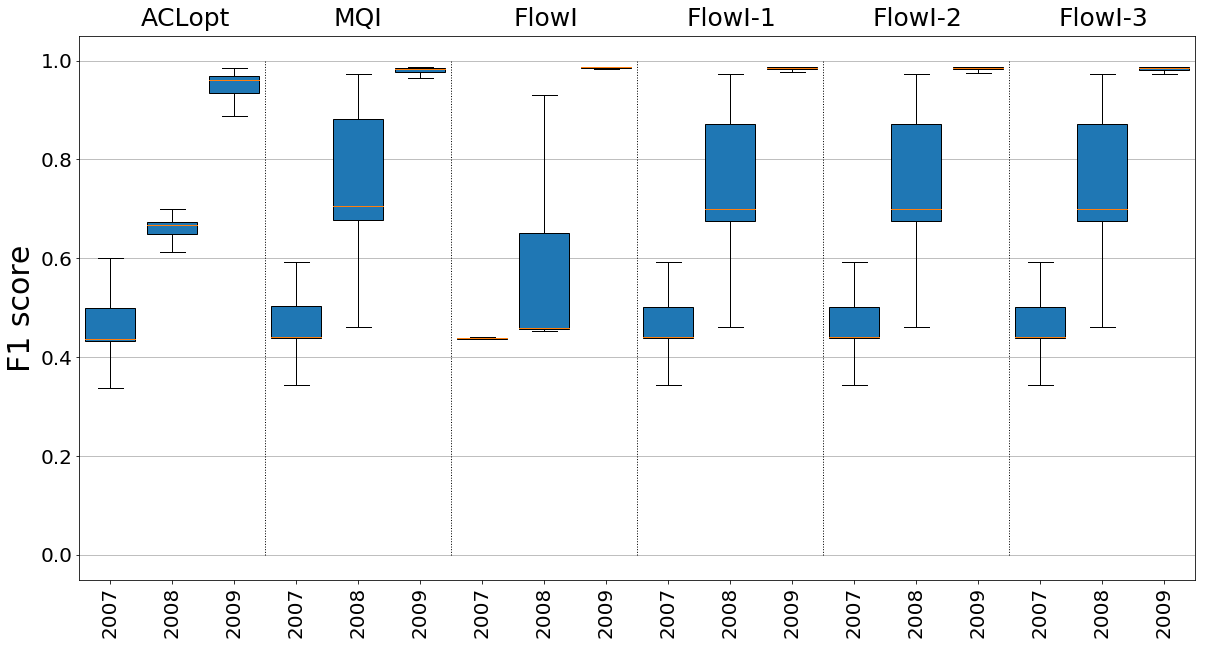

In [17]:
all_data = []
xlabels_ = []
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1score_best_cond_acl[i,j])
    all_data.append(temp_f1)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_mqi[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1score_acl_flow_flowImprove[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('F1 score',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(1.5, 1.07, 'ACLopt', fontsize=25)
plt.text(4.6, 1.07, 'MQI', fontsize=25)
plt.text(7.5, 1.07, 'FlowI', fontsize=25)
plt.text(10.3, 1.07, 'FlowI-1', fontsize=25)
plt.text(13.3, 1.07, 'FlowI-2', fontsize=25)
plt.text(16.3, 1.07, 'FlowI-3', fontsize=25)

#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([3.5, 3.5], [0, 1], 'k:', linewidth=1)
plt.plot([6.5, 6.5], [0, 1], 'k:', linewidth=1)
plt.plot([9.5, 9.5], [0, 1], 'k:', linewidth=1)
plt.plot([12.5, 12.5], [0, 1], 'k:', linewidth=1)
plt.plot([15.5, 15.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_Bucknell39_f1.png')

plt.show()

## Generate scatter plot for precision

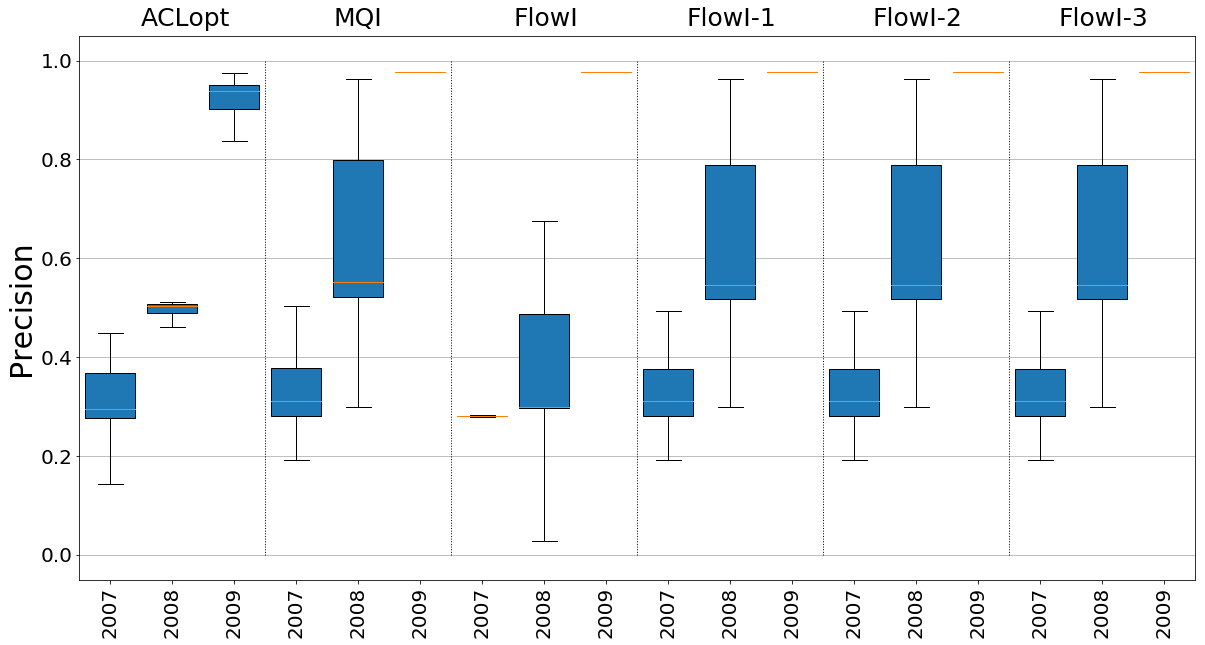

In [18]:
all_data = []
xlabels_ = []
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_best_cond_acl[i,j])
    all_data.append(temp_pre)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_mqi[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1])) 
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('Precision',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(1.5, 1.07, 'ACLopt', fontsize=25)
plt.text(4.6, 1.07, 'MQI', fontsize=25)
plt.text(7.5, 1.07, 'FlowI', fontsize=25)
plt.text(10.3, 1.07, 'FlowI-1', fontsize=25)
plt.text(13.3, 1.07, 'FlowI-2', fontsize=25)
plt.text(16.3, 1.07, 'FlowI-3', fontsize=25)

#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([3.5, 3.5], [0, 1], 'k:', linewidth=1)
plt.plot([6.5, 6.5], [0, 1], 'k:', linewidth=1)
plt.plot([9.5, 9.5], [0, 1], 'k:', linewidth=1)
plt.plot([12.5, 12.5], [0, 1], 'k:', linewidth=1)
plt.plot([15.5, 15.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_Bucknell39_precision.png')

plt.show()

## Generate scatter plot for recall

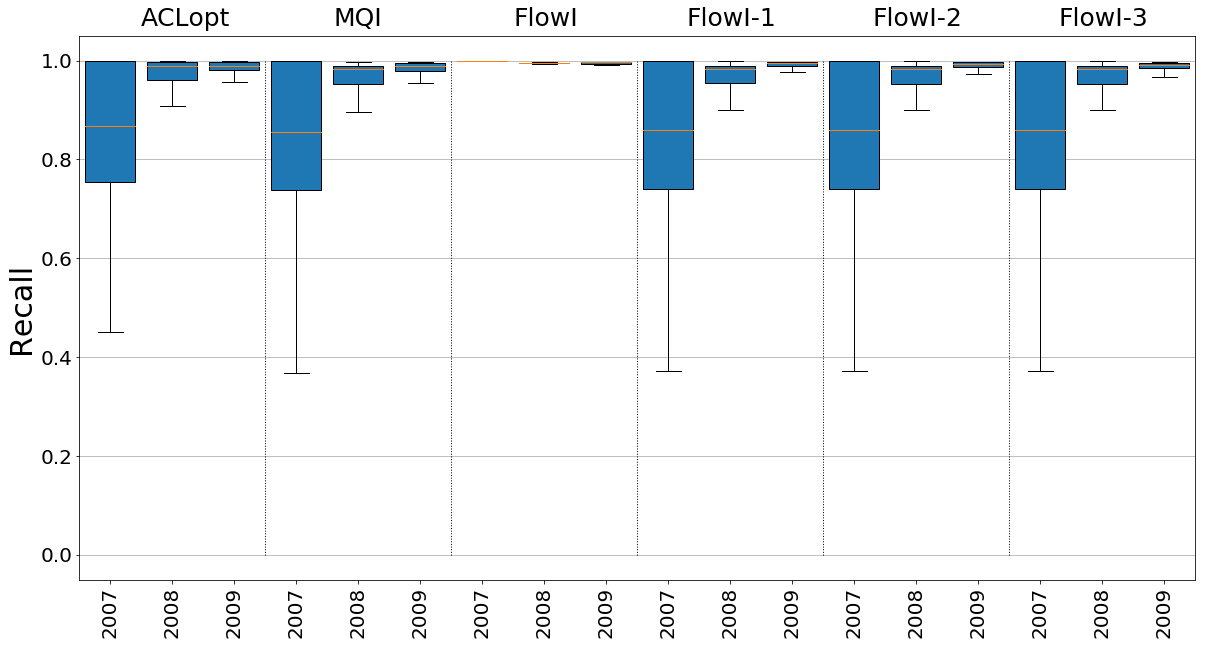

In [19]:
all_data = []
xlabels_ = []

for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_best_cond_acl[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))

for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_mqi[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('Recall',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(1.5, 1.07, 'ACLopt', fontsize=25)
plt.text(4.6, 1.07, 'MQI', fontsize=25)
plt.text(7.5, 1.07, 'FlowI', fontsize=25)
plt.text(10.3, 1.07, 'FlowI-1', fontsize=25)
plt.text(13.3, 1.07, 'FlowI-2', fontsize=25)
plt.text(16.3, 1.07, 'FlowI-3', fontsize=25)

#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([3.5, 3.5], [0, 1], 'k:', linewidth=1)
plt.plot([6.5, 6.5], [0, 1], 'k:', linewidth=1)
plt.plot([9.5, 9.5], [0, 1], 'k:', linewidth=1)
plt.plot([12.5, 12.5], [0, 1], 'k:', linewidth=1)
plt.plot([15.5, 15.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_Bucknell39_recall.png')

plt.show()

In [20]:
all_data = []
xlabels_ = []

print('Results for ACLopt')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_best_cond_acl[i,j])
        temp_rec.append(recall_best_cond_acl[i,j])
        temp_f1.append(f1score_best_cond_acl[i,j])

    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for MQI')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_mqi[i,j])
        temp_rec.append(recall_mqi[i,j])
        temp_f1.append(f1_mqi[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for FlowI')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove[i,j])
        temp_f1.append(f1score_acl_flow_flowImprove[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for FlowI-1')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter1[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter1[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter1[i,j])

    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for FlowI-2')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter2[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter2[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter2[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for FlowI-3')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter3[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter3[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter3[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))

Results for ACLopt
Feature: 2007 Precision 0.2957172248472684 Recall 0.8669200010592378 F1 0.4365380112902247
Feature: 2008 Precision 0.503413606389489 Recall 0.9893223234624147 F1 0.6672691350068343
Feature: 2009 Precision 0.9394279767142508 Recall 0.9898725770970822 F1 0.9599606553967367
Results for MQI
Feature: 2007 Precision 0.31103902925881177 Recall 0.8566453936392765 F1 0.4404354478875872
Feature: 2008 Precision 0.5514983770452893 Recall 0.9828042983064276 F1 0.7053498781895555
Feature: 2009 Precision 0.9769717435970462 Recall 0.9890113310920184 F1 0.982955071774452
Results for FlowI
Feature: 2007 Precision 0.2810029281215003 Recall 0.9993379763260334 F1 0.4386252426281716
Feature: 2008 Precision 0.29880211720471517 Recall 0.9959022481925325 F1 0.45967717746981385
Feature: 2009 Precision 0.9769717435970462 Recall 0.9966587805586685 F1 0.9867170726195
Results for FlowI-1
Feature: 2007 Precision 0.3104720053360537 Recall 0.8605116118952414 F1 0.44016017906480615
Feature: 2008 Prec